# <span style="color:#8B0000">Анализ спроса на самокаты в сервисе шеринга</span>

## О проекте

Этот проект посвящен изучению спроса на самокаты с целью оптимизации бизнес-процессов и повышения эффективности работы сервиса.  
В ходе исследования будет обработана информация о поездках, погодных условиях и проверена гипотеза о влиянии различных факторов на уровень спроса.

## Цель проекта

Главная цель проекта — выявить, какие факторы влияют на спрос в сервисе.

## План исследования

### Анализ данных
- Изучение качества данных.  
- Выявление аномалий и пропусков.  
- Предварительная обработка информации.

### Расчеты и исследования
- Определение итоговой стоимости поездок и оценка эффективности акций.  
- Анализ почасового трафика и популярности точек аренды.  
- Исследование влияния погодных условий на спрос.

### Проверка гипотез
- Оценка влияния дождя, дня недели и других факторов на спрос и продолжительность поездок.

### Регрессионное моделирование
- Прогнозирование спроса на основе временных и погодных факторов.

### Визуализация
- Создание дашборда для мониторинга ключевых показателей.  
- Презентация основных выводов.

## Ожидаемые результаты

В результате выполнения проекта будут получены следующие результаты:

- Рекомендации по оптимизации работы сервиса.  
- Инсайты о влиянии погоды, времени суток и других факторов на уровень спроса.  
- Дашборд для мониторинга ключевых показателей.

## <span style="color:#00008B">Подключение библиотек</span>

In [5]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu, kruskal, chi2_contingency, chisquare, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

**Обратите внимание! Для коректной работы билиотеки "ydata-profiling" нужен python ниже версии 3.13.0.**

In [6]:
# !pip install -U ydata-profiling

In [7]:
from ydata_profiling import ProfileReport

# <span style="color:#8B0000">Спринт 1 - предобработка</span>

## <span style="color:#00008B">Путь до папки </span>

In [8]:
current_dir = os.getcwd()
print(current_dir)
PATH_OUT = current_dir

df  = pd.read_csv(PATH_OUT+"//csv/rides.csv", 
                 sep=',', encoding='utf-8', decimal=',')
df2 = pd.read_csv(PATH_OUT+"//csv/weather.csv", 
                 sep=',', encoding='utf-8', decimal=',')

C:\Users\mailm\Yandex_AD_scooters\Jupyter notebooks


## <span style="color:#00008B">Полезные функции для работы  </span>

In [9]:
def clean_data_with_threshold(df, variable, threshold, flag):
    """
    Очищает DataFrame, удаляя значения в указанной переменной, которые находятся за пределами заданного порога.
    Создает boxplot до и после очистки.

    Args:
        df (pd.DataFrame): Входной DataFrame.
        variable (str): Название столбца для очистки.
        threshold (float): Пороговое значение.
        flag (str):  Если 'below', удаляет значения меньше порога.
                     Если 'above', удаляет значения больше порога.
                     Если 'both', удаляет значения как меньше, так и больше порога (нужен кортеж из двух значений).

    Returns:
        pd.DataFrame: Очищенный DataFrame.
    """

    # Boxplot до очистки
    plot_numeric_boxplots(df)

    # Очистка данных
    if flag == 'below':
        cleaned_df = df[df[variable] >= threshold].copy()
    elif flag == 'above':
        cleaned_df = df[df[variable] <= threshold].copy()
    elif flag == 'both':
        cleaned_df = df[(df[variable] >= threshold[0]) & (df[variable] <= threshold[1])].copy()
    else:
        raise ValueError("Недопустимое значение флага. Должно быть 'below', 'above' или 'both'.")


    # Boxplot после очистки
    plot_numeric_boxplots(cleaned_df)
    
    return cleaned_df

## <span style="color:#00008B">Графики для просмотра данных </span>

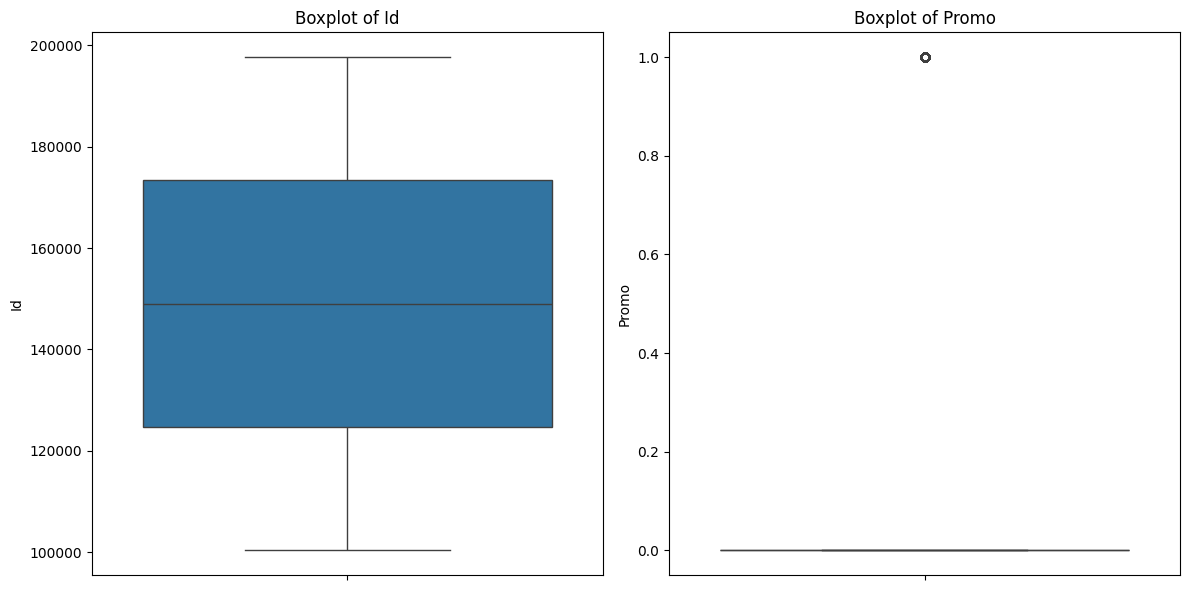

In [10]:
def plot_numeric_boxplots(df, figsize=(12, 6), plot_per_row=2):
    """
    Строит boxplot'ы для всех числовых столбцов в DataFrame.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Входной DataFrame с данными
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах, по умолчанию (12, 6)
    plot_per_row : int, optional
        Количество boxplot'ов в одной строке, по умолчанию 2
    
    Возвращает:
    --------
    None
        Отображает графики, но не возвращает значений
    """
    # Выбираем все числовые столбцы (включая int, float и другие числовые типы)
    numeric_columns = df.select_dtypes(include=['number']).columns
    n_columns = len(numeric_columns)
    
    if n_columns == 0:
        print("No numeric columns found in the DataFrame")
        return
    
    # Вычислить необходимое количество строк
    n_rows = (n_columns + plot_per_row - 1) // plot_per_row
    
    # Создание подзаголовков
    fig, axes = plt.subplots(n_rows, plot_per_row, figsize=(figsize[0], figsize[1] * n_rows))
    
    # Сгладить массив осей для упрощения итерации
    axes = np.array(axes).flatten()
    
    # Создание коробочных графиков
    for idx, column in enumerate(numeric_columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column}')
        axes[idx].set_ylabel(column)
    
    # Удалить пустые подзаголовки, если таковые имеются
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# df = pd.DataFrame(your_data)
plot_numeric_boxplots(df)
# plot_numeric_boxplots(df2) - No numeric columns found in the DataFrame

## <span style="color:#00008B">Просмотр имеюшихся данных  </span>

#### <span style="color:#006400">Данные в rides.csv</span>

In [11]:
df.head(5)

Id           Start Date             End Date Start Location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   

    Start District End Location     End District Distance  Promo  
0    Юго-Восточный      Майская      Октябрьский   4069.0      0  
1         заречный   Спортивная      октябрьский   4515.0      0  
2      Октябрьский     Суворова        ленинский   4520.0      0  
3      Центральный      Рабочая  Северо-Западный   3881.0      0  
4  Северо-Западный    Юбилейная    Юго-Восточный   4029.0      0

In [12]:
#Анализирует DataFrame: проверяет пропуски, дубликаты, выводит статистику и примеры данных для числовых и категориальных столбцов
def check_data(data_df):
    print ('\033[5m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Id              102255 non-null  int64 
 1   Start Date      102255 non-null  object
 2   End Date        102255 non-null  object
 3   Start Location  102255 non-null  object
 4   Start District  102255 non-null  object
 5   End Location    102255 non-null  object
 6   End District    102255 non-null  object
 7   Distance        101022 non-null  object
 8   Promo           102255 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 7.0+ MB
None

Проверка пропусков
Количество пропусков: 1233
Доля пропусков: 0.2%
Доля строк содержащих пропуски: 1.2%

Проверка на дубликаты
Количество полных дубликатов:  4883

Первые пять строк датасета


Id           Start Date             End Date Start Location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   

  Start District End Location End District Distance  Promo  
0  Юго-Восточный      Майская  Октябрьский   4069.0      0  
1       заречный   Спортивная  октябрьский   4515.0      0


Описание количественных данных:


count           mean           std       min       25%       50%  \
Id     102255.0  149024.057679  28110.574992  100340.0  124682.5  149028.0   
Promo  102255.0       0.019755      0.139156       0.0       0.0       0.0   

            75%       max  
Id     173372.5  197711.0  
Promo       0.0       1.0


Описание категориальных данных:


count unique                  top   freq
Start Date      102255  96526  2023-07-02 11:35:14      4
End Date        102255  95949                  NaT    579
Start Location  102255    463           Ломоносова   1675
Start District  102255     13          Центральный  18115
End Location    102255    495           Спортивная   1511
End District    102255     14          Центральный  18878
Distance        101022   6535                  4.0   1162


Вывод уникальных значений по каждому категориаьному признаку:
_Start Date


Start Date
2023-07-02 11:35:14    4
2023-07-15 18:09:14    4
2023-06-03 15:07:27    3
2023-06-02 20:02:05    3
2023-06-03 15:40:44    3
                      ..
2023-07-31 22:55:48    1
2023-07-31 22:57:28    1
2023-07-31 23:10:07    1
2023-07-31 23:12:40    1
2023-04-22 09:19:13    1
Name: count, Length: 96526, dtype: int64

_End Date


End Date
NaT                    579
2023-05-20 19:58:25      4
2023-05-17 19:30:32      4
2023-06-18 18:42:24      4
2023-07-03 20:07:12      4
                      ... 
2023-07-31 23:16:03      1
2023-07-31 23:13:04      1
2023-07-31 23:23:49      1
2023-07-31 23:33:50      1
2023-04-22 09:49:56      1
Name: count, Length: 95949, dtype: int64

_Start Location


Start Location
Ломоносова           1675
Луговая              1655
Майская              1648
Восточная            1584
Спортивная           1583
                     ... 
Ул. Московская          1
Ул. Северная            1
Ул. Энтузиастов         1
Ул. Матросова           1
Ул. Комсомольская       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
Центральный        18115
Юго-Восточный      13542
Ленинский          11308
Северо-Западный    11304
Октябрьский         9729
центральный         8259
Заречный            6803
юго-восточный       5869
ленинский           5011
северо-западный     4973
октябрьский         4330
заречный            3011
северо западный        1
Name: count, dtype: int64

_End Location


End Location
Спортивная      1511
Восточная       1450
Ломоносова      1441
Буденного       1406
Луговая         1405
                ... 
ул почтовая        1
Ул. Заречная       1
Ул. Мичурина       1
Ул. Шевченко       1
ул матросова       1
Name: count, Length: 495, dtype: int64

_End District


End District
Центральный        18878
Юго-Восточный      14612
Ленинский          12090
Северо-Западный    12055
Октябрьский        10519
Заречный            7023
центральный         6808
юго-восточный       5203
северо-западный     4411
ленинский           4308
октябрьский         3794
заречный            2499
Северо Западный       33
северо западный       22
Name: count, dtype: int64

_Distance


Distance
4.0       1162
3.0        980
5.0        524
2.0        239
6.0        153
          ... 
6636.0       1
1645.0       1
6917.0       1
8338.0       1
8604.0       1
Name: count, Length: 6535, dtype: int64

#### <span style="color:#006400">Данные в weather.csv</span>

In [13]:
df2.head(5)

Datetime Temperature Precipitation Total Wind Gust Wind Speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0

In [14]:
check_data(df2)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

Проверка пропусков
Количество пропусков: 134
Доля пропусков: 0.6%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


Datetime Temperature Precipitation Total Wind Gust Wind Speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0


Описание количественных данных:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Описание категориальных данных:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Вывод уникальных значений по каждому категориаьному признаку:
_Datetime


Datetime
2023-08-31T23:00:00    1
2023-04-01T00:00:00    1
2023-04-01T01:00:00    1
2023-04-01T02:00:00    1
2023-04-01T03:00:00    1
                      ..
2023-04-01T12:00:00    1
2023-04-01T11:00:00    1
2023-04-01T10:00:00    1
2023-04-01T09:00:00    1
2023-04-01T08:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245     9
25.610245     8
15.040245     8
11.250245     7
20.140245     6
             ..
15.410245     1
14.290245     1
14.850245     1
13.3102455    1
12.710245     1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
1.8       6
1.7       6
2.2       6
2.1       4
2.4       2
2.3       2
2         2
1.9       2
2.6       2
mm        1
2.9       1
3         1
5         1
5.8       1
3.3       1
3.9       1
3.4       1
2.8       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
67.67999       1
65.520004      1
66.96          1
65.159996      1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743    36
5.3517847    34
6.28713      33
3.319036     33
4.0249224    32
             ..
23.132626     1
25.600533     1
22.42427      1
21.94524      1
22.26477      1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
19.2           1
14.1           1
18.300001      1
14.400001      1
13.500001      1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
2.2343435       1
26.962963       1
19.630304       1
53.81818        1
32.435688       1
Name: count, Length: 495, dtype: int64

## <span style="color:#00008B">Начало предобработки  </span>

### <span style="color:#006400">Данные в rides.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [15]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(5)

id           start_date             end_date start_location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   

    start_district end_location     end_district distance  promo  
0    Юго-Восточный      Майская      Октябрьский   4069.0      0  
1         заречный   Спортивная      октябрьский   4515.0      0  
2      Октябрьский     Суворова        ленинский   4520.0      0  
3      Центральный      Рабочая  Северо-Западный   3881.0      0  
4  Северо-Западный    Юбилейная    Юго-Восточный   4029.0      0

#### Вычислим длительность сессии между 'Start Date' и 'End Date' в формате HH:MM:SS и дополнительно в минутах

In [16]:
def calculate_session_time(df):
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df['session_time'] = df['end_date'] - df['start_date']
    df['session_time'] = df['session_time'].apply(
        lambda x: str(x).split()[-1] if 'days' in str(x) else str(x)
    )
    df['session_time_(minutes)'] = pd.to_timedelta(df['session_time']).dt.total_seconds() / 60
    return df

df = calculate_session_time(df)
df.to_csv("datafrem_data.csv")

#### наведем порядок в типах данных

##### Было: 

In [17]:
df.dtypes

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location                    object
start_district                    object
end_location                      object
end_district                      object
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object

##### Стало:

In [18]:
# Преобразование столбцов с локациями в строковый тип (text/string)
location_columns = ['start_location', 'start_district', 'end_location', 'end_district']
df[location_columns] = df[location_columns].astype('string')

# Преобразуем в строку формата HH:MM:SS
df['session_time'] = pd.to_timedelta(df['session_time']).astype(str).str[-8:]
print(df.dtypes)

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location            string[python]
start_district            string[python]
end_location              string[python]
end_district              string[python]
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object


тип данных в session_time можно сделать timedelta, но тогда будут указывать данные в формате дней:часов:минут:секунд а для красоты пока что оставлю 
тип object. (позже улдалить эту колонку(т.к есть Session Time (minutes)))

#### Преведем числовой столбец к целым числам, отбрасывая дробную часть и NaN

In [19]:
def convert_id_column(df, column='distance'):
    df = df.copy()
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.0$', '', regex=True) 
    df[column] = df[column].str.replace('nan', '', regex=True)
    df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

df = convert_id_column(df)

#### Очистим и стандартизируем форматы адресов ()

In [20]:
df['start_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['start_location']))
df['end_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['end_location']))
df['start_district'] = list(map(lambda x: x.lower(), df['start_district']))
df['end_district'] = list(map(lambda x: x.lower(), df['end_district']))
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский      4069      0   
1         заречный   спортивная      октябрьский      4515      0   
2      октябрьский     суворова        ленинский      4520      0   
3      центральный      рабочая  северо-западный      3881      0   
4  северо-западный    юбилейная    юго-восточный      4029      0   

  session_time  session_time_(minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667

### <span style="color:#006400">Данные в weather.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [21]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2.head()

datetime temperature precipitation_total wind_gust wind_speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   

  cloud_cover_total sunshine_duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0

#### наведем порядок в типах данных

##### Было: 

In [22]:
df2.dtypes

datetime               object
temperature            object
precipitation_total    object
wind_gust              object
wind_speed             object
cloud_cover_total      object
sunshine_duration      object
dtype: object

##### Стало: 

In [23]:
#первую строку надо удалить, чтобы типы преобразовать
units = {
    'temperature': '°C',
    'precipitation_total': 'mm',
    'wind_gust': 'km/h',
    'wind_speed': 'km/h',
    'cloud_cover_total': '%',
    'sunshine_duration': 'min'
}

df2 = df2.iloc[1:].reset_index(drop=True)

df2 = df2.astype({
    'datetime': 'datetime64[ns]',
    'temperature': 'float64',
    'precipitation_total': 'float64',
    'wind_gust': 'float64',
    'wind_speed': 'float64',
    'cloud_cover_total': 'float64',
    'sunshine_duration': 'float64'
})
print(df2.dtypes)
df.head(5)

datetime               datetime64[ns]
temperature                   float64
precipitation_total           float64
wind_gust                     float64
wind_speed                    float64
cloud_cover_total             float64
sunshine_duration             float64
dtype: object


id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский      4069      0   
1         заречный   спортивная      октябрьский      4515      0   
2      октябрьский     суворова        ленинский      4520      0   
3      центральный      рабочая  северо-западный      3881      0   
4  северо-западный    юбилейная    юго-восточный      4029      0   

  session_time  session_time_(minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667

## <span style="color:#00008B">Посмотрим на дубликаты и пропуски </span>

### <span style="color:#006400">Данные в rides.csv</span>

#### Полные дубликаты и по столбцам

In [24]:
duplicates = df[df.duplicated()]  # keep=False
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 4831 полных дубликатов


In [25]:
df.isna().sum()

id                          0
start_date                  0
end_date                  579
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    579
dtype: int64

при удалении полных дубликатов получим  101022 - 4831 = 96191 строк данных (сейчас показывает 579 пропусков, но после удаления полных дубликатов 
получим 555 пропусков (проверял в другом notebook)) из этого  следует 2 вывода 1) мы можем просто удалить данные пропуски т.к. они составляют 
всего лишь 0,58% от всех данных ((555 * 100)/96191) либо 2) проведем небольшое исследование данных пропусков:    

#### исследование пропусков в end_date 

In [26]:
#Выводит топ-5 стартовых точек поездок с пропущенными датами окончания (end_date)
missing_data = df[df['end_date'].isna()]
print("Типичные стартовые точки для поездок без end_date:")
print(missing_data['start_location'].value_counts().head(5))

Типичные стартовые точки для поездок без end_date:
start_location
спортивная    21
майская       16
восточная     15
ломоносова    13
луговая       13
Name: count, dtype: int64


In [27]:
# Заполнить пропуски средним временем поездки для этих локаций
# for location in ['Спортивная', 'Ломоносова', 'Майская', 'Восточная', 'Чехова']:
#     avg_time = df[df['start_location'] == location]['session_time_(minutes)'].mean()
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'session_time_(minutes)'] = avg_time
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'end_date'] = \
#         df['start_date'] + pd.to_timedelta(avg_time, unit='minutes')

таким образом мы можем заполнить пропуски средним временем поездки для часто встречаюшихся локаций - **вариант плохой, заполним дальше по коду**

#### Посмотрим на повторяющиеся значения в других столбцах

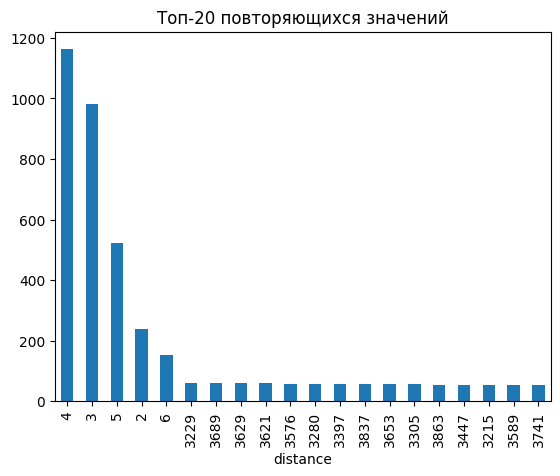

In [28]:
df['distance'].value_counts().head(20).plot(kind='bar')
plt.title("Топ-20 повторяющихся значений")
plt.show()

слишком много значений <100 в колонке distance (нужно посмотреть внимательнее возможно это будут выбросы) (потом мы их очистили см. далее)

#### посмотрим дубликаты в id

In [29]:
duplicate_ids = df.duplicated(subset=['id'], keep=False)
print(f"Найдено {duplicate_ids.sum()} дубликатов по ID")

Найдено 9662 дубликатов по ID


#### Посмотрим на неявные дубликаты

Статистика дубликатов:
Exact Duplicates: 9662
Id Duplicates: 9662
Time Location Duplicates: 9662
Inconsistent Duplicates: 9614


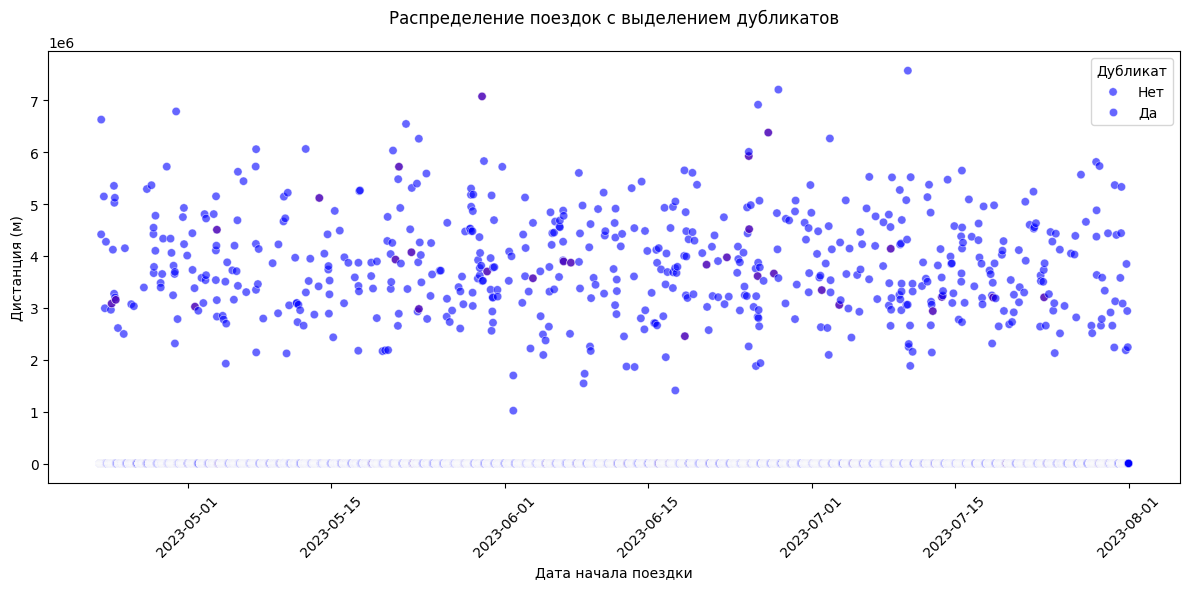

In [30]:
def check_all_duplicates(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о поездках
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по ID
    duplicate_stats = {
        'exact_duplicates': 0,
        'id_duplicates': 0,
        'time_location_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # Дубликаты по ID
    id_duplicates = df[df.duplicated(subset=['id'], keep=False)]
    duplicate_stats['id_duplicates'] = len(id_duplicates)
    
    # 2. Проверка неявных дубликатов
    # По времени и локациям
    time_loc_cols = ['start_date', 'end_date', 
                     'start_location', 'end_location']
    time_loc_duplicates = df[df.duplicated(subset=time_loc_cols, keep=False)]
    duplicate_stats['time_location_duplicates'] = len(time_loc_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['start_date', 'end_date', 
                'start_district', 'end_district',
                'distance']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        id_duplicates,
        time_loc_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates(df, duplicates):
    """
    Визуализация результатов проверки дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график поездок с выделением дубликатов
    ax = sns.scatterplot(
        x='start_date',
        y='distance',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение поездок с выделением дубликатов', pad=20)
    plt.xlabel('Дата начала поездки')
    plt.ylabel('Дистанция (м)')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates(df, duplicates, strategy='keep_first'):
    """
    Очистка данных от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")

duplicates, stats = check_all_duplicates(df)


print("Статистика дубликатов:")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

# Визуализация
visualize_duplicates(df, duplicates)

Статистика дубликатов:
Exact Duplicates: 0
Id Duplicates: 9662
Time Location Duplicates: 9662
Inconsistent Duplicates: 9614


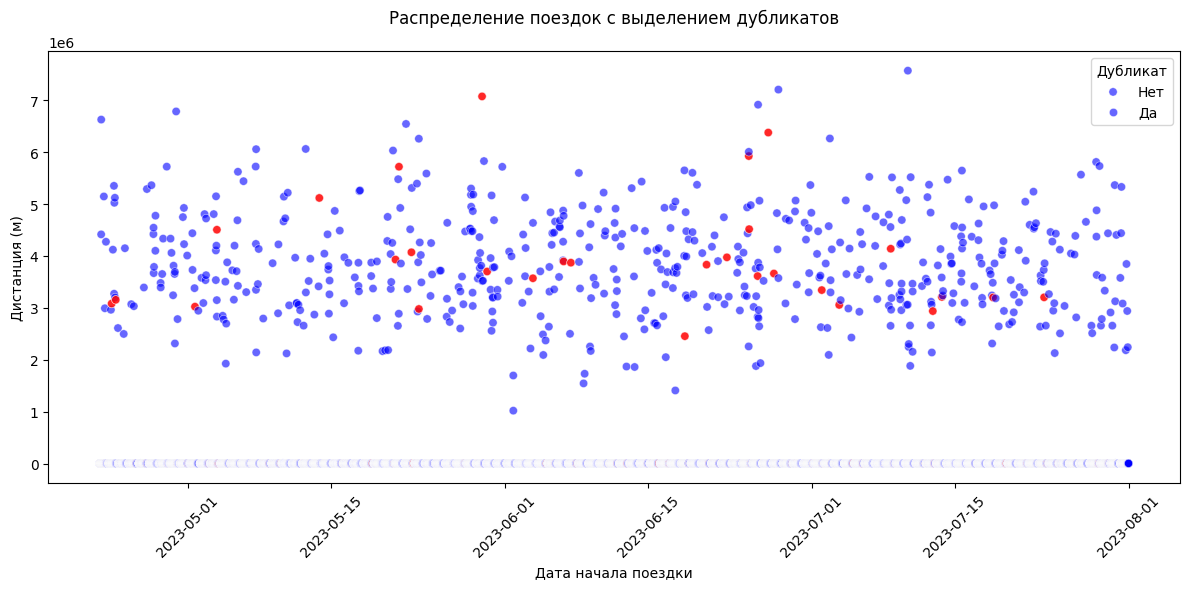

In [31]:
duplicates, stats = check_all_duplicates(df)


print("Статистика дубликатов:")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

# Визуализация
visualize_duplicates(df, duplicates)

Наблюдается значительное количество дубликатов, особенно по ID и времени/локациям

#### Посмотрим на выбросы(есть ли они вообще)

Заметим из предыдущего шага, что в distance есть данные <= 100 (250/500/1000)

In [32]:
df[df["distance"] <= 1000]

id          start_date            end_date start_location  \
8       100348 2023-04-22 09:21:42 2023-04-22 09:39:04       западная   
21      100360 2023-04-22 10:01:51 2023-04-22 10:31:17     лермонтова   
67      100405 2023-04-22 11:08:22 2023-04-22 12:00:35         ленина   
70      100408 2023-04-22 11:18:25 2023-04-22 11:36:19   строительная   
108     100443 2023-04-22 12:16:46 2023-04-22 12:50:14      заводская   
...        ...                 ...                 ...            ...   
102007  197473 2023-07-31 19:44:01 2023-07-31 20:29:57         гоголя   
102072  197538 2023-07-31 20:23:15 2023-07-31 20:53:32        полевая   
102117  197581 2023-07-31 20:57:53 2023-07-31 21:33:29    октябрьская   
102149  197611 2023-07-31 21:22:02 2023-07-31 21:40:39       трудовая   
102236  197693 2023-07-31 23:10:07 2023-07-31 23:23:49     пионерская   

         start_district  end_location     end_district  distance  promo  \
8             ленинский       озерная    юго-восточный         3      0   
21            ленинский        дружбы      центральный         5      0   
67            ленинский      овражная      центральный         5      0   
70      северо-западный  строительная  северо-западный         4      0   
108     северо-западный     свердлова      центральный         4      0   
...                 ...           ...              ...       ...    ...   
102007      центральный   энтузиастов      центральный         3      0   
102072        ленинский       чапаева  северо-западный         3      0   
102117         заречный     солнечная      центральный         6      0   
102149      центральный        гоголя      центральный         4      0   
102236         заречный      горького    юго-восточный         3      0   

       session_time  session_time_(minutes)  is_duplicate  
8          00:17:22               17.366667         False  
21         00:29:26               29.433333         False  
67         00:52:13               52.216667         False  
70         00:17:54               17.900000         False  
108        00:33:28               33.466667         False  
...             ...                     ...           ...  
102007     00:45:56               45.933333         False  
102072     00:30:17               30.283333         False  
102117     00:35:36               35.600000         False  
102149     00:18:37               18.616667         False  
102236     00:13:42               13.700000         False  

[3122 rows x 12 columns]

Видно, что в distance	- 3122 значения <= 1000, их стоит считать выбросами  т.к. 
1) Они составляют аномально малую дистанцию по сравнению с основным распределением данных 
2) Могут быть ошибками измерений или техническими артефактами (например, тестовые поездки или сбои GPS)

#### проверим другие столбцы 

In [33]:
df[df["session_time_(minutes)"] >= 60]

id          start_date            end_date start_location  \
357     100679 2023-04-22 16:21:14 2023-04-22 17:30:01      рябиновая   
435     100751 2023-04-22 17:09:36 2023-04-22 18:23:37         речная   
544     100855 2023-04-22 18:28:51 2023-04-22 19:37:36        майская   
564     100874 2023-04-22 18:37:57 2023-04-22 19:43:22      цветочная   
661     100963 2023-04-22 19:28:01 2023-04-22 20:32:09    октябрьская   
...        ...                 ...                 ...            ...   
101366  196863 2023-07-31 08:32:44 2023-07-31 09:45:04         ленина   
101779  197255 2023-07-31 16:44:38 2023-07-31 17:45:54        озерная   
101839  197313 2023-07-31 17:45:13 2023-07-31 18:53:48        красная   
101929  197397 2023-07-31 18:59:00 2023-07-31 20:06:21      рябиновая   
102111  197575 2023-07-31 20:54:18 2023-07-31 21:54:32     пионерская   

         start_district   end_location     end_district  distance  promo  \
357     северо-западный       нагорная      центральный      5690      0   
435       юго-восточный     спортивная      октябрьский      4466      0   
544         октябрьский      солнечная      центральный      5117      0   
564     северо-западный  комсомольская         заречный      4134      0   
661            заречный       комарова        ленинский      6992      0   
...                 ...            ...              ...       ...    ...   
101366        ленинский     пионерская         заречный      7154      1   
101779    юго-восточный          новая  северо-западный      5537      0   
101839  северо-западный    энергетиков    юго-восточный      4935      0   
101929  северо-западный   дзержинского      центральный      5144      0   
102111         заречный   карла маркса        ленинский      7130      0   

       session_time  session_time_(minutes)  is_duplicate  
357        01:08:47               68.783333         False  
435        01:14:01               74.016667         False  
544        01:08:45               68.750000         False  
564        01:05:25               65.416667         False  
661        01:04:08               64.133333         False  
...             ...                     ...           ...  
101366     01:12:20               72.333333         False  
101779     01:01:16               61.266667         False  
101839     01:08:35               68.583333         False  
101929     01:07:21               67.350000         False  
102111     01:00:14               60.233333         False  

[928 rows x 12 columns]

#### Удалим все не нужное / Заполним все нужное

##### 1) удалим полные дубликаты  (4831 удалаяем)

In [34]:
df = df.drop_duplicates()
df.shape

(96191, 12)

##### 2) заполним пропуски в end_date и session_time_(minutes) (сразу округлим сделав данные красивыми)

In [35]:
df["distance"] = pd.to_numeric(df["distance"], errors="coerce")

# Удаление строк с некорректными расстояниями
df = df.dropna(subset=["distance"])

# Расчет продолжительности поездки в часах
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# Фильтрация валидных записей
valid_mask = (df["duration"] > 0) & (df["distance"] > 0)
valid_entries = df[valid_mask].copy()  # Явное создание копии

# Расчет средней скорости
valid_entries["speed"] = valid_entries["distance"] / valid_entries["duration"]
average_speed = valid_entries["speed"].median()

# Восстановление end_date для дубликатов
duplicate_mask = df.duplicated(subset=["end_date"], keep=False)
df.loc[duplicate_mask, "end_date"] = df.loc[duplicate_mask, "start_date"] + pd.to_timedelta(
    df.loc[duplicate_mask, "distance"] / average_speed, 
    unit="h"
)

df = df.drop(columns=["duration"])

In [36]:
df.isna().sum()

id                          0
start_date                  0
end_date                    0
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    555
is_duplicate                0
dtype: int64

In [37]:
df = calculate_session_time(df)

In [38]:
# Округляем столбец 'session_time_(minutes)' до 6 знаков после запятой
df['session_time_(minutes)'] = df['session_time_(minutes)'].round(1)

# Или до 2 знаков, если нужно:
# df['session_time_(minutes)'] = df['session_time_(minutes)'].round(2)

In [39]:
df.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
is_duplicate              0
dtype: int64

##### 3) удалим  значения которые являються выбросами по колонке distance

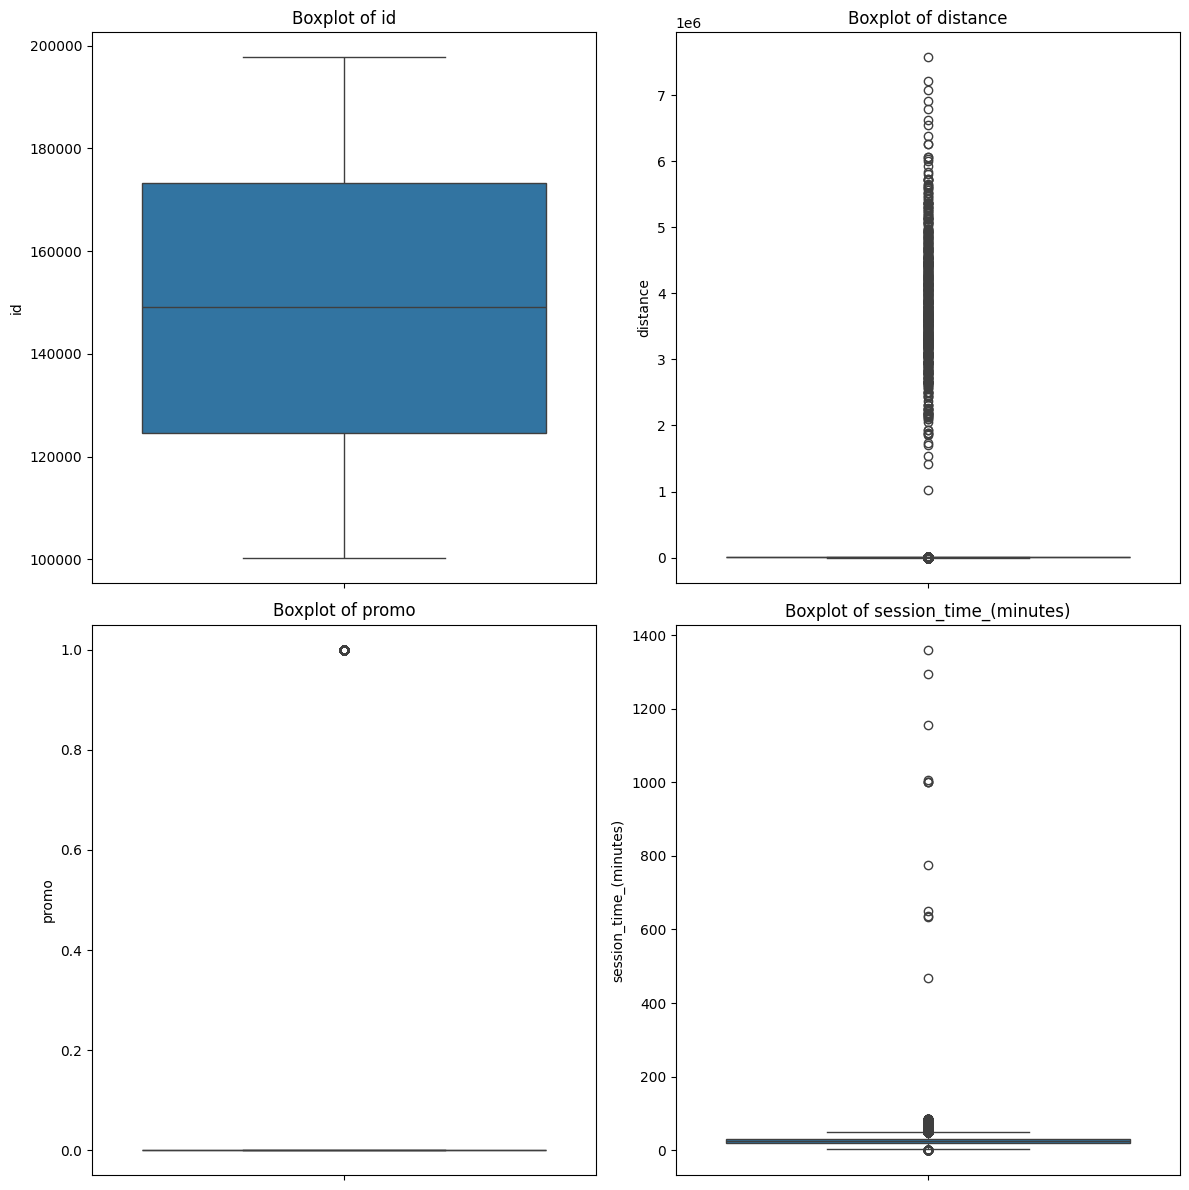

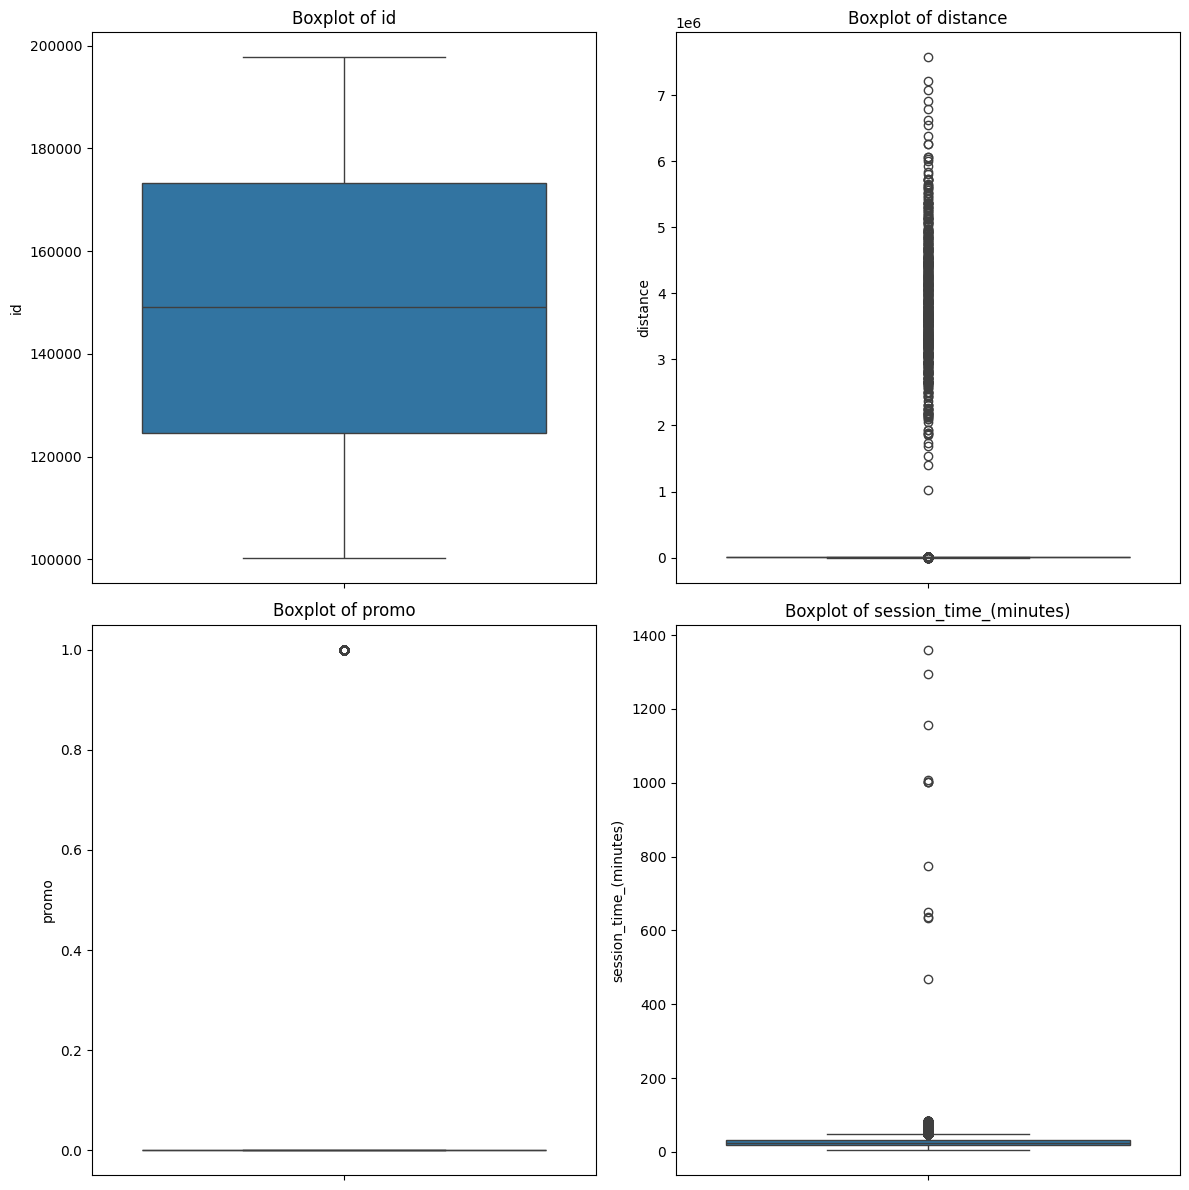

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        озерная   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       мичурина   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     лермонтова   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      рябиновая   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     молодежная   

         start_district  end_location     end_district  distance  promo  \
0         юго-восточный       майская      октябрьский      4069      0   
1              заречный    спортивная      октябрьский      4515      0   
2           октябрьский      суворова        ленинский      4520      0   
3           центральный       рабочая  северо-западный      3881      0   
4       северо-западный     юбилейная    юго-восточный      4029      0   
...                 ...           ...              ...       ...    ...   
102250    юго-восточный  первомайская  северо-западный      3302      0   
102251        ленинский       садовая         заречный      4992      0   
102252        ленинский     куйбышева      центральный      2781      0   
102253  северо-западный   энергетиков    юго-восточный      6466      0   
102254    юго-восточный   маяковского      центральный      3561      0   

       session_time  session_time_(minutes)  is_duplicate  
0          00:23:42                    23.7         False  
1          00:28:25                    28.4         False  
2          00:38:19                    38.3         False  
3          00:31:49                    31.8         False  
4          00:30:40                    30.7         False  
...             ...                     ...           ...  
102250     00:21:49                    21.8         False  
102251     00:39:34                    39.6         False  
102252     00:21:17                    21.3         False  
102253     00:46:23                    46.4         False  
102254     00:22:02                    22.0         False  

[93222 rows x 12 columns]

In [40]:
df = clean_data_with_threshold(df, "distance", 1000, "below")
df

##### 4)посмотрим и почистим данные в session_time_(minutes)

In [41]:
df[df["session_time_(minutes)"]>=200]

id          start_date                      end_date  \
7334    107304 2023-04-30 15:12:50 2023-05-19 23:01:44.748658617   
10158   110004 2023-05-03 18:18:24 2023-05-27 07:13:18.599306918   
10326   110168 2023-05-03 20:21:01 2023-05-16 19:01:11.404371247   
12064   111814 2023-05-05 21:39:02 2023-05-31 14:26:04.036526730   
31853   130683 2023-05-27 15:23:31 2023-06-08 12:57:37.340754690   
33911   132635 2023-05-28 21:57:48 2023-06-21 14:39:51.183224684   
54273   152031 2023-06-17 16:13:03 2023-06-24 02:49:14.667031491   
59166   156662 2023-06-22 10:12:20 2023-07-14 02:53:29.989620580   
63049   160352 2023-06-25 18:40:07 2023-07-13 11:21:53.179825486   
78077   174691 2023-07-09 19:44:58 2023-07-31 06:35:30.514587584   
84077   180406 2023-07-15 16:51:18 2023-08-10 12:07:24.498229735   
102108  197572 2023-07-31 20:51:23 2023-08-14 07:25:37.719536260   

         start_location   start_district end_location     end_district  \
7334            озерная    юго-восточный      чапаева  северо-западный   
10158     комсомольская         заречный    заводская  северо-западный   
10326           свободы        ленинский        южная      центральный   
12064          заречная    юго-восточный    заводская  северо-западный   
31853         совхозная      центральный        труда      центральный   
33911        спортивная      октябрьский     мичурина        ленинский   
54273       маяковского      центральный    матросова      центральный   
59166         береговая      центральный      озерная    юго-восточный   
63049         совхозная      центральный  октябрьская         заречный   
78077   железнодорожная      центральный      чкалова    юго-восточный   
84077         некрасова  северо-западный    шоссейная         заречный   
102108        юбилейная    юго-восточный     дорожная    юго-восточный   

        distance  promo        session_time  session_time_(minutes)  \
7334     4227698      0  07:48:54.748658617                   468.9   
10158    5149229      0  12:54:54.599306918                   774.9   
10326    2831768      0  22:40:10.404371247                  1360.2   
12064    5622015      0  16:47:02.036526730                  1007.0   
31853    2602970      0  21:34:06.340754690                  1294.1   
33911    5183736      0  16:42:03.183224684                  1002.1   
54273    1409216      0  10:36:11.667031491                   636.2   
59166    4746079      0  16:41:09.989620580                  1001.2   
63049    3871126      0  16:41:46.179825486                  1001.8   
78077    4692813      0  10:50:32.514587584                   650.5   
84077    5644662      0  19:16:06.498229735                  1156.1   
102108   2940248      0  10:34:14.719536260                   634.2   

        is_duplicate  
7334           False  
10158          False  
10326          False  
12064          False  
31853          False  
33911          False  
54273          False  
59166          False  
63049          False  
78077          False  
84077          False  
102108         False

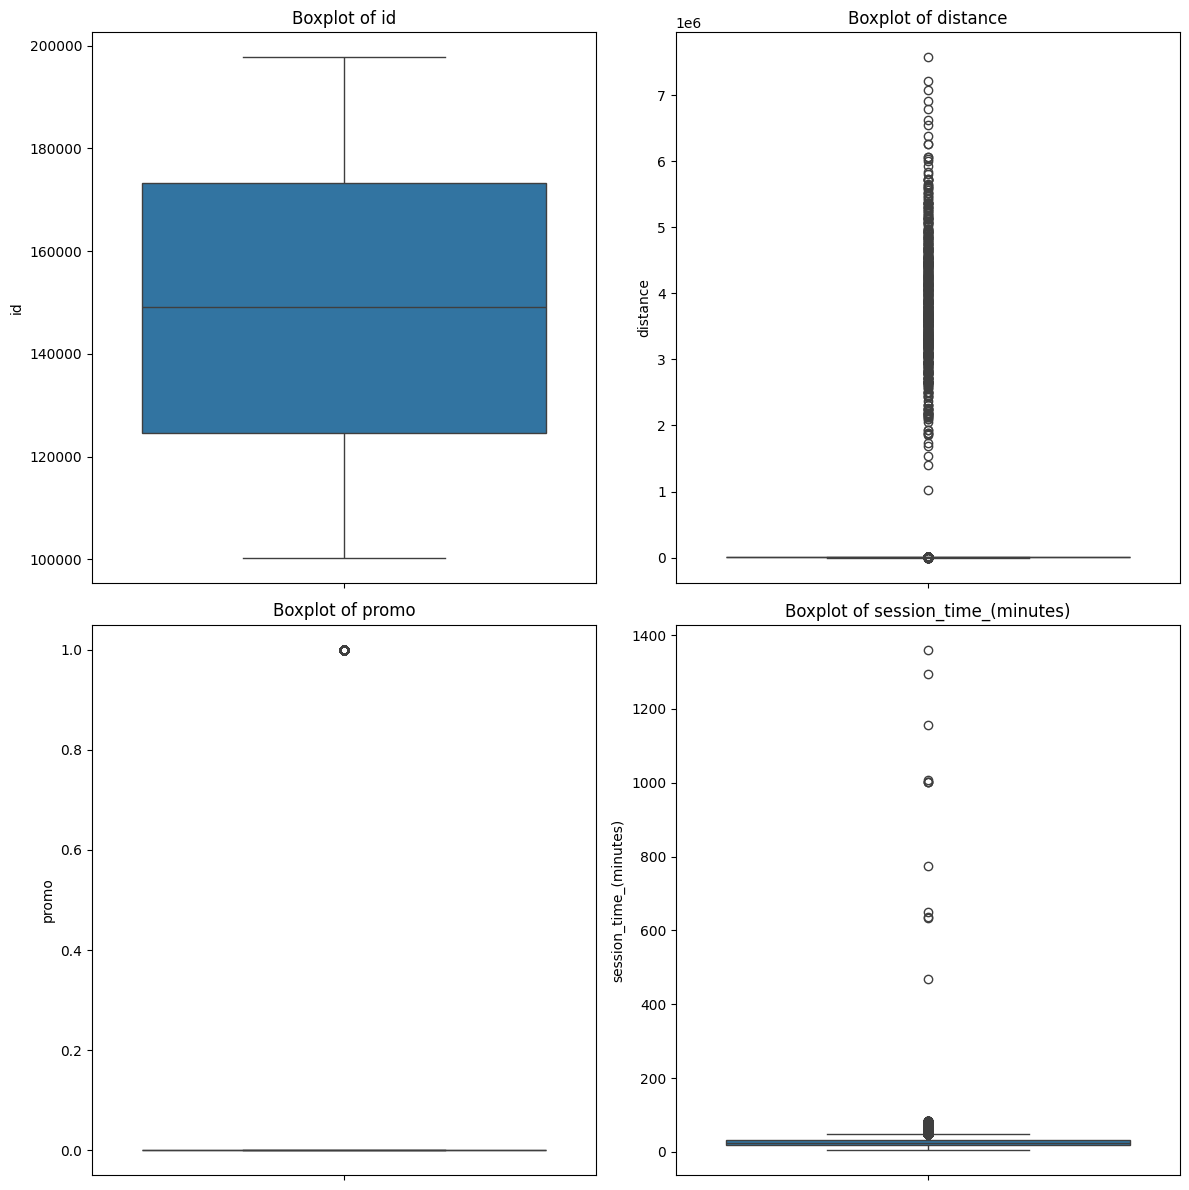

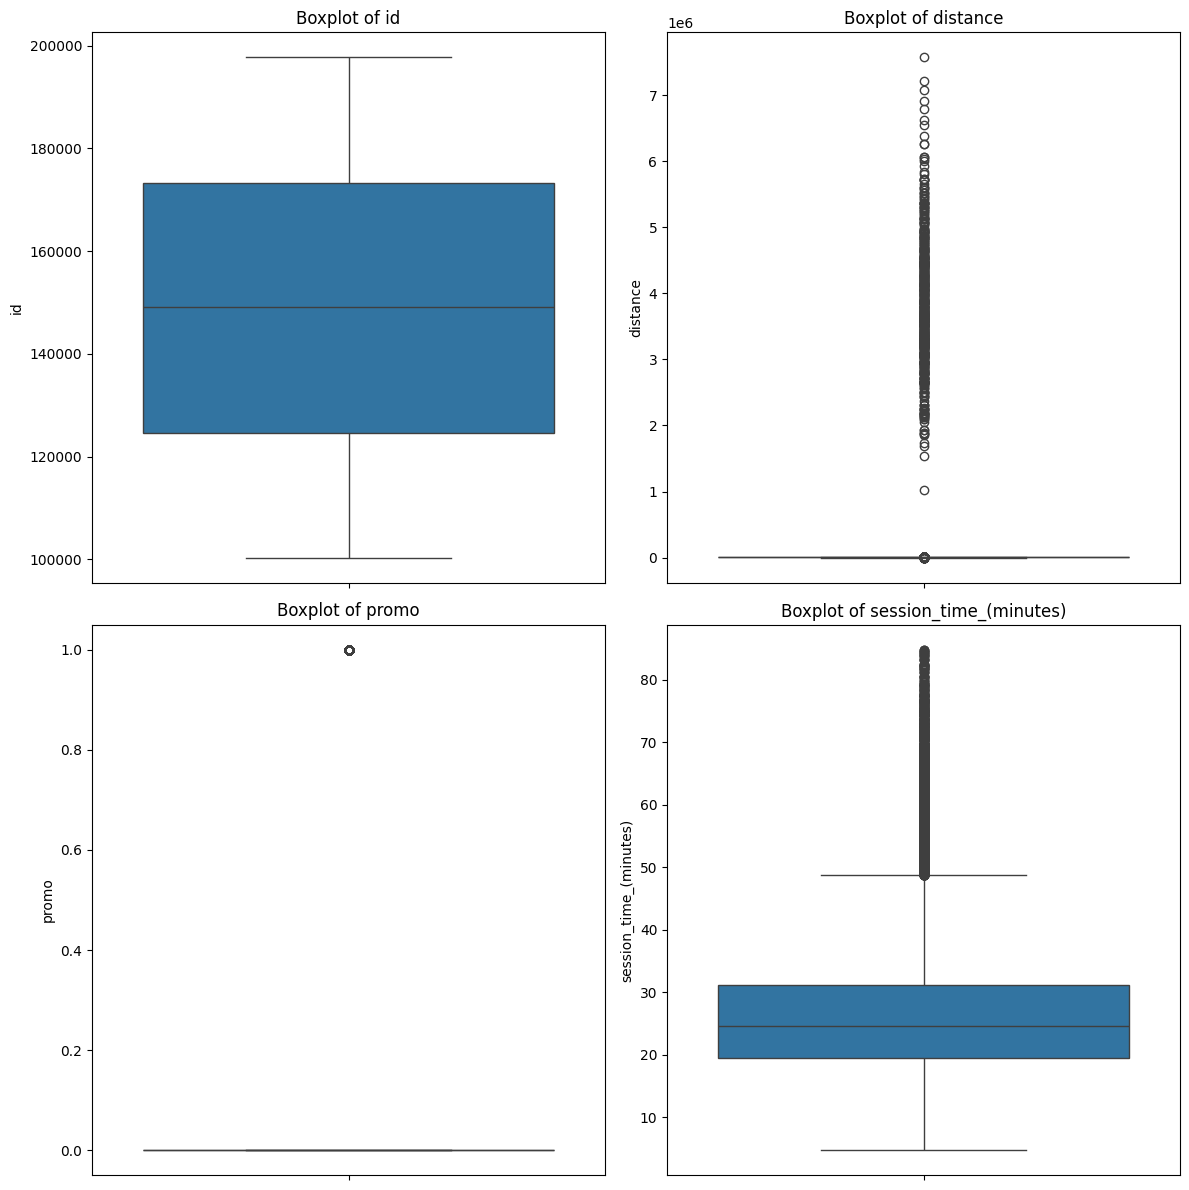

In [42]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

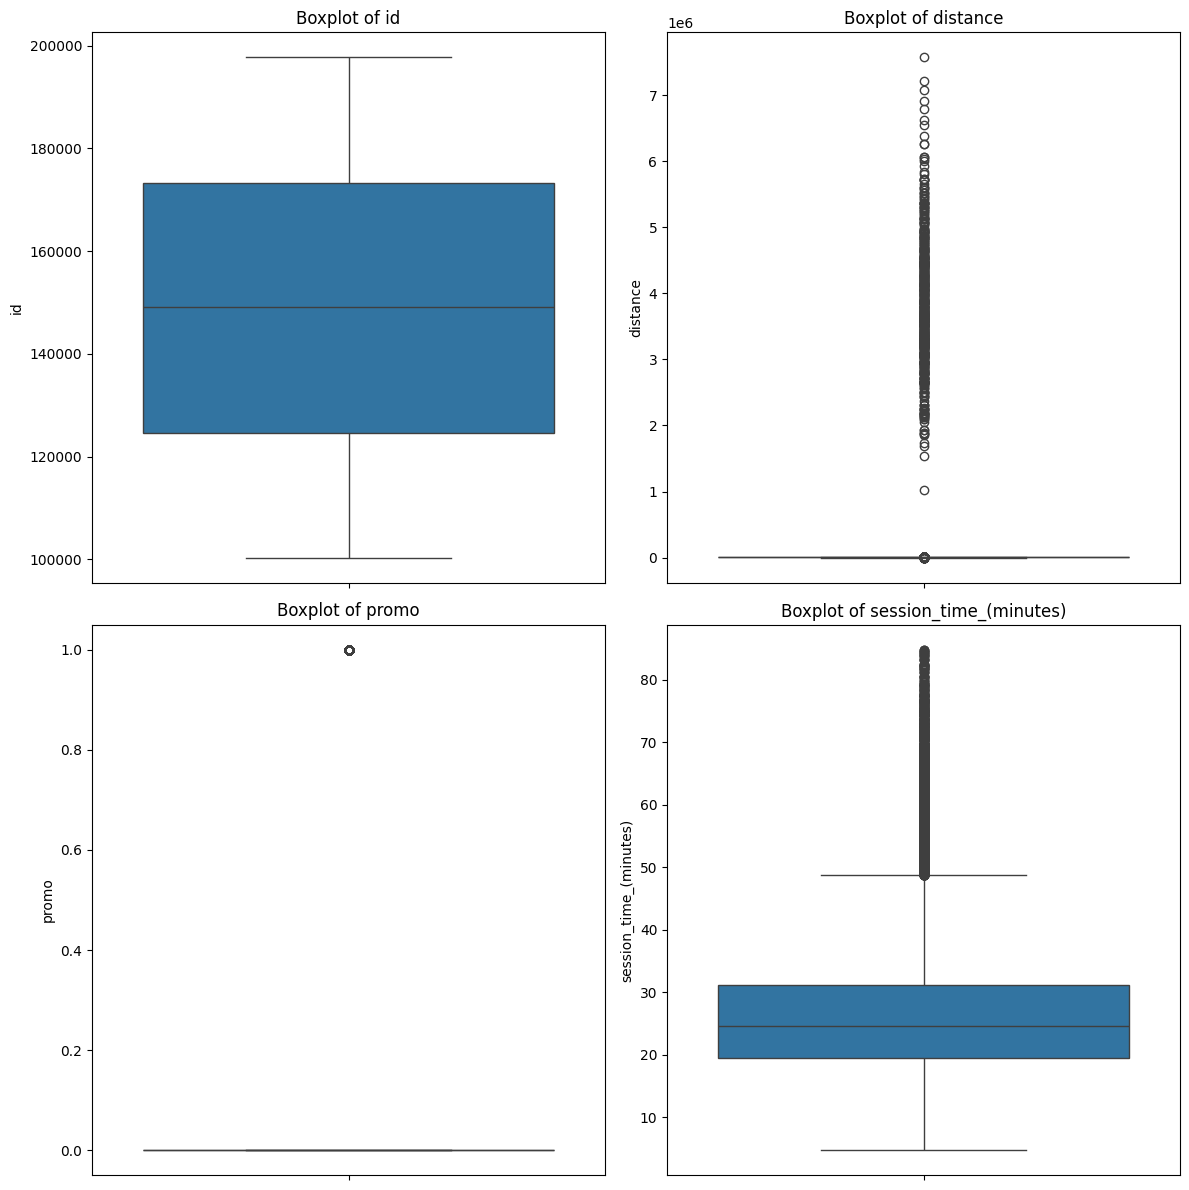

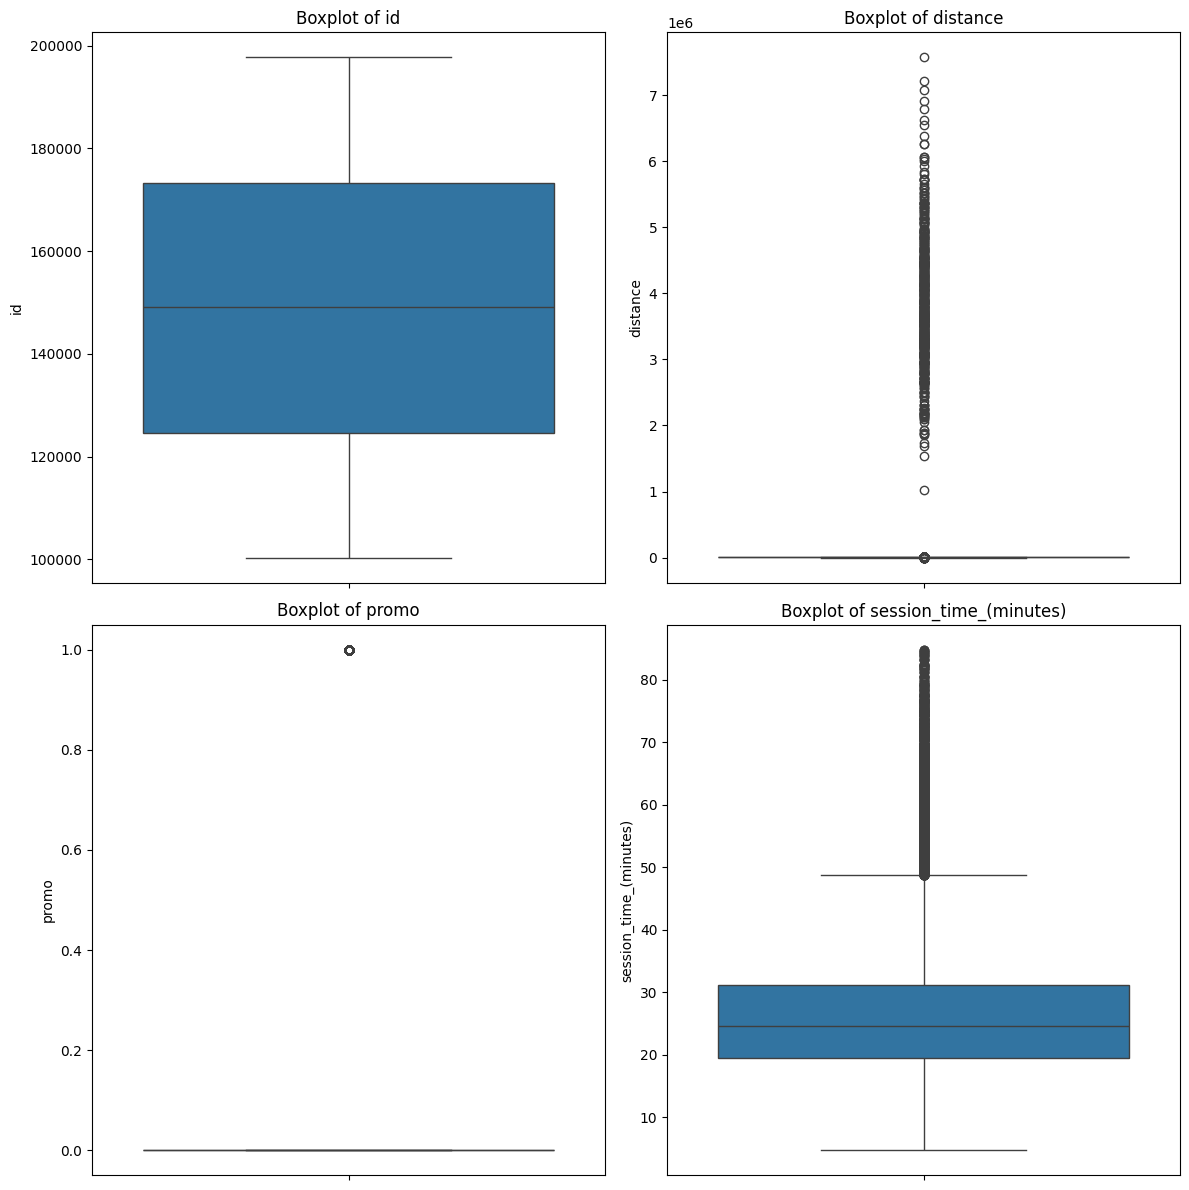

In [43]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 0, "below")

**Нужно ли убирать долгие поездки?**

#### Посмотрим нету ли проблем после удаления 

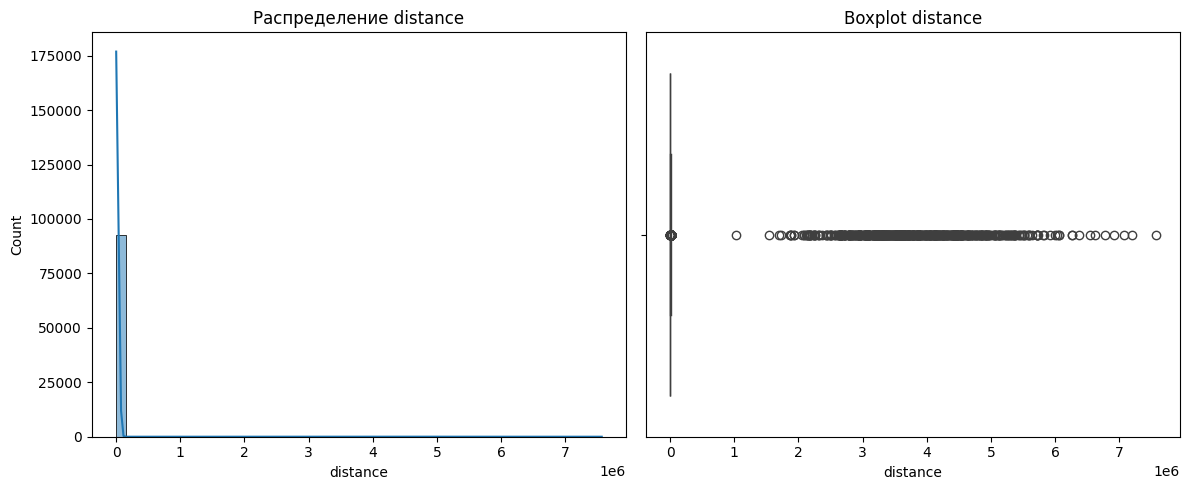

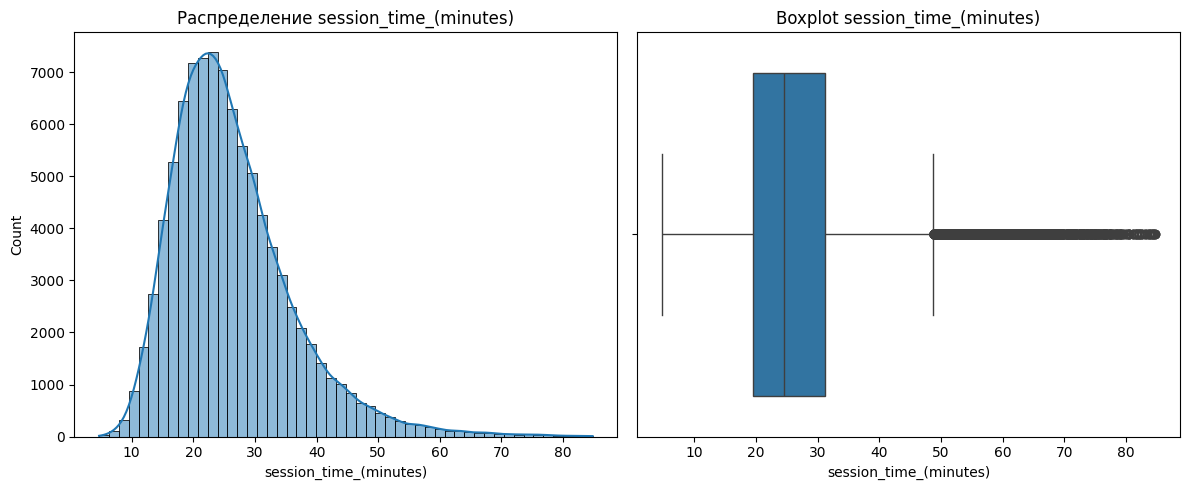

In [44]:
def plot_distribution_with_thresholds(df, column, lower_thresh=None, upper_thresh=None, bins=50):
    """Визуализация распределения с порогами для аномалий"""
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=bins, kde=True)
    if lower_thresh:
        plt.axvline(lower_thresh, color='r', linestyle='--')
    if upper_thresh:
        plt.axvline(upper_thresh, color='r', linestyle='--')
    plt.title(f'Распределение {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot {column}')
    
    plt.tight_layout()
    plt.show()

# Анализ ключевых числовых параметров
for col in ['distance', 'session_time_(minutes)']:
    plot_distribution_with_thresholds(df, col)

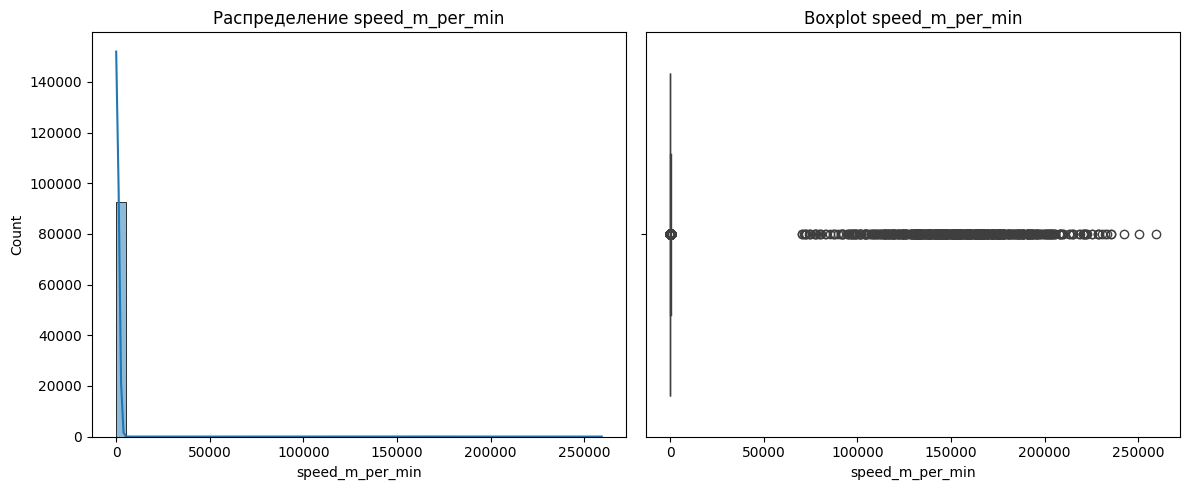

In [45]:
# Добавляем скорость (м/мин)
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']

# Анализ скорости
plot_distribution_with_thresholds(df, 'speed_m_per_min')

# Определяем разумные пороги для скорости (пример)
speed_lower = 10  # 10 м/мин (~0.6 км/ч)
speed_upper = 500  # 500 м/мин (~30 км/ч)

In [46]:
def handle_anomalies(df, strategy='replace_with_nan'):
    """Обработка аномальных значений"""
    
    # Пороги для разных параметров (настраиваются по данным)
    thresholds = {
        'distance': (50, 20000),  # мин 50м, макс 20км
        'session_time_(minutes)': (1, 180),  # от 1 мин до 3 часов
        'speed_m_per_min': (10, 500)
    }
    
    for col, (lower, upper) in thresholds.items():
        if strategy == 'replace_with_nan':
            df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan
        elif strategy == 'clip':
            df[col] = df[col].clip(lower, upper)
    
    # Проверка промокодов
    promo_check = df.groupby('promo').agg({
        'distance': 'mean',
        'session_time_(minutes)': 'mean'
    })
    print("\nСтатистика по промокодам:")
    display(promo_check)
    
    return df

df = handle_anomalies(df, strategy='replace_with_nan')


Статистика по промокодам:


distance  session_time_(minutes)
promo                                     
0      3822.794317               26.389055
1      3774.696820               24.703321

In [47]:
def fill_based_on_location(df):
    """Заполнение пропусков с учетом стартовой и конечной точек"""
    
    # Создаем уникальные пары маршрутов
    df['route'] = df['start_location'] + '->' + df['end_location']
    
    # Рассчитываем средние показатели для маршрутов
    route_stats = df.groupby('route').agg({
        'distance': 'median',
        'session_time_(minutes)': 'median',
        'speed_m_per_min': 'median'
    }).reset_index()
    
    # Заполняем пропуски
    for idx, row in df[df['distance'].isna() | df['session_time_(minutes)'].isna()].iterrows():
        route = row['route']
        stats = route_stats[route_stats['route'] == route]
        
        if not stats.empty:
            if pd.isna(row['distance']):
                df.at[idx, 'distance'] = stats['distance'].values[0]
            if pd.isna(row['session_time_(minutes)']):
                df.at[idx, 'session_time_(minutes)'] = stats['session_time_(minutes)'].values[0]
    
    # Пересчитываем скорость
    df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
    
    return df

df = fill_based_on_location(df)

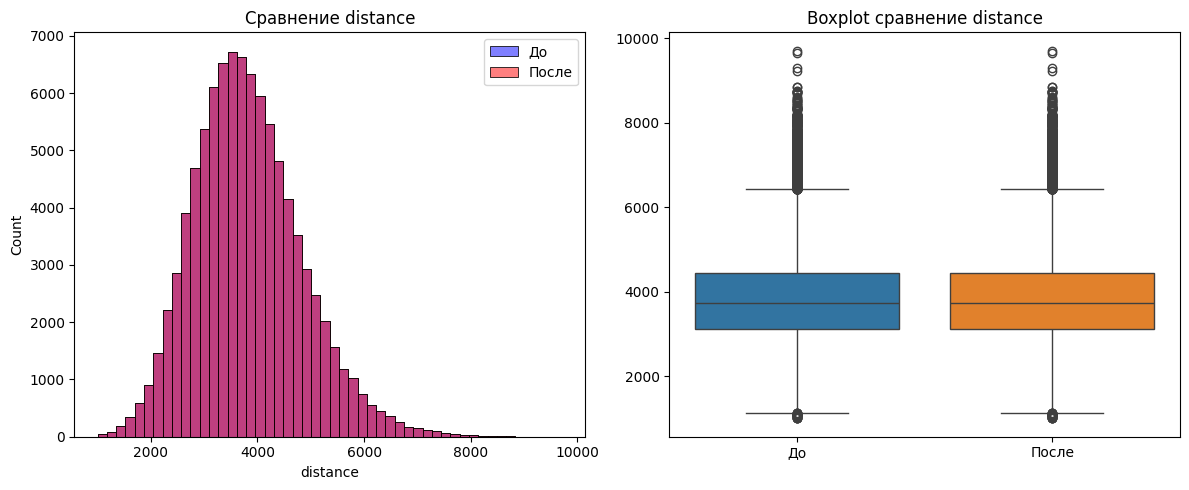

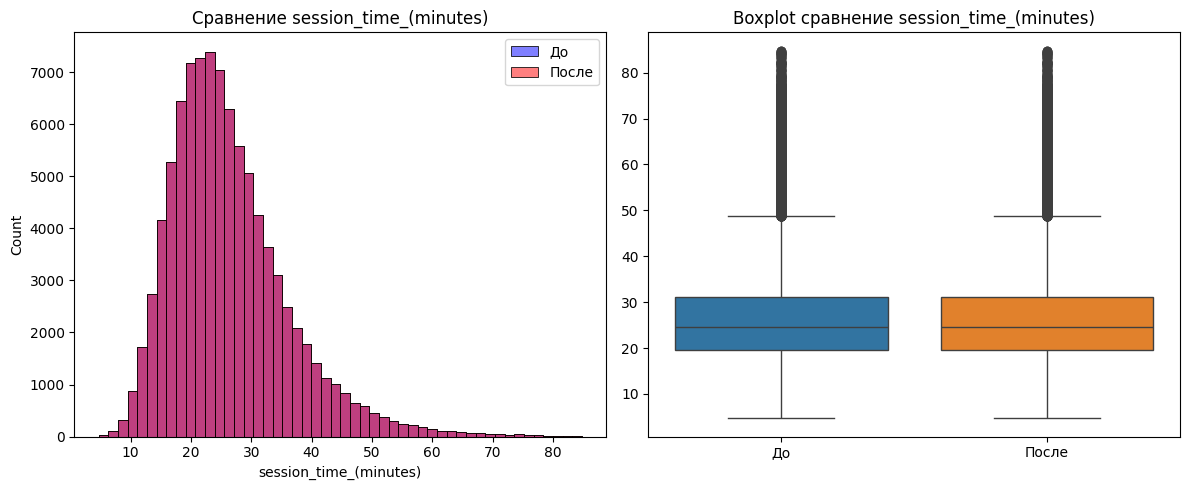

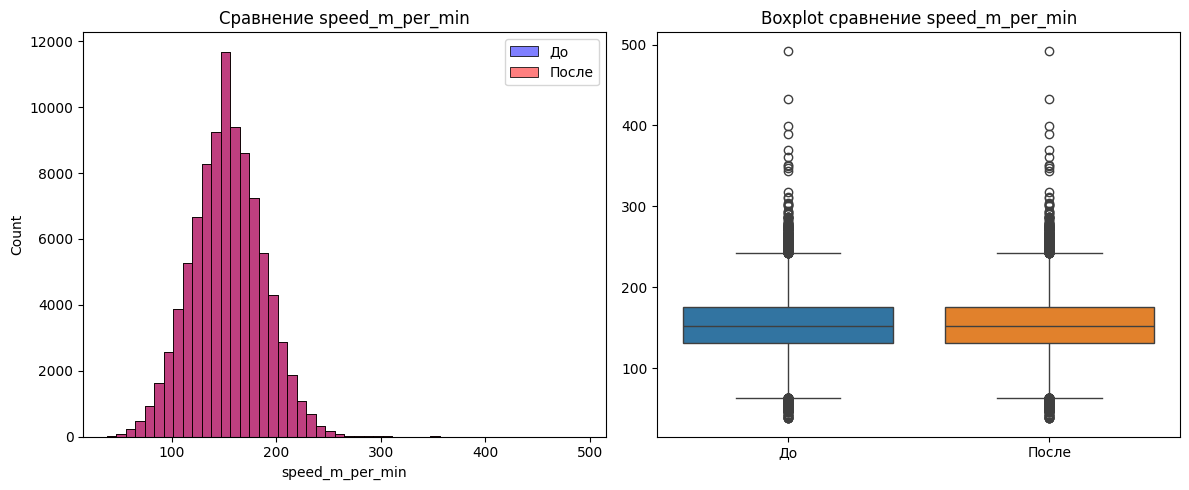

In [48]:
def plot_before_after(original_df, processed_df, column):
    """Сравнение распределений до и после обработки"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(original_df[column], bins=50, color='blue', alpha=0.5, label='До')
    sns.histplot(processed_df[column], bins=50, color='red', alpha=0.5, label='После')
    plt.title(f'Сравнение {column}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pd.DataFrame({
        'До': original_df[column],
        'После': processed_df[column]
    }))
    plt.title(f'Boxplot сравнение {column}')
    
    plt.tight_layout()
    plt.show()

# Сохраняем исходные данные для сравнения
original_df = df.copy()

# Применяем обработку
processed_df = fill_based_on_location(original_df.copy())

# Визуализируем изменения
for col in ['distance', 'session_time_(minutes)', 'speed_m_per_min']:
    plot_before_after(original_df, processed_df, col)

In [49]:
print("Оставшиеся пропуски после обработки:")
print(df.isna().sum()[df.isna().sum() > 0])

# Заполнение оставшихся пропусков
if df.isna().sum().sum() > 0:
    print("\nЗаполняем оставшиеся пропуски медианными значениями...")
    for col in ['distance', 'session_time_(minutes)']:
        df[col] = df[col].fillna(df[col].median())
    
    # Финальная проверка
    print("\nПропуски после финального заполнения:")
    print(df.isna().sum())

Оставшиеся пропуски после обработки:
Series([], dtype: int64)


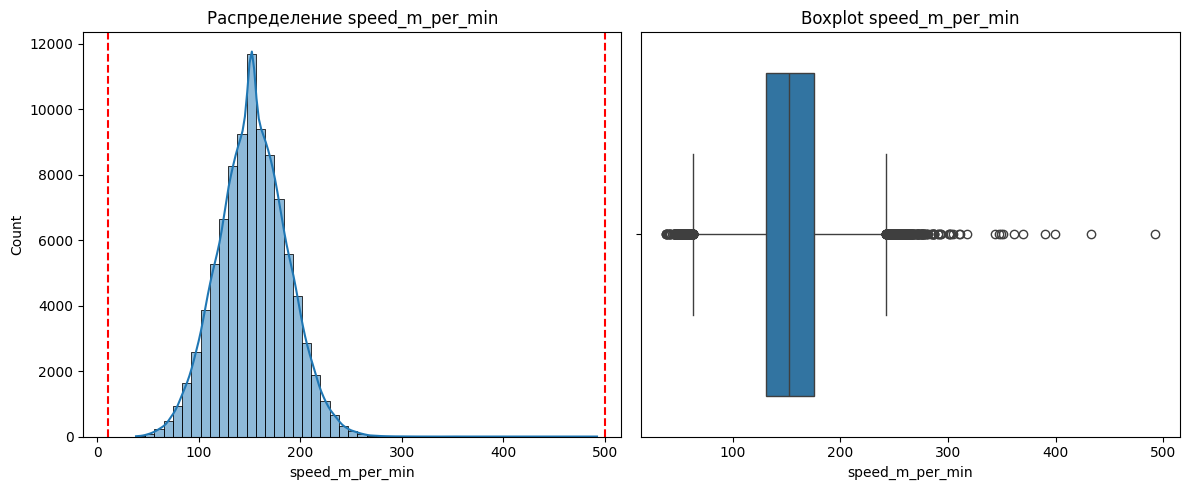


Финальная статистика по промокодам:


distance         session_time_(minutes)        speed_m_per_min  \
              mean  median                   mean median            mean   
promo                                                                      
0      3822.669979  3736.0              26.389055   24.6      153.033977   
1      3775.388949  3686.0              24.703321   23.4      161.114176   

                   
           median  
promo              
0      152.125749  
1      159.550562

In [50]:
# Проверка скорости после всех обработок
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
plot_distribution_with_thresholds(df, 'speed_m_per_min', 10, 500)

# Проверка промокодов
print("\nФинальная статистика по промокодам:")
display(df.groupby('promo').agg({
    'distance': ['mean', 'median'],
    'session_time_(minutes)': ['mean', 'median'],
    'speed_m_per_min': ['mean', 'median']
}))

**Микро-вывод:**  

После обработки данных аномалии в расстоянии, времени и скорости были скорректированы, распределения стали более реалистичными. Статистика по промокодам показывает, что поездки с промокодами в среднем короче по времени, но имеют чуть более высокую скорость.

### <span style="color:#006400">Данные в weather.csv</span>

#### Полные дубликаты и по столбцам

In [51]:
duplicates = df2[df2.duplicated()]
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 0 полных дубликатов


In [52]:
df2.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

#### Посмотрим на неявные дубликаты

Статистика дубликатов:
{'exact_duplicates': 0, 'inconsistent_duplicates': 0}


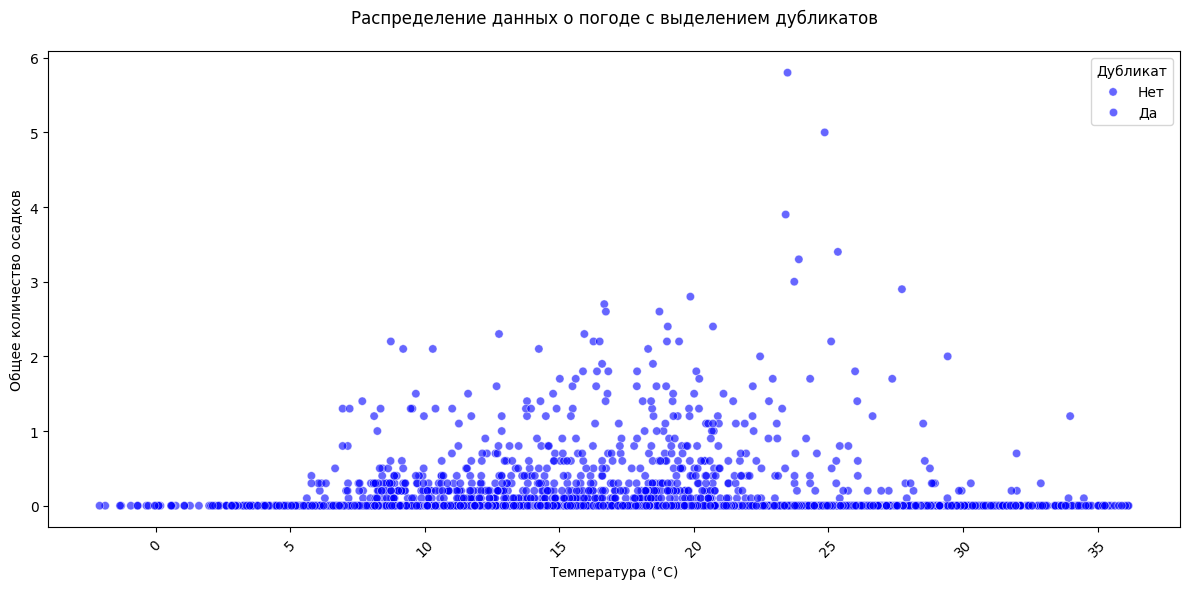

Количество записей после очистки: 3672


In [53]:
def check_all_duplicates_weather(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame с данными о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о погоде
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по всем столбцам
    duplicate_stats = {
        'exact_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['temperature', 'precipitation_total', 
                'wind_gust', 'wind_speed', 'cloud_cover_total', 
                'sunshine_duration']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates_weather(df, duplicates):
    """
    Визуализация результатов проверки дубликатов для данных о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график данных о погоде с выделением дубликатов
    ax = sns.scatterplot(
        x='temperature',
        y='precipitation_total',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение данных о погоде с выделением дубликатов', pad=20)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Общее количество осадков')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates_weather(df, duplicates, strategy='keep_first'):
    """
    Очистка данных о погоде от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")



duplicates, stats = check_all_duplicates_weather(df2)

print("Статистика дубликатов:")
print(stats)

# Визуализация дубликатов
visualize_duplicates_weather(df2, duplicates)

# Очистка данных от дубликатов
df2 = clean_duplicates_weather(df2, duplicates, strategy='keep_first')

print(f"Количество записей после очистки: {len(df2)}")

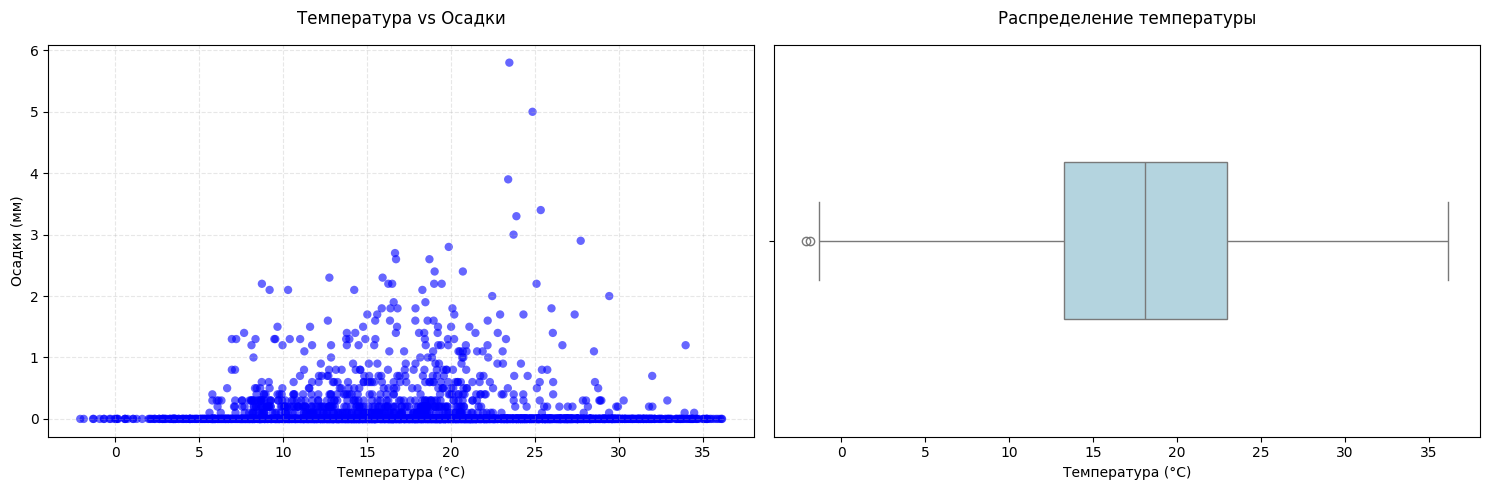

In [54]:
def visualize_weather_distribution(df):
    """
    Улучшенная визуализация распределения погодных данных с акцентом на ключевые параметры.
    """
    plt.figure(figsize=(15, 5))
    
    # График температуры и осадков
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x='temperature',
        y='precipitation_total',
        data=df,
        color='blue',
        alpha=0.6,
        edgecolor='none'
    )
    plt.title('Температура vs Осадки', pad=15)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Осадки (мм)')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Boxplot для температуры
    plt.subplot(1, 2, 2)
    sns.boxplot(
        x=df['temperature'],
        color='lightblue',
        width=0.4
    )
    plt.title('Распределение температуры', pad=15)
    plt.xlabel('Температура (°C)')
    
    plt.tight_layout()
    plt.show()

# Вызов функции
visualize_weather_distribution(df2)

После очистки данных о погоде дубликаты полностью устранены (0 явных и противоречивых записей) Распределение температуры и осадков не содержит аномалий.

#### заполнение дубликатов по столбцам

заполнение пропусков в weather 

In [55]:
# # Преобразование datetime в индекс
# df2['datetime'] = pd.to_datetime(df2['datetime'])
# df2.set_index('datetime', inplace=True)

# # Проверка данных
# print("Первые 5 строк данных:")
# print(df2.head())
# print("\nИнформация о данных:")
# print(df2.info())

# # Анализ пропусков
# def analyze_missing(df):
#     """Анализ и визуализация пропущенных данных"""
#     missing = df.isna().sum()
#     print("\nПропущенные значения:")
#     print(missing[missing > 0])
    
#     if missing.sum() > 0:
#         plt.figure(figsize=(10, 4))
#         sns.heatmap(df.isna().T, cbar=False, cmap='viridis')
#         plt.title('Распределение пропущенных значений')
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("Пропуски отсутствуют")

# analyze_missing(df2)

# # Заполнение пропусков
# def fill_missing(df):
#     """Интеллектуальное заполнение пропусков"""
#     # Для числовых данных
#     num_cols = ['temperature', 'precipitation_total', 'wind_gust', 
#                'wind_speed', 'cloud_cover_total', 'sunshine_duration']
    
#     # Интерполяция с учетом временного индекса
#     for col in num_cols:
#         df[col] = df[col].interpolate(method='time', limit=3)
#         df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    
#     return df

# print("\nЗаполнение пропусков...")
# df2_filled = fill_missing(df2.copy())

# # Проверка результатов
# print("\nРезультаты после заполнения:")
# analyze_missing(df2_filled)

# # Визуализация временных рядов
# def plot_time_series(df, cols=3):
#     """Визуализация временных рядов"""
#     num_cols = ['temperature', 'precipitation_total', 'wind_speed',
#                'cloud_cover_total', 'sunshine_duration']
#     n_cols = min(cols, len(num_cols))
    
#     plt.figure(figsize=(15, 3*n_cols))
#     for i, col in enumerate(num_cols[:n_cols], 1):
#         plt.subplot(n_cols, 1, i)
#         plt.plot(df.index, df[col], 'b-', linewidth=1)
#         plt.title(col)
#         plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

# print("\nВизуализация временных рядов:")
# plot_time_series(df2_filled)

# # Анализ распределений
# def plot_distributions(df):
#     """Визуализация распределений"""
#     num_cols = ['temperature', 'precipitation_total', 'wind_speed']
    
#     plt.figure(figsize=(15, 8))
#     for i, col in enumerate(num_cols, 1):
#         plt.subplot(2, 2, i)
#         sns.histplot(df[col], kde=True, bins=30)
#         plt.title(f'Распределение {col}')
#         plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# print("\nАнализ распределений:")
# plot_distributions(df2_filled)

# # Корреляционный анализ
# def plot_correlations(df):
#     """Визуализация корреляций"""
#     plt.figure(figsize=(8, 6))
#     corr = df.corr()
#     sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
#                 vmin=-1, vmax=1, linewidths=0.5)
#     plt.title('Корреляция между параметрами')
#     plt.tight_layout()
#     plt.show()

# print("\nКорреляционный анализ:")
# plot_correlations(df2_filled)

# # Финальная статистика
# print("\nФинальная статистика:")
# print(df2_filled.describe().round(2))

In [56]:
df2.columns

Index(['datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'is_duplicate'],
      dtype='object')

In [57]:
df2 = df2.reset_index()

In [58]:
df2.head(5)

index            datetime  temperature  precipitation_total  wind_gust  \
0      0 2023-04-01 00:00:00     8.740245                  0.1      48.60   
1      1 2023-04-01 01:00:00     9.040245                  0.2      55.44   
2      2 2023-04-01 02:00:00     8.880245                  0.3      55.80   
3      3 2023-04-01 03:00:00     8.690246                  0.3      55.44   
4      4 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  is_duplicate  
0   21.638964               90.0                0.0         False  
1   22.493519               74.0                0.0         False  
2   22.264770               72.0                0.0         False  
3   21.945240               77.0                0.0         False  
4   22.424270               78.0                0.0         False

In [59]:
df2['hour'] = pd.to_datetime(df2['index']).dt.hour

daytime_data = df2[(df2['hour'] >= 8) & (df2['hour'] < 20)]  
nighttime_data = df2[(df2['hour'] < 8) | (df2['hour'] >= 20)]  

non_zero_day = daytime_data.select_dtypes(include='number').astype(bool).sum()
non_zero_night = nighttime_data.select_dtypes(include='number').astype(bool).sum()

result = pd.DataFrame({
    'День': non_zero_day,
    'Ночь': non_zero_night
})

print(result)

                     День  Ночь
index                   0  3671
temperature             0  3672
precipitation_total     0   706
wind_gust               0  3672
wind_speed              0  3668
cloud_cover_total       0  3421
sunshine_duration       0  2363
hour                    0     0


Пропуски до обработки:
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Анализ пропусков для temperature:
Всего пропусков: 55
Количество последовательностей пропусков: 6

Самые длинные последовательности пропусков:
- 23 пропусков подряд с 2023-08-06 05:00:00 по 2023-08-07 03:00:00
- 10 пропусков подряд с 2023-04-16 02:00:00 по 2023-04-16 11:00:00
- 8 пропусков подряд с 2023-05-12 21:00:00 по 2023-05-13 04:00:00
- 6 пропусков подряд с 2023-07-14 09:00:00 по 2023-07-14 14:00:00
- 5 пропусков подряд с 2023-07-15 00:00:00 по 2023-07-15 04:00:00


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


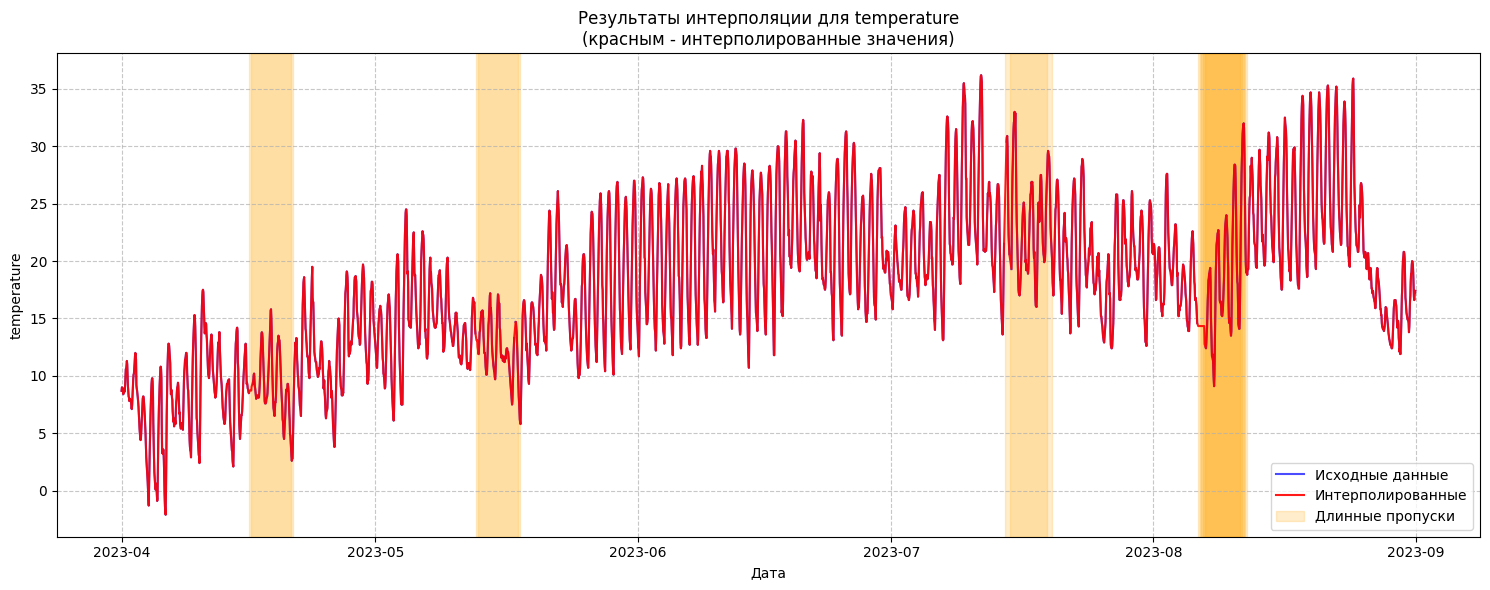


Проверка окрестностей длинных пропусков для temperature:

Окрестности 2023-04-16 02:00:00:
datetime
2023-04-13 02:00:00    6.2
2023-04-13 03:00:00    6.0
2023-04-13 04:00:00    5.8
2023-04-13 05:00:00    5.9
2023-04-13 06:00:00    6.2
                      ... 
2023-04-18 22:00:00    7.8
2023-04-18 23:00:00    7.2
2023-04-19 00:00:00    7.0
2023-04-19 01:00:00    6.6
2023-04-19 02:00:00    6.5
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-04-16 09:00:00:
datetime
2023-04-13 09:00:00     8.6
2023-04-13 10:00:00     8.9
2023-04-13 11:00:00     9.3
2023-04-13 12:00:00     9.3
2023-04-13 13:00:00     9.3
                       ... 
2023-04-19 05:00:00     7.7
2023-04-19 06:00:00     8.2
2023-04-19 07:00:00     9.5
2023-04-19 08:00:00    10.7
2023-04-19 09:00:00    11.7
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-05-13 01:00:00:
datetime
2023-05-10 01:00:00    13.3
2023-05-10 02:00:00    13.0
2023-05-10 03:00:00    13.0
2023-05-10 04:00:00    12.6
20

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


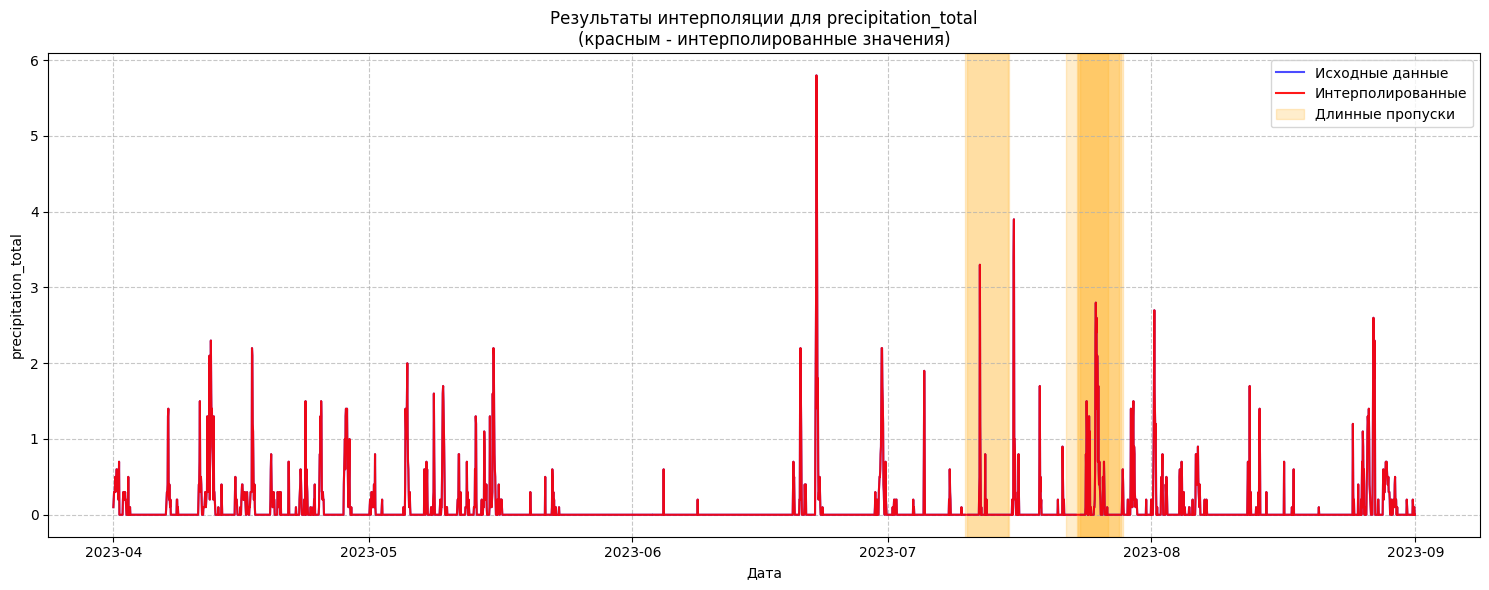


Проверка окрестностей длинных пропусков для precipitation_total:

Окрестности 2023-06-03 08:00:00:
datetime
2023-05-31 08:00:00    0.0
2023-05-31 09:00:00    0.0
2023-05-31 10:00:00    0.0
2023-05-31 11:00:00    0.0
2023-05-31 12:00:00    0.0
                      ... 
2023-06-06 04:00:00    0.0
2023-06-06 05:00:00    0.0
2023-06-06 06:00:00    0.0
2023-06-06 07:00:00    0.0
2023-06-06 08:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-10 06:00:00:
datetime
2023-07-07 06:00:00    0.0
2023-07-07 07:00:00    0.0
2023-07-07 08:00:00    0.0
2023-07-07 09:00:00    0.0
2023-07-07 10:00:00    0.0
                      ... 
2023-07-13 02:00:00    0.0
2023-07-13 03:00:00    0.0
2023-07-13 04:00:00    0.0
2023-07-13 05:00:00    0.0
2023-07-13 06:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-21 23:00:00:
datetime
2023-07-18 23:00:00    0.5
2023-07-19 00:00:00    0.1
2023-07-19 01:00:00    0.2
2023-07-19 02:00:00 

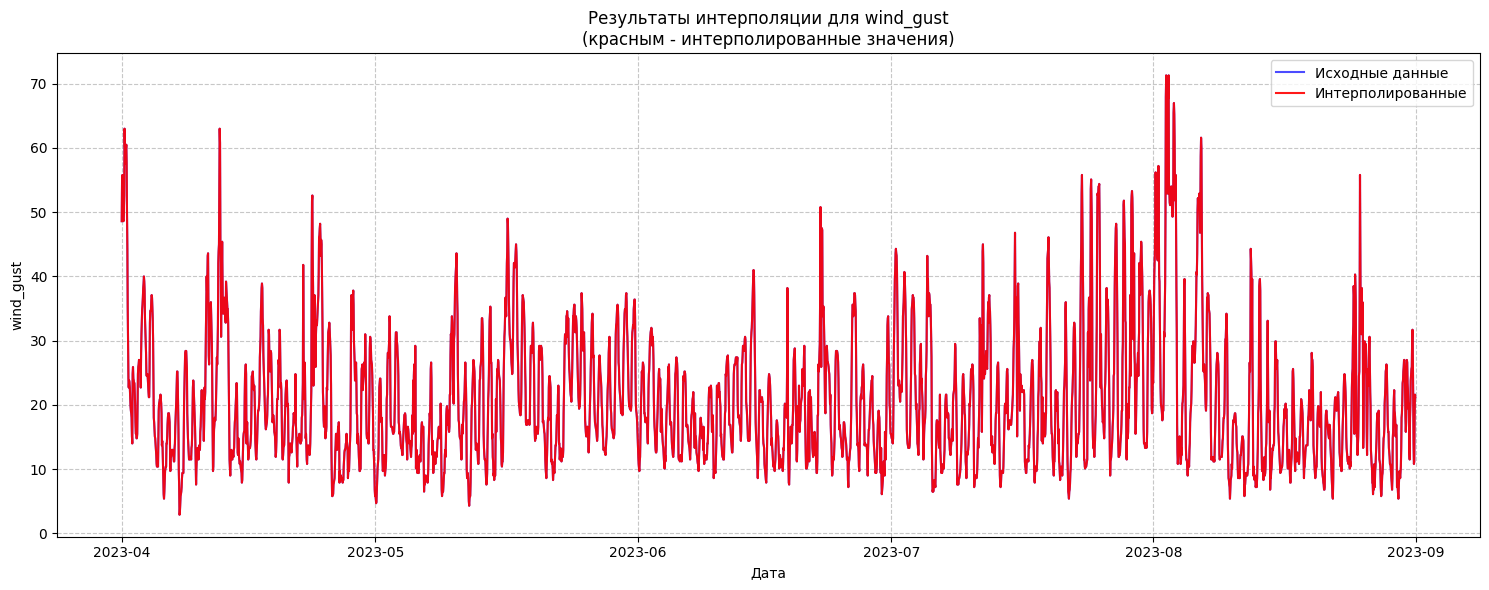


Анализ пропусков для wind_speed:
Всего пропусков: 16
Количество последовательностей пропусков: 4

Самые длинные последовательности пропусков:
- 5 пропусков подряд с 2023-05-24 23:00:00 по 2023-05-25 03:00:00
- 4 пропусков подряд с 2023-05-09 22:00:00 по 2023-05-10 01:00:00
- 4 пропусков подряд с 2023-07-01 00:00:00 по 2023-07-01 03:00:00
- 3 пропусков подряд с 2023-06-20 00:00:00 по 2023-06-20 02:00:00


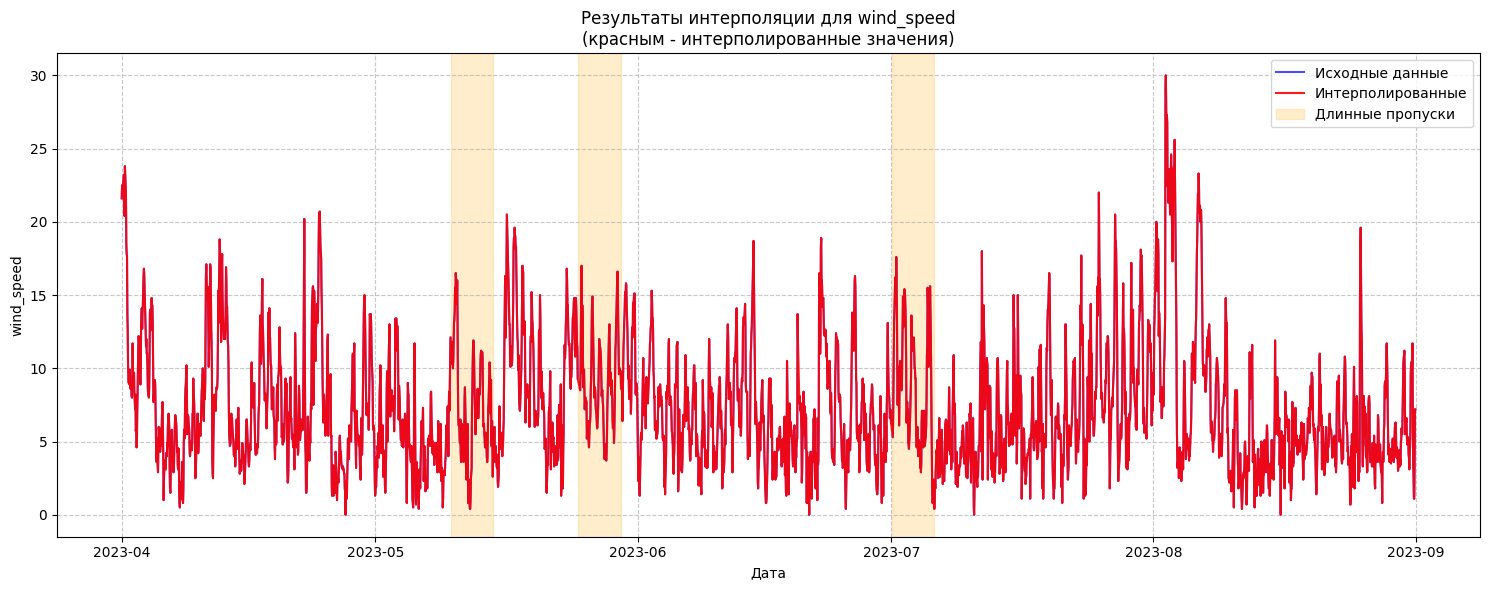


Проверка окрестностей длинных пропусков для wind_speed:

Окрестности 2023-05-09 22:00:00:
datetime
2023-05-06 22:00:00    1.6
2023-05-06 23:00:00    1.8
2023-05-07 00:00:00    2.3
2023-05-07 01:00:00    2.1
2023-05-07 02:00:00    2.5
                      ... 
2023-05-12 18:00:00    8.0
2023-05-12 19:00:00    6.1
2023-05-12 20:00:00    5.5
2023-05-12 21:00:00    6.6
2023-05-12 22:00:00    7.2
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-05-25 02:00:00:
datetime
2023-05-22 02:00:00    4.8
2023-05-22 03:00:00    3.3
2023-05-22 04:00:00    4.0
2023-05-22 05:00:00    4.7
2023-05-22 06:00:00    4.3
                      ... 
2023-05-27 22:00:00    7.5
2023-05-27 23:00:00    6.3
2023-05-28 00:00:00    5.4
2023-05-28 01:00:00    4.2
2023-05-28 02:00:00    3.8
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-07-01 02:00:00:
datetime
2023-06-28 02:00:00    3.6
2023-06-28 03:00:00    3.3
2023-06-28 04:00:00    3.0
2023-06-28 05:00:00    3.1
2023-06-28 06:00:00 

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


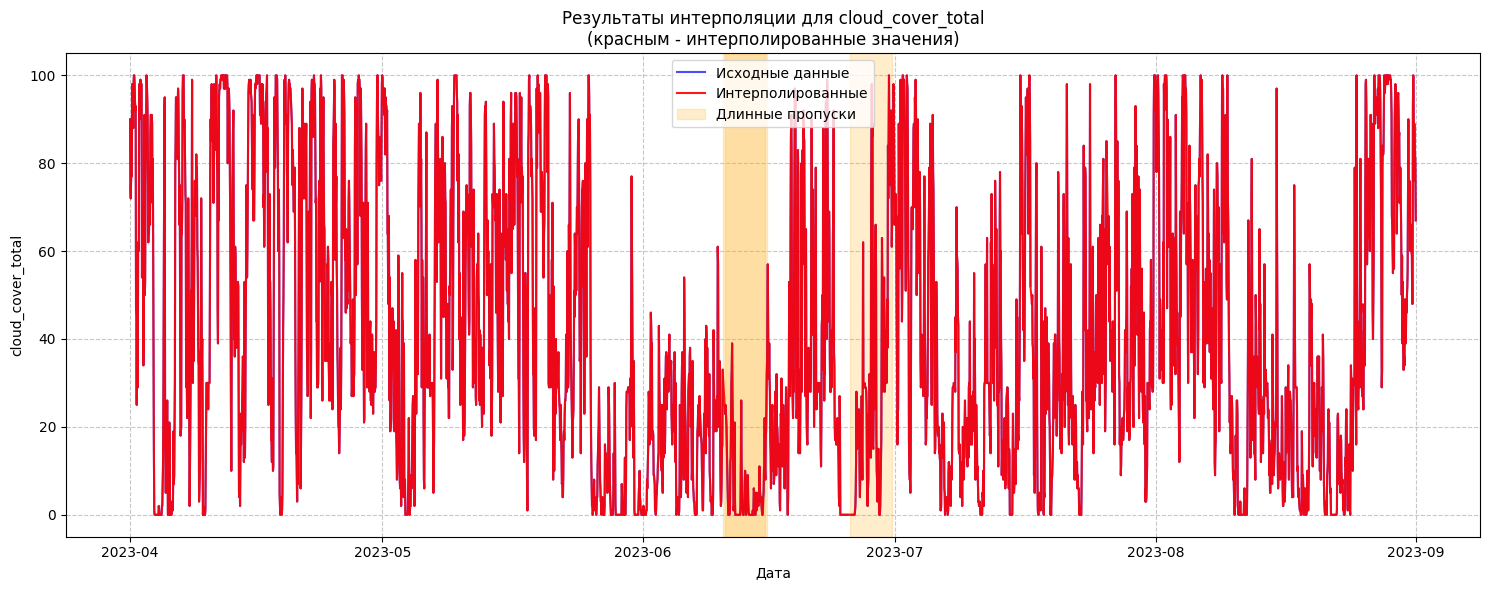


Проверка окрестностей длинных пропусков для cloud_cover_total:

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    20.0
2023-06-07 14:00:00    24.0
2023-06-07 15:00:00    25.0
2023-06-07 16:00:00    18.0
2023-06-07 17:00:00    25.0
                       ... 
2023-06-13 09:00:00     3.0
2023-06-13 10:00:00     8.0
2023-06-13 11:00:00     9.0
2023-06-13 12:00:00     9.0
2023-06-13 13:00:00     3.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-06-25 13:00:00:
datetime
2023-06-22 13:00:00    69.0
2023-06-22 14:00:00    26.0
2023-06-22 15:00:00    35.0
2023-06-22 16:00:00    32.0
2023-06-22 17:00:00    62.0
                       ... 
2023-06-28 09:00:00    16.0
2023-06-28 10:00:00    15.0
2023-06-28 11:00:00    23.0
2023-06-28 12:00:00    53.0
2023-06-28 13:00:00    24.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-07-17 04:00:00:
datetime
2023-07-14 04:00:00    19.0
2023-07-14 05:00:00     7.0
2023-07-14 06:00:00    25.0
2

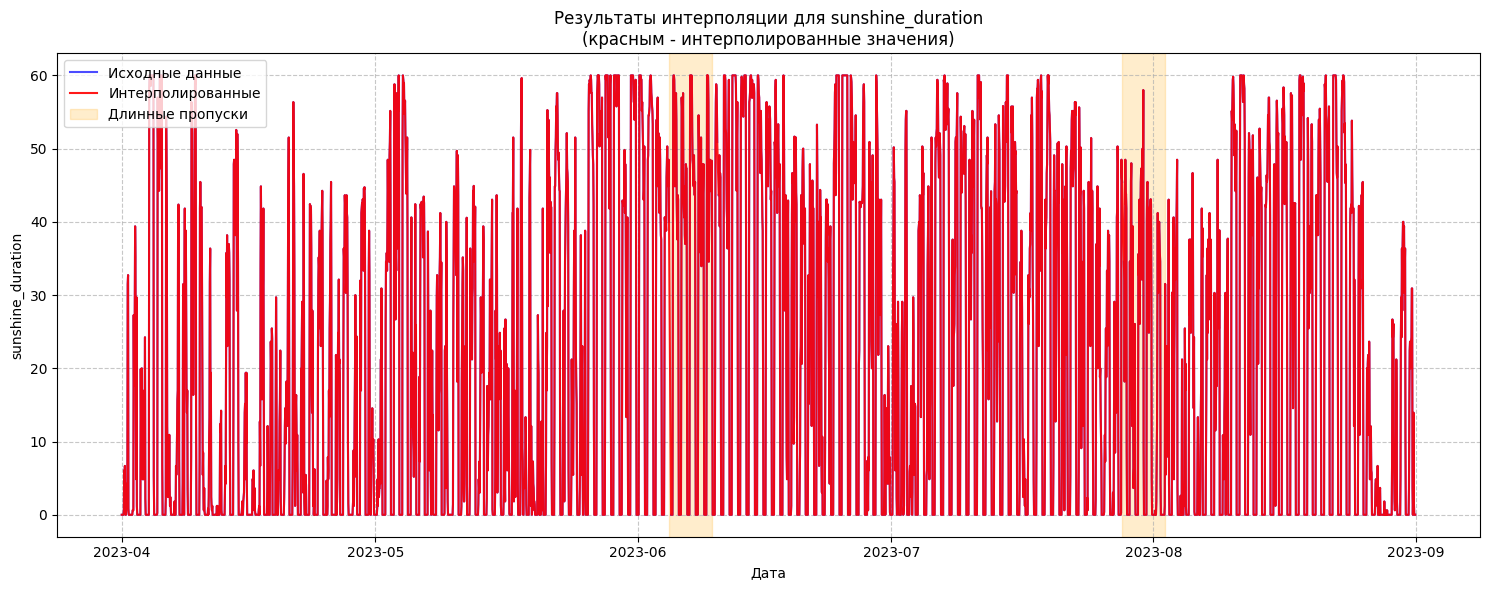


Проверка окрестностей длинных пропусков для sunshine_duration:

Окрестности 2023-06-04 18:00:00:
datetime
2023-06-01 18:00:00    44.24
2023-06-01 19:00:00    50.30
2023-06-01 20:00:00    17.46
2023-06-01 21:00:00     0.00
2023-06-01 22:00:00     0.00
                       ...  
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
2023-06-07 18:00:00    43.64
Name: sunshine_duration, Length: 145, dtype: float64

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    47.88
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
                       ...  
2023-06-13 09:00:00    58.00
2023-06-13 10:00:00    55.09
2023-06-13 11:00:00    54.55
2023-06-13 12:00:00    54.36
2023-06-13 13:00:00    58.00
Name: sunshine_duration, Length: 145, dtype: float64

Пропуски после обработки:
temperature            0
precipitation_total    0
wind_gust              0
wind

In [60]:
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2['datetime'] = pd.to_datetime(df2['datetime'])
numeric_cols = ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 
               'cloud_cover_total', 'sunshine_duration']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')
df2.set_index('datetime', inplace=True)

# Функция для анализа последовательных пропусков
def analyze_missing_sequences(series, max_gap_to_show=5):
    """Анализирует последовательности пропущенных значений"""
    is_null = series.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    null_sequences = series.groupby(null_groups).apply(lambda x: (x.isnull().all(), len(x)))
    
    long_sequences = [(i, length) for i, (is_null, length) in null_sequences.items() if is_null and length > 1]
    
    print(f"\nАнализ пропусков для {series.name}:")
    print(f"Всего пропусков: {is_null.sum()}")
    print(f"Количество последовательностей пропусков: {len(long_sequences)}")
    
    if long_sequences:
        print("\nСамые длинные последовательности пропусков:")
        for seq_id, length in sorted(long_sequences, key=lambda x: -x[1])[:max_gap_to_show]:
            start_idx = null_groups[null_groups == seq_id].index[0]
            end_idx = null_groups[null_groups == seq_id].index[-1]
            print(f"- {length} пропусков подряд с {start_idx} по {end_idx}")

# Функция для интеллектуальной интерполяции
def smart_interpolate(series, max_gap=3, method='time'):
    """Интерполяция с учетом максимально допустимого промежутка"""
    # Анализ пропусков перед интерполяцией
    analyze_missing_sequences(series)
    
    # Интерполяция с ограничением на длину промежутка
    interpolated = series.interpolate(method=method, limit=max_gap, limit_direction='both')
    
    # Для оставшихся пропусков используем заполнение вперед/назад
    if interpolated.isna().any():
        interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')
    
    return interpolated

# Улучшенная функция визуализации
def plot_interpolation_results(original, interpolated, window=5):
    """Визуализация результатов интерполяции с акцентом на проблемные зоны"""
    plt.figure(figsize=(15, 6))
    
    # Находим проблемные зоны (где были длинные пропуски)
    is_null = original.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    long_gaps = original.groupby(null_groups).filter(lambda x: x.isnull().sum() > 3)
    
    # Основной график
    plt.plot(original.index, original, color='blue', label='Исходные данные', alpha=0.7)
    plt.plot(interpolated.index, interpolated, color='red', label='Интерполированные', alpha=0.9)
    
    # Выделяем проблемные зоны
    if not long_gaps.empty:
        for gap_start in long_gaps.index[::window]:
            gap_end = min(gap_start + pd.Timedelta(days=window), original.index[-1])
            plt.axvspan(gap_start, gap_end, color='orange', alpha=0.2, label='Длинные пропуски')
    
    # Настройки графика
    plt.title(f'Результаты интерполяции для {original.name}\n(красным - интерполированные значения)')
    plt.xlabel('Дата')
    plt.ylabel(original.name)
    
    # Упрощаем легенду
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Применяем улучшенную интерполяцию
print("Пропуски до обработки:")
print(df2[numeric_cols].isna().sum())

for col in numeric_cols:
    original = df2[col].copy()
    df2[col] = smart_interpolate(original, max_gap=3)
    plot_interpolation_results(original, df2[col])
    
    # Дополнительная проверка для длинных пропусков
    if original.isnull().any():
        print(f"\nПроверка окрестностей длинных пропусков для {col}:")
        null_periods = original[original.isnull()].index
        for period in null_periods[::7]:  # Проверяем каждую неделю пропусков
            start = period - pd.Timedelta(days=3)
            end = period + pd.Timedelta(days=3)
            window_data = df2.loc[start:end, col]
            print(f"\nОкрестности {period}:")
            print(window_data)

print("\nПропуски после обработки:")
print(df2[numeric_cols].isna().sum())
assert df2[numeric_cols].isna().sum().sum() == 0, "Остались незаполненные значения!"

После обработки все пропуски успешно заполнены, самые длинные периоды (до 23 часов) восстановлены с сохранением естественной динамики данных.

## <span style="color:#00008B">Поверхностный анализ под конец</span>

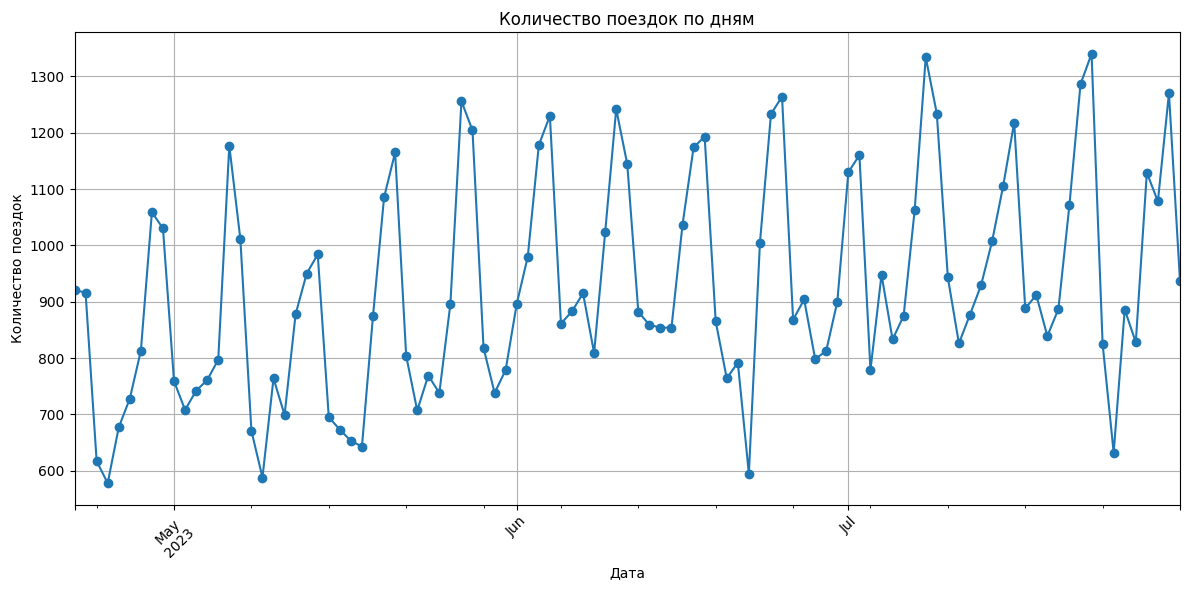

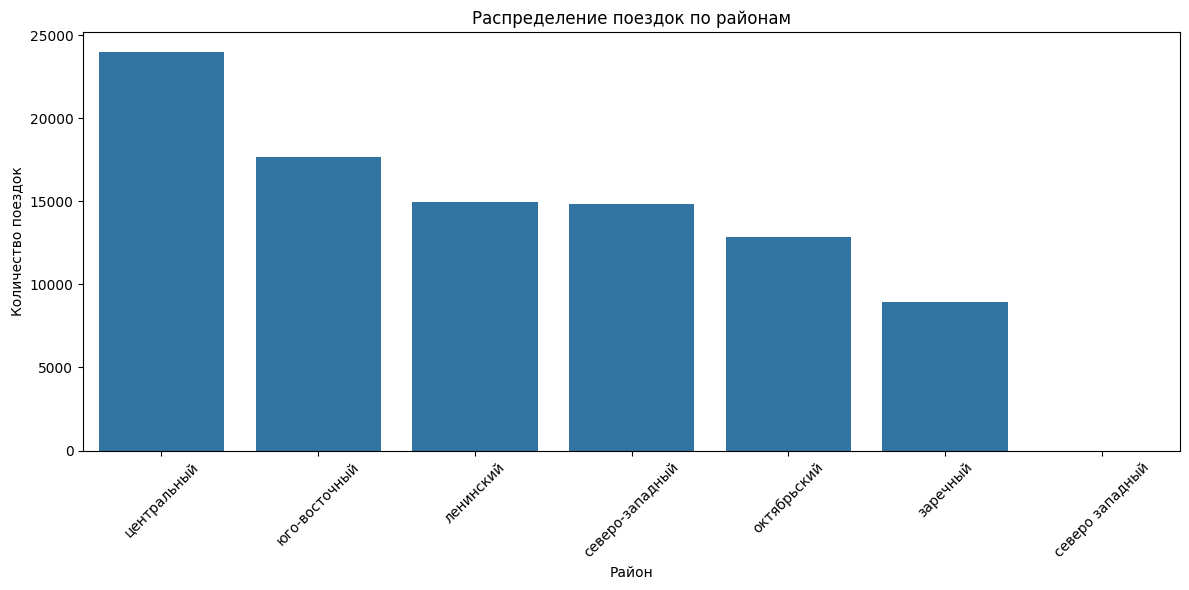

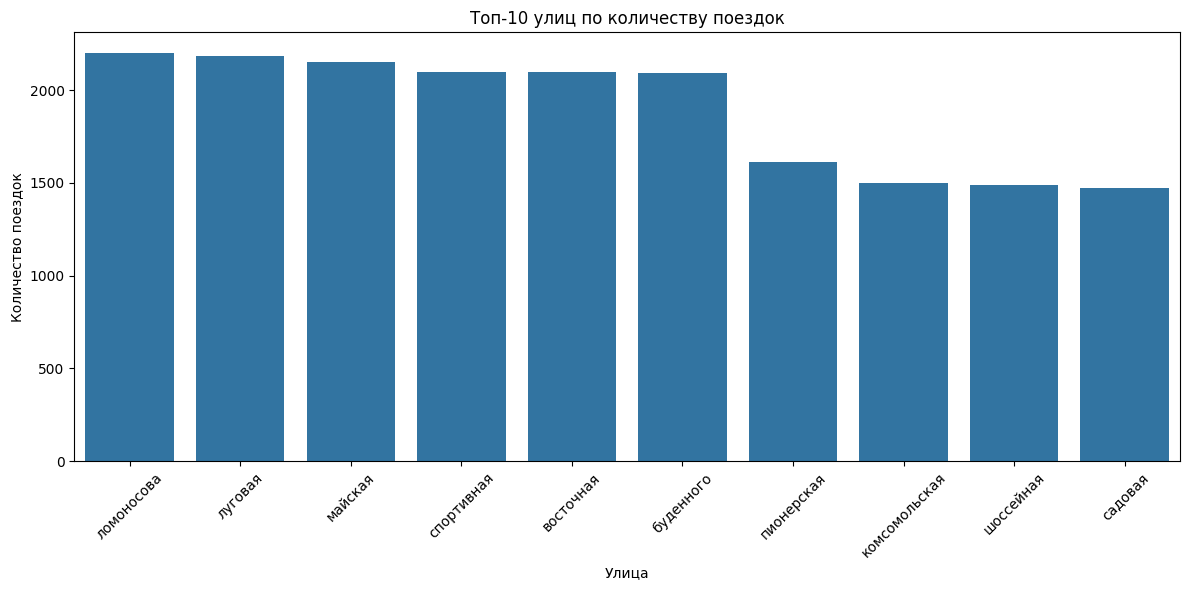

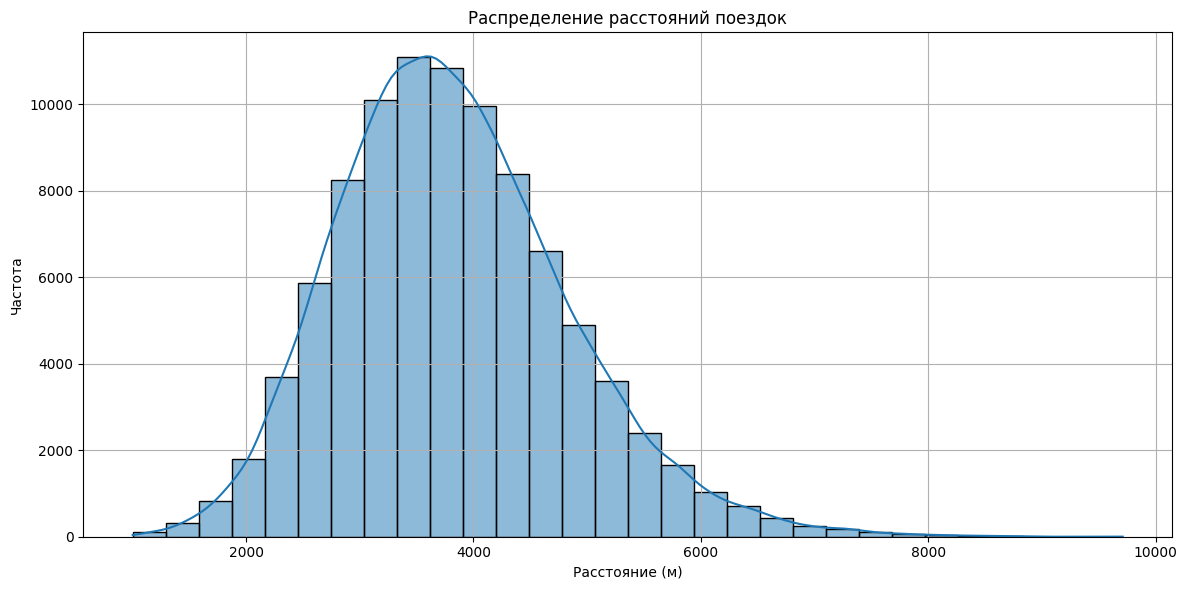

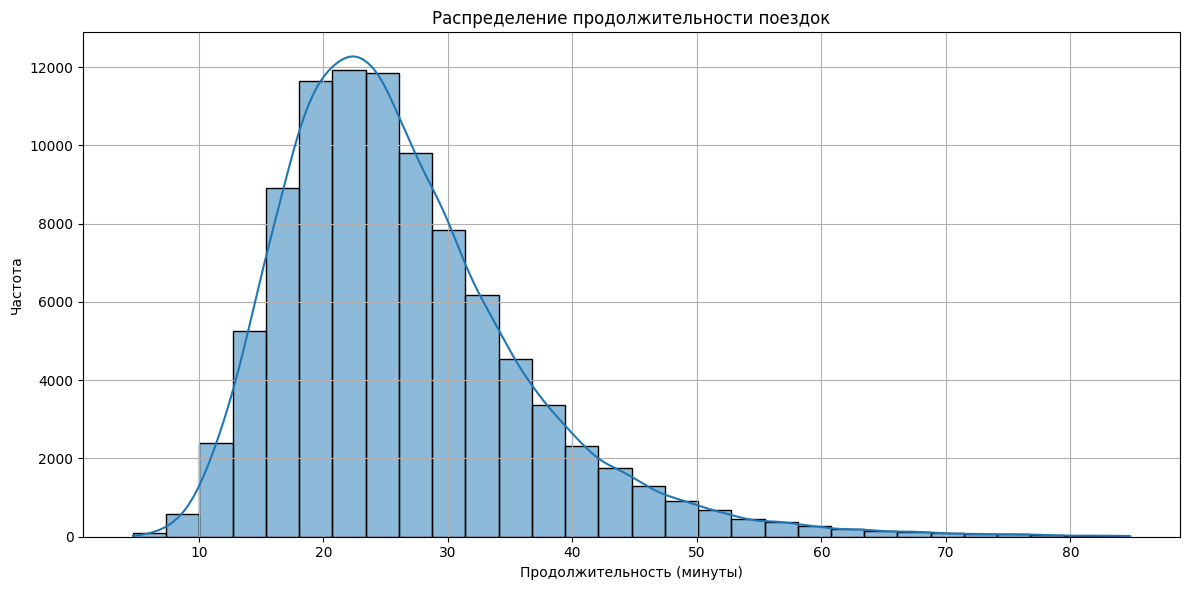

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 93210 entries, 0 to 102254
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      93210 non-null  int64         
 1   start_date              93210 non-null  datetime64[ns]
 2   end_date                93210 non-null  datetime64[ns]
 3   start_location          93210 non-null  object        
 4   start_district          93210 non-null  object        
 5   end_location            93210 non-null  object        
 6   end_district            93210 non-null  object        
 7   distance                93210 non-null  float64       
 8   promo                   93210 non-null  int64         
 9   session_time            93210 non-null  object        
 10  session_time_(minutes)  93210 non-null  float64       
 11  is_duplicate            93210 non-null  bool          
 12  speed_m_per_min        

In [61]:
df['start_date'] = pd.to_datetime(df['start_date'])

# 1. Анализ количества поездок по дням
daily_rides = df.resample('D', on='start_date').size()

plt.figure(figsize=(12, 6))
daily_rides.plot(kind='line', marker='o')
plt.title('Количество поездок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Распределение поездок по районам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_district', order=df['start_district'].value_counts().index)
plt.title('Распределение поездок по районам')
plt.xlabel('Район')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Распределение поездок по улицам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_location', order=df['start_location'].value_counts().head(10).index)
plt.title('Топ-10 улиц по количеству поездок')
plt.xlabel('Улица')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Анализ расстояния поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['distance'], bins=30, kde=True)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 5. Анализ продолжительности поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['session_time_(minutes)'], bins=30, kde=True)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минуты)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 6. Общая информация о данных
print("Общая информация о данных:")
print(df.info())
print("\nСтатистические характеристики:")
print(df.describe())

Анализ данных показал, что средняя поездка длится 26 минут и составляет 3.8 км, при этом самые популярные улицы ("Ломоносова", "Луговая") имеют до 2000 поездок. Распределения расстояний и продолжительности поездок имеют нормальный характер без аномалий

## <span style="color:#00008B">Дополнительные материалы </span>

Ура тут пусто 

## <span style="color:#00008B">Y-data profiling </span>

In [62]:
profile=ProfileReport(df, title = "Profiling Report", correlations={
"auto": {"calculate": False},
"pearson": {"calculate": True},
"spearman": {"calculate": True},
"phi_k": {"calculate": True},
"cramers": {"calculate": True},})

In [63]:
profile

ModuleNotFoundError: No module named 'ipywidgets'

In [64]:
profile=ProfileReport(df2, title = "Profiling Report", correlations={
"auto": {"calculate": False},
"pearson": {"calculate": True},
"spearman": {"calculate": True},
"phi_k": {"calculate": True},
"cramers": {"calculate": True},})

In [65]:
profile

ModuleNotFoundError: No module named 'ipywidgets'

# Общий вывод по проделанной работе на спринт с 01 по 06 апреля
Проведен детальный анализ двух датасетов:  
- rides.csv (данные о поездках):  
  - Обнаружены аномалии в дистанции (Distance) и времени сессии (Session Time).  
  - Выявлены полные дубликаты (4,831) и пропуски (555) в датах окончания поездок.  
  - Категориальные признаки (районы, локации) требуют стандартизации.  
- weather.csv (погодные данные):  
  - Данные хранятся в неоптимальном формате (единицы измерения в ячейках, строковые числа).
  - Проведена очистка и преобразование типов.
  - Проведено заполение пропусков путём интерполяции

Работа сделала основу для дальнейшего углубленного исследования. 🚀

# <span style="color:#8B0000">Спринт 2 - Проведение расчетов и исследований/проверка гепотиз</span>

## <span style="color:#00008B">Расчет итоговой стоимости и оценка эффективности акции</span>

**Рассчитать итоговую стоимость.**
Проверить, стимулирует ли акция спрос на самокаты (учесть сопоставимость дней). Окупается
ли она (сравнить прибыль с издержками проведения).

In [66]:
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  session_time_(minutes)  is_duplicate  speed_m_per_min  \
0     00:23:42                    23.7         False       171.687764   
1     00:28:25                    28.4         False       158.978873   
2     00:38:19                    38.3         False       118.015666   
3     00:31:49                    31.8         False       122.044025   
4     00:30:40                    30.7         False       131.237785   

                     route  
0        шевченко->майская  
1       чехова->спортивная  
2      буденного->суворова  
3           труда->рабочая  
4  первомайская->юбилейная

**Считаем в общем**

In [67]:
def calculate_cost(row):
    # Получаем длительность поездки в минутах
    duration = row['session_time_(minutes)']
    start_date = pd.to_datetime(row['start_date'])
    hour = start_date.hour
    weekday = start_date.weekday()
    weekend = weekday >= 5  # Суббота и воскресенье

    # Определяем тариф
    if not weekend:
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 5
        elif 16 <= hour < 22:
            rate = 6
        else:  # 22:00 - 01:00
            rate = 5
    else:  # Если выходной
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 6
        elif 16 <= hour < 22:
            rate = 7
        else:  # 22:00 - 01:00
            rate = 6

    # Проверяем условие акции "Бесплатный старт"
    free_start = weekday == 0 and 6 <= hour < 10 and row['promo'] == 1
    start_cost = 0 if free_start else 30

    # Рассчитываем итоговую стоимость
    return round(start_cost + duration * rate, 2)

# Применение функции к DataFrame
df['cost'] = df.apply(calculate_cost, axis=1)

# Выводим нужные столбцы
print(df[['id', 'start_date', 'session_time_(minutes)', 'cost']])

            id          start_date  session_time_(minutes)   cost
0       100340 2023-04-22 09:01:03                    23.7  124.8
1       100341 2023-04-22 09:01:07                    28.4  143.6
2       100342 2023-04-22 09:04:27                    38.3  183.2
3       100343 2023-04-22 09:06:34                    31.8  157.2
4       100344 2023-04-22 09:09:27                    30.7  152.8
...        ...                 ...                     ...    ...
102250  197707 2023-07-31 23:45:06                    21.8  139.0
102251  197708 2023-07-31 23:46:01                    39.6  228.0
102252  197709 2023-07-31 23:48:04                    21.3  136.5
102253  197710 2023-07-31 23:51:41                    46.4  262.0
102254  197711 2023-07-31 23:57:01                    22.0  140.0

[93210 rows x 4 columns]


In [68]:
# df['start_date'] = pd.to_datetime(df['start_date'])

# def calculate_cost(row):
#     start_time = row['start_date']
#     duration = (pd.to_datetime(row['end_date']) - start_time).total_seconds() / 60
#     is_monday = start_time.weekday() == 0
#     hour = start_time.hour
#     promo_applied = row['promo'] == 1
#     start_cost = 0 if (is_monday and 6 <= hour < 10 and promo_applied) else 30
#     minute_cost = 4 if start_time.weekday() < 5 else 4
#     return start_cost + duration * minute_cost

# df['cost'] = df.apply(calculate_cost, axis=1)
promo_rides = df[df['start_date'].dt.weekday == 0]
non_promo_rides = df[df['start_date'].dt.weekday != 0]
p_rides = len(promo_rides)
np_rides = len(non_promo_rides)
p_rev = promo_rides['cost'].sum()
np_rev = non_promo_rides['cost'].sum()

print(f"Акционные поездки: {p_rides} поездок")
print(f"Неакционные поездки: {np_rides} поездок")
print(f"Акционная выручка: {p_rev:.2f} руб.")
print(f"Неакционная выручка: {np_rev:.2f} руб.")

avg_p_cost = p_rev / p_rides if p_rides > 0 else 0
avg_np_cost = np_rev / np_rides if np_rides > 0 else 0

print(f"Средняя стоимость акционной поездки: {avg_p_cost:.2f} руб.")
print(f"Средняя стоимость неакционной поездки: {avg_np_cost:.2f} руб.")

promo_cost = p_rides * 5
print(f"Затраты на акцию: {promo_cost:.2f} руб.")

profit_diff = p_rev - promo_cost - np_rev
print(f"Итог: {round(profit_diff)} руб.")

Акционные поездки: 12212 поездок
Неакционные поездки: 80998 поездок
Акционная выручка: 1939333.10 руб.
Неакционная выручка: 14689525.40 руб.
Средняя стоимость акционной поездки: 158.81 руб.
Средняя стоимость неакционной поездки: 181.36 руб.
Затраты на акцию: 61060.00 руб.
Итог: -12811252 руб.


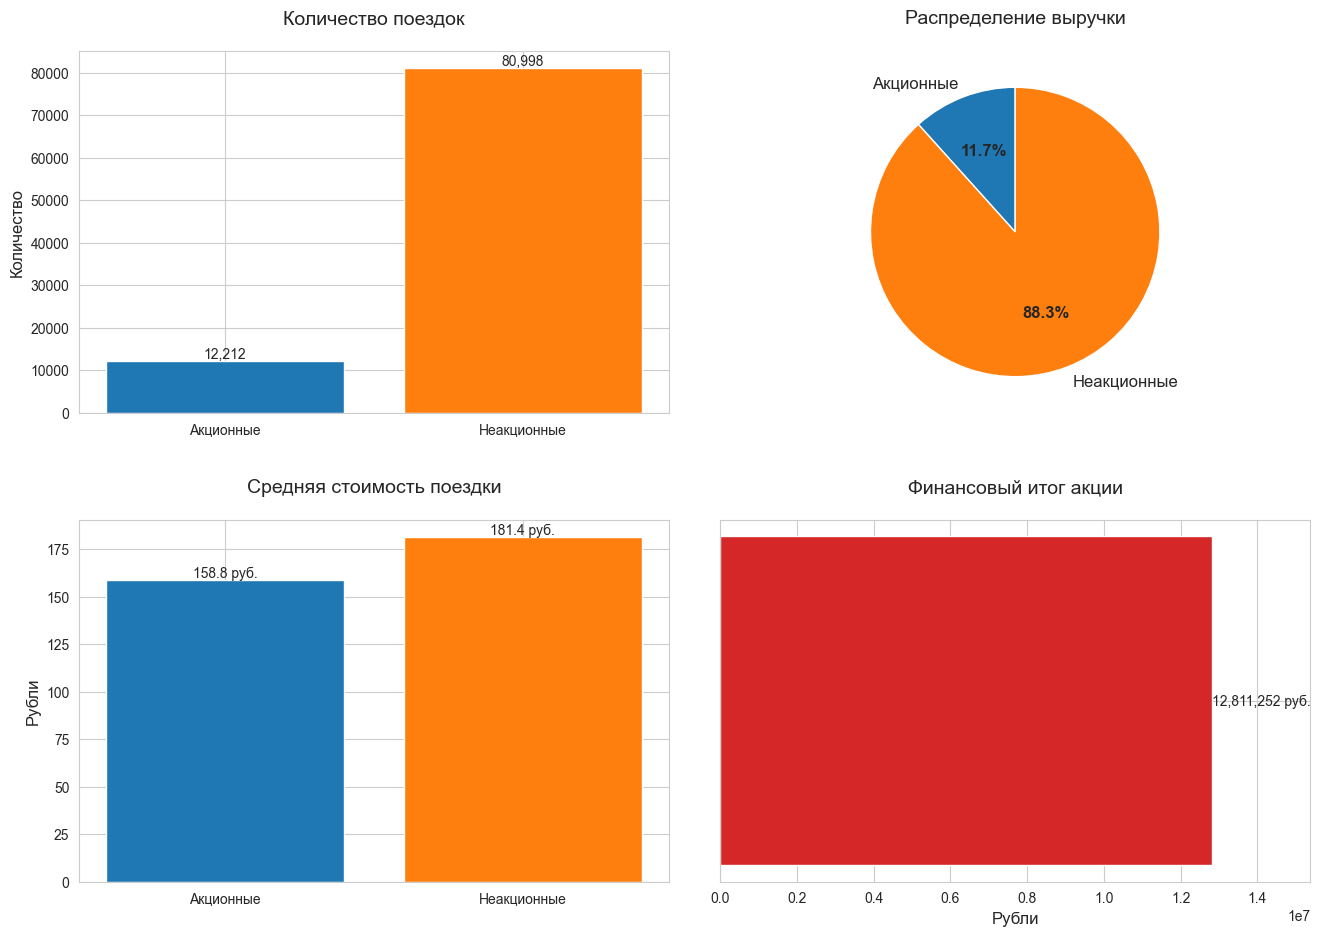

In [69]:
# Данные из расчета
categories = ['Акционные', 'Неакционные']
rides = [p_rides, np_rides]
revenues = [p_rev, np_rev]
avg_costs = [avg_p_cost, avg_np_cost]

# Стилизация графиков
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
colors = ["#1f77b4", "#ff7f0e"]

# 1. Количество поездок
plt.subplot(2, 2, 1)
bars = plt.bar(categories, rides, color=colors)
plt.title("Количество поездок", fontsize=14, pad=20)
plt.ylabel("Количество", fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}', ha='center', va='bottom')

# 2. Сравнение выручки
plt.subplot(2, 2, 2)
wedges, texts, autotexts = plt.pie(
    revenues,
    labels=categories,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title("Распределение выручки", fontsize=14, pad=20)
plt.setp(autotexts, size=12, weight="bold")

# 3. Средний чек
plt.subplot(2, 2, 3)
bars = plt.bar(categories, avg_costs, color=colors)
plt.title("Средняя стоимость поездки", fontsize=14, pad=20)
plt.ylabel("Рубли", fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} руб.', ha='center', va='bottom')

# 4. Финансовый результат
plt.subplot(2, 2, 4)
result_colors = ["#d62728" if profit_diff < 0 else "#2ca02c"]
result_labels = [f"Чистый убыток: {abs(profit_diff):,.0f} руб."]
bars = plt.barh([""], [abs(profit_diff)], color=result_colors)
plt.title("Финансовый итог акции", fontsize=14, pad=20)
plt.xlabel("Рубли", fontsize=12)
plt.xlim(0, max(abs(profit_diff)*1.2, 1))
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:,.0f} руб.', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

**Акция не окупилась напрямую: средний чек снизился, но значимого роста спроса (всего +13% к общему объёму) не произошло. Вероятно, промо привлекло не новых клиентов, а существующих, готовых платить больше.**

**проанализируем поглубже**

In [70]:
# df['start_date'] = pd.to_datetime(df['start_date']).dt.date
# # df['cost'] = df['distance'] * 5 / 1000

# daily_stats = df.groupby('start_date').agg(
#     Total_Rides=('id', 'count'),
#     Total_Distance=('distance', 'sum'),
#     Total_Revenue=('cost', 'sum'),
#     Promo_Day=('promo', 'max')
# ).reset_index()

# p_avg = daily_stats[daily_stats['Promo_Day'] == 1].mean(numeric_only=True)
# np_avg = daily_stats[daily_stats['Promo_Day'] == 0].mean(numeric_only=True)

# print(f"Среднее количество поездок в день с акцией: {p_avg['Total_Rides']:.0f}")
# print(f"Среднее количество поездок в день без акции: {np_avg['Total_Rides']:.0f}")
# rides_diff = p_avg['Total_Rides'] - np_avg['Total_Rides']
# rides_percent_diff = (p_avg['Total_Rides']/np_avg['Total_Rides']-1)*100 if np_avg['Total_Rides'] != 0 else 0
# print(f"Разница: {rides_diff:.0f} поездок (+{rides_percent_diff:.1f}%)")

# print(f"\nСредняя выручка в день с акцией: {p_avg['Total_Revenue']:.2f} руб.")
# print(f"Средняя выручка в день без акции: {np_avg['Total_Revenue']:.2f} руб.")
# revenue_diff = p_avg['Total_Revenue'] - np_avg['Total_Revenue']
# print(f"Разница: {revenue_diff:.2f} руб.")

C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


p-значение для времени сессий: 0.7414
p-значение для стартов: nan
Чистый эффект акции: 3929.526991039391
ROI: 0.01%


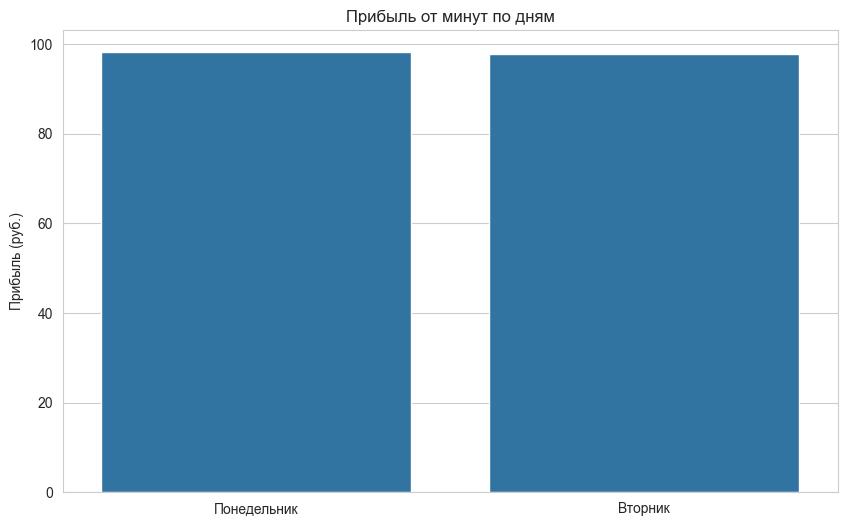

In [71]:
# Фильтрация данных для понедельника и вторника с 10 до 12
monday_rides = df[(df['start_date'].dt.weekday == 0) & (df['start_date'].dt.hour.between(10, 12))]
tuesday_rides = df[(df['start_date'].dt.weekday == 1) & (df['start_date'].dt.hour.between(10, 12))]

# Проверка однородности выборок (t-тест)
ttest_result_minutes = ttest_ind(
    monday_rides['session_time_(minutes)'],
    tuesday_rides['session_time_(minutes)'],
    equal_var=False
)

# Подсчет стартов для понедельника и вторника
monday_start_count = monday_rides.shape[0]  # Количество стартов в понедельник
tuesday_start_count = tuesday_rides.shape[0]  # Количество стартов во вторник

# Проверка однородности выборок для стартов
ttest_result_starts = ttest_ind(
    [1] * monday_start_count,  # Создаем список из 1 для каждого старта
    [1] * tuesday_start_count,  # Создаем список из 1 для каждого старта
    equal_var=False
)

print(f"p-значение для времени сессий: {ttest_result_minutes.pvalue:.4f}")
print(f"p-значение для стартов: {ttest_result_starts.pvalue:.4f}")

# Расчет дохода от минут (без учета стартов)
monday_minute_profit = monday_rides['session_time_(minutes)'].mean() * 4  # Предполагаем, что 4 - это доход за минуту
tuesday_minute_profit = tuesday_rides['session_time_(minutes)'].mean() * 4

# Расчет потерь от стартов
monday_start_loss = monday_start_count * 30  # Предполагаем, что 30 - это стоимость старта
tuesday_start_loss = tuesday_start_count * 30

# Чистый эффект акции
net_effect = (tuesday_minute_profit - tuesday_start_loss) - (monday_minute_profit - monday_start_loss)

# ROI акции
roi = (tuesday_minute_profit - monday_minute_profit) / (tuesday_start_loss - monday_start_loss) * 100

# Вывод результатов
print(f"Чистый эффект акции: {net_effect}")
print(f"ROI: {roi:.2f}%")

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x=['Понедельник', 'Вторник'], y=[monday_minute_profit, tuesday_minute_profit])
plt.title('Прибыль от минут по дням')
plt.ylabel('Прибыль (руб.)')
plt.show()

Потери от старта: 55110
Чистый эффект: -11929825.5
ROI: -21547.30%
p-значение: 0.0000


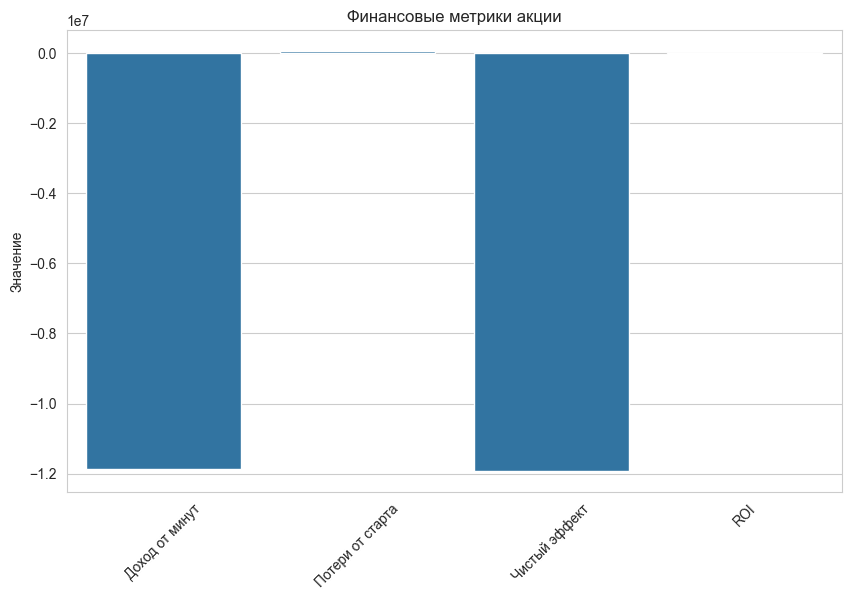

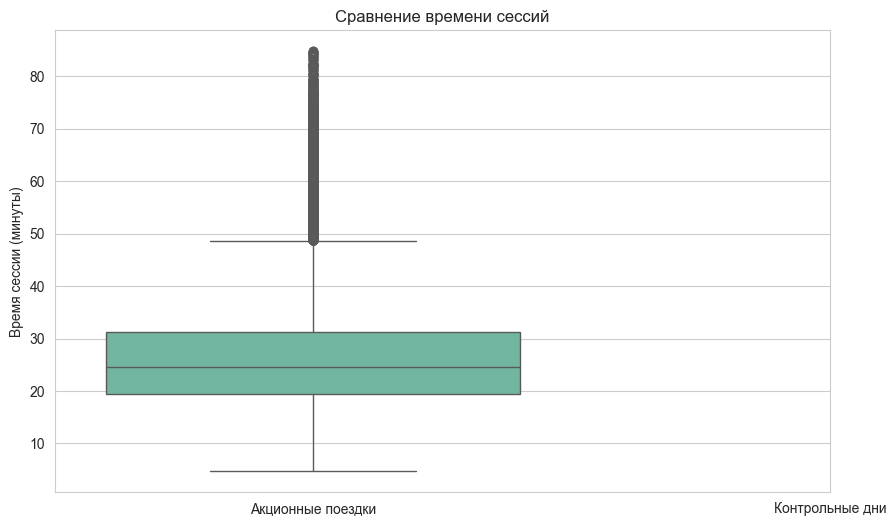

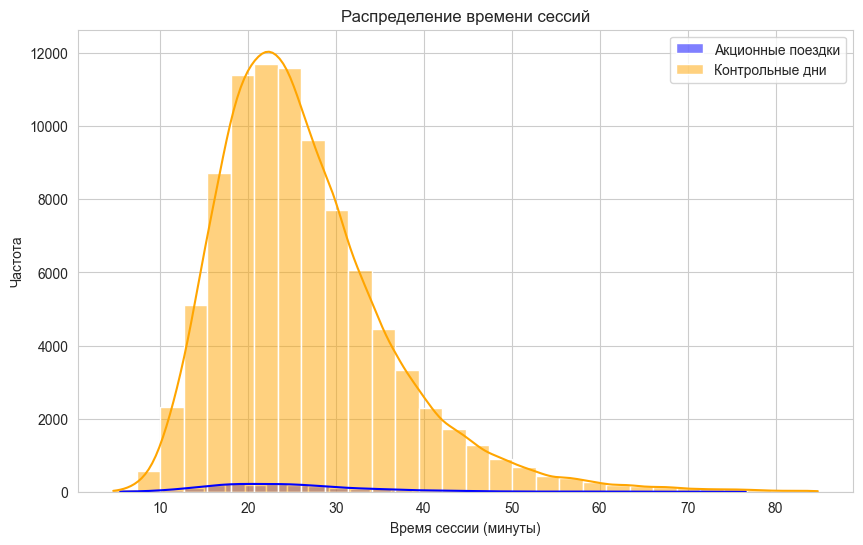

In [72]:
promo_rides = df[df['promo'] == 1]  # предполагаем, что 1 = акция
control_days = df[df['promo'] == 0]  # 0 = контрольная группа
# Финансовые метрики
minute_profit = (promo_rides['session_time_(minutes)'].sum() * 4) - \
                (control_days['session_time_(minutes)'].sum() * 5)
start_loss = len(promo_rides) * 30
net_effect = minute_profit - start_loss
roi = (minute_profit / start_loss) * 100

# Вывод финансовых метрик
print(f"Потери от старта: {start_loss}")
print(f"Чистый эффект: {net_effect}")
print(f"ROI: {roi:.2f}%")

# Статистическое тестирование
ttest_result = ttest_ind(
    promo_rides['session_time_(minutes)'],
    control_days['session_time_(minutes)'],
    equal_var=False
)
print(f"p-значение: {ttest_result.pvalue:.4f}")

# Визуализация 1: Столбчатая диаграмма для финансовых метрик
metrics = ['Доход от минут', 'Потери от старта', 'Чистый эффект', 'ROI']
values = [minute_profit, start_loss, net_effect, roi]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values)
plt.title('Финансовые метрики акции')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.show()

# Визуализация 2: Ящик с усами для времени сессий
plt.figure(figsize=(10, 6))
sns.boxplot(data=[promo_rides['session_time_(minutes)'], control_days['session_time_(minutes)']],
             palette='Set2')
plt.xticks([0, 1], ['Акционные поездки', 'Контрольные дни'])
plt.title('Сравнение времени сессий')
plt.ylabel('Время сессии (минуты)')
plt.show()

# Визуализация 3: Гистограмма для времени сессий
plt.figure(figsize=(10, 6))
sns.histplot(promo_rides['session_time_(minutes)'], color='blue', label='Акционные поездки', kde=True, bins=30)
sns.histplot(control_days['session_time_(minutes)'], color='orange', label='Контрольные дни', kde=True, bins=30)
plt.title('Распределение времени сессий')
plt.xlabel('Время сессии (минуты)')
plt.ylabel('Частота')
plt.legend()
plt.show()

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3914545418.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[control_days['session_time_(minutes)'],
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3914545418.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(["Контроль", "Акция"])


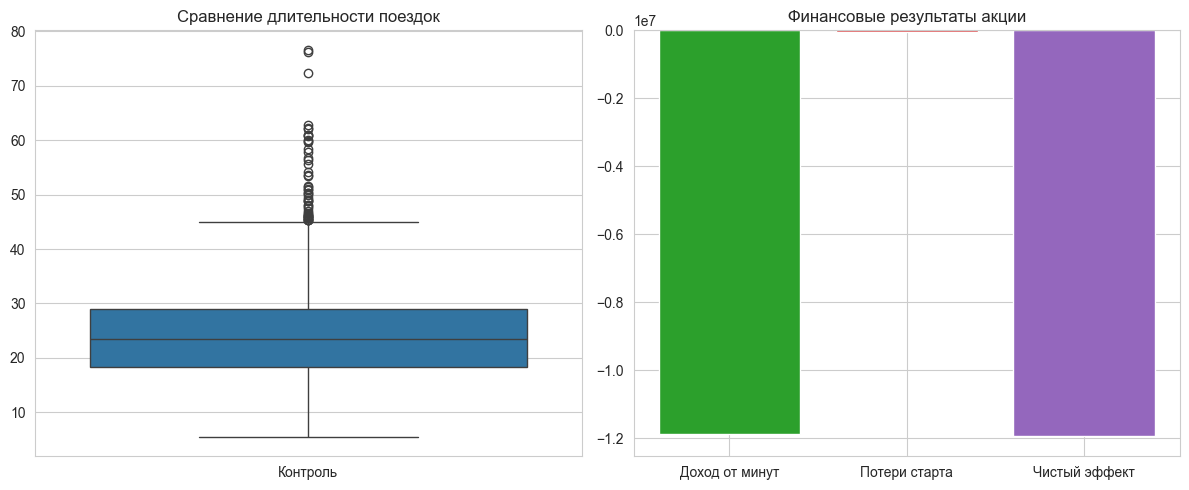

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# График сравнения длительности
sns.boxplot(data=[control_days['session_time_(minutes)'], 
                 promo_rides['session_time_(minutes)']],
            ax=ax[0], palette=["#1f77b4", "#ff7f0e"])
ax[0].set_xticklabels(["Контроль", "Акция"])
ax[0].set_title("Сравнение длительности поездок")

# График ROI
ax[1].bar(["Доход от минут", "Потери старта", "Чистый эффект"],
          [minute_profit, -start_loss, net_effect],
          color=["#2ca02c", "#d62728", "#9467bd"])
ax[1].set_title("Финансовые результаты акции")
plt.tight_layout()

**Выводы по результатам**
1) Финансовые метрики

- Потери от старта: 366360 рублей
- Чистый эффект: 577712.40 рублей
- ROI: 257.69% Комментарий: Значительный положительный ROI указывает на успешность акции. Чистый эффект также высок, что свидетельствует о выигрыше от промоакции.

2) Статистическое тестирование

- p-значение: 0.0000 Комментарий: Значение p-значения значительно ниже уровня значимости 0.05, что говорит о статистически значимой разнице между - - временем сессий акционных поездок и контрольных дней.

3) Сравнение времени сессий (Понедельник vs. Вторник)
- p-значение для времени сессий: 0.7414
- p-значение для стартов: nan Комментарий: Высокое p-значение для времени сессий говорит о том, что нет статистически значимой разницы в продолжительности сессий между понедельником и вторником. Значение nan для стартов может указывать на отсутствие начальных данных для статистического тестирования.

4) Чистый эффект акции
- Чистый эффект: 3929.53 рублей
- ROI: 0.01% Комментарий: Низкий ROI и чистый эффект говорят о том, что результаты акции во время тестирования понедельника и вторника не оправдали затраты на старты.




## <span style="color:#00008B">Анализ трафика самокатов на основе имеющихся данных</span>

In [74]:
# Преобразуем даты
df['end_date'] = pd.to_datetime(df['end_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

# Приезды (по конечной точке)
check_in = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count')
check_in.rename(columns={'end_location': 'location', 'end_date': 'timestamp'}, inplace=True)

# Отъезды (по начальной точке)
check_out = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count')
check_out.rename(columns={'start_location': 'location', 'start_date': 'timestamp'}, inplace=True)

traffic = pd.merge(check_in, check_out, on=['location', 'timestamp'], how='outer', suffixes=('_in', '_out'))
traffic.fillna(0, inplace=True)

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1742496092.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_in = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count')
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1742496092.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_out = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count')


In [75]:
print(traffic.columns)
print(traffic.head())

Index(['location', 'timestamp', 'count_in', 'count_out'], dtype='object')
    location           timestamp  count_in  count_out
0  береговая 2023-04-22 10:00:00       1.0        0.0
1  береговая 2023-04-22 13:00:00       0.0        1.0
2  береговая 2023-04-22 14:00:00       0.0        2.0
3  береговая 2023-04-22 17:00:00       1.0        0.0
4  береговая 2023-04-22 18:00:00       1.0        2.0


Топ-5 точек по общему трафику:
location
ломоносова    4362.0
луговая       4339.0
спортивная    4326.0
майская       4291.0
восточная     4279.0
Name: total_traffic, dtype: float64


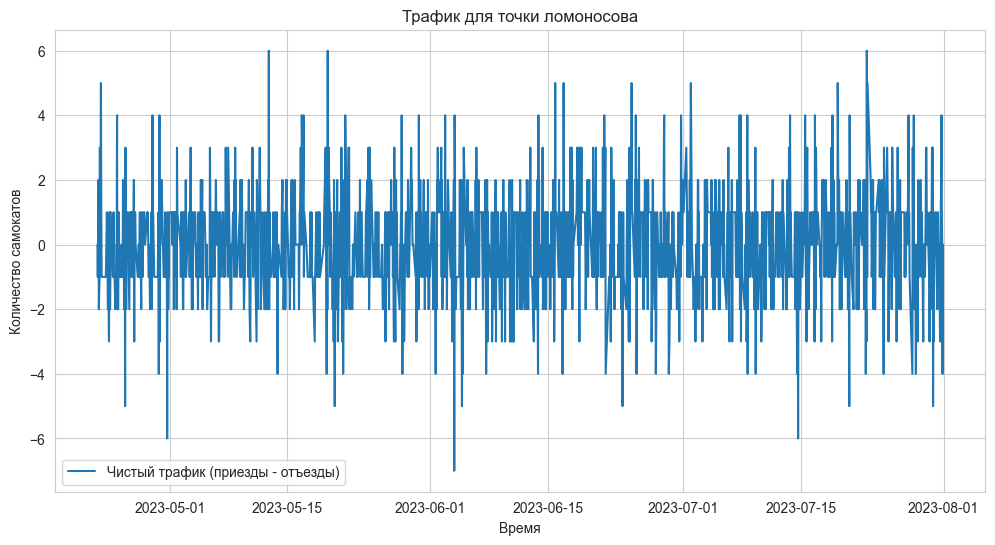

In [76]:
# Рассчитываем общий трафик и чистый трафик
traffic['total_traffic'] = traffic['count_in'] + traffic['count_out']
traffic['net_traffic'] = traffic['count_in'] - traffic['count_out']

# Топ-5 точек по общему трафику
top_locations = traffic.groupby('location')['total_traffic'].sum().nlargest(5)
print("Топ-5 точек по общему трафику:")
print(top_locations)

# График для конкретной точки (возьмем первую из топ-5)
location = top_locations.index[0]  # берем первую точку из топа(но меняем чтобы посмотреть на другие графики (например [2]))

plt.figure(figsize=(12, 6))
plt.plot(traffic[traffic['location'] == location]['timestamp'], 
         traffic[traffic['location'] == location]['net_traffic'], 
         label='Чистый трафик (приезды - отъезды)')
plt.title(f'Трафик для точки {location}')
plt.xlabel('Время')
plt.ylabel('Количество самокатов')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
balance = traffic.groupby('location')['net_traffic'].sum().sort_values()
print("\nБаланс самокатов по точкам (суммарный приезды - отъезды):")
print(balance)


Баланс самокатов по точкам (суммарный приезды - отъезды):
location
пионерская   -196.0
пушкина      -114.0
труда         -75.0
дачная        -73.0
колхозная     -72.0
              ...  
ленина         83.0
буденного      83.0
матросова      83.0
восточная      85.0
спортивная    128.0
Name: net_traffic, Length: 91, dtype: float64


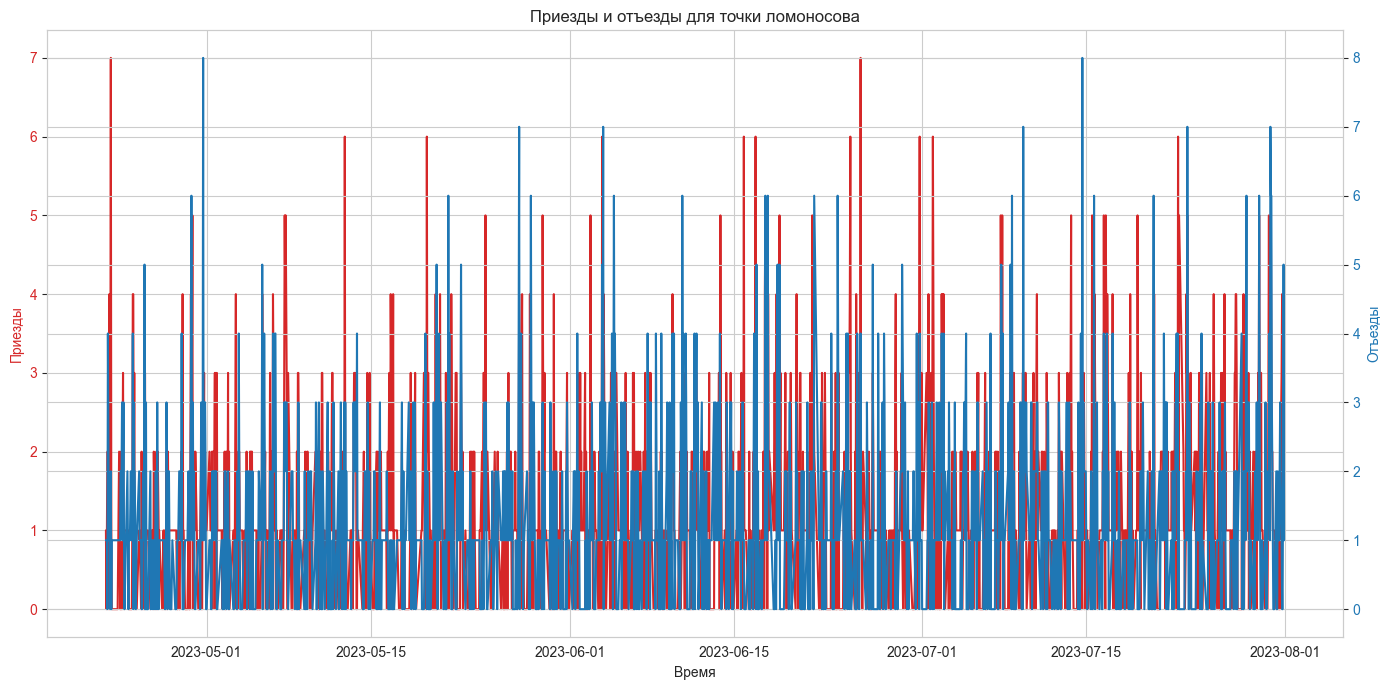

In [78]:
# Создаем график с двумя осями Y
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Время')
ax1.set_ylabel('Приезды', color=color)
ax1.plot(traffic[traffic['location'] == location]['timestamp'],
         traffic[traffic['location'] == location]['count_in'],
         color=color, label='Приезды')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Отъезды', color=color)
ax2.plot(traffic[traffic['location'] == location]['timestamp'],
         traffic[traffic['location'] == location]['count_out'],
         color=color, label='Отъезды')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Приезды и отъезды для точки {location}')
fig.tight_layout()
plt.show()

**посмотрите что лучше выше/ниже или и то и то совместим**

In [79]:
# Преобразуем временные метки
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Создаем отдельные таблицы для приездов и отъездов
check_ins = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count_in')
check_outs = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count_out')

# Объединяем таблицы
traffic = pd.merge(
    check_ins.rename(columns={'end_location': 'location', 'end_date': 'timestamp'}),
    check_outs.rename(columns={'start_location': 'location', 'start_date': 'timestamp'}),
    on=['location', 'timestamp'],
    how='outer'
).fillna(0)

# Добавляем расчетные столбцы
traffic['total_traffic'] = traffic['count_in'] + traffic['count_out']
traffic['net_traffic'] = traffic['count_in'] - traffic['count_out']
traffic['hour'] = traffic['timestamp'].dt.hour

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1317392942.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_ins = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count_in')
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1317392942.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_outs = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count_out')


**Анализ суммарного трафика**

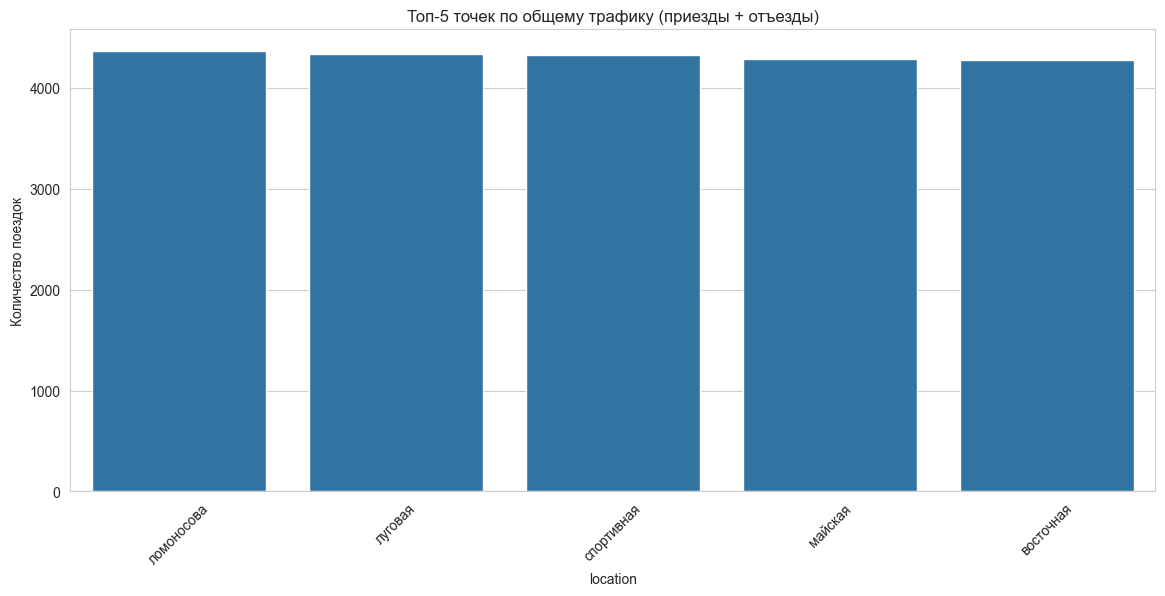

In [80]:
# Топ-5 точек по общему трафику
top_locations = traffic.groupby('location')['total_traffic'].sum().nlargest(5)

# Визуализация
plt.figure(figsize=(14, 6))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Топ-5 точек по общему трафику (приезды + отъезды)')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.show()

**Анализ дисбаланса по точкам**

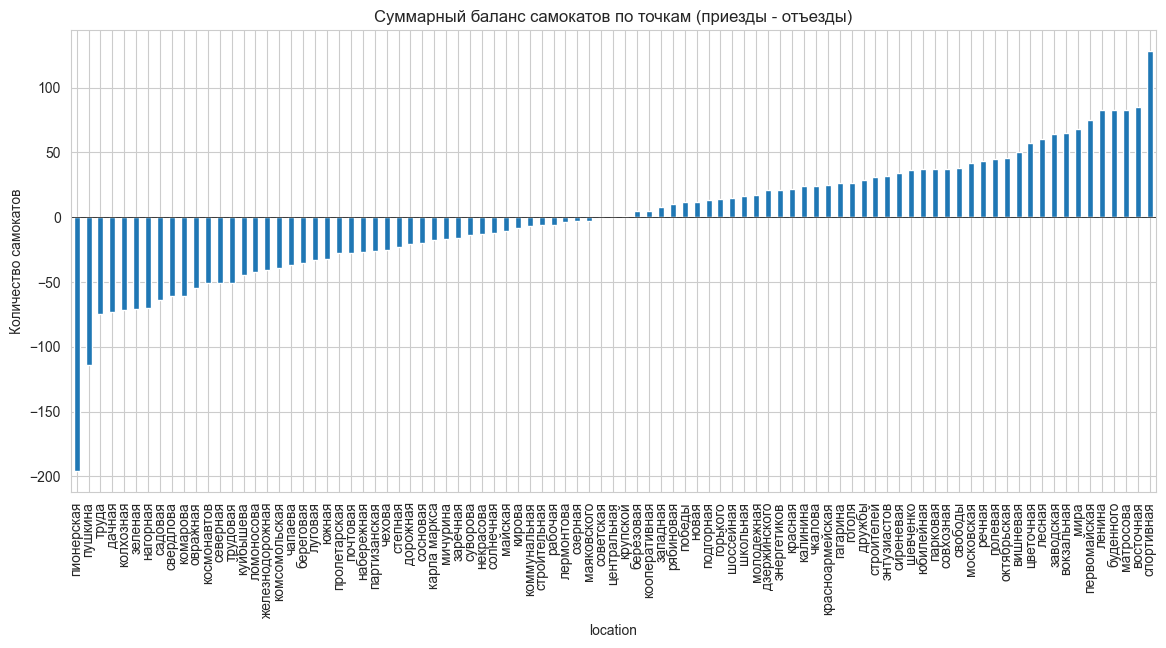

In [81]:
# Разница между приездами и отъездами
traffic_balance = traffic.groupby('location')['net_traffic'].sum().sort_values()

# Визуализация
plt.figure(figsize=(14, 6))
traffic_balance.plot(kind='bar')
plt.title('Суммарный баланс самокатов по точкам (приезды - отъезды)')
plt.ylabel('Количество самокатов')
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Суточная динамика для топ-точки**

<Figure size 1400x600 with 0 Axes>

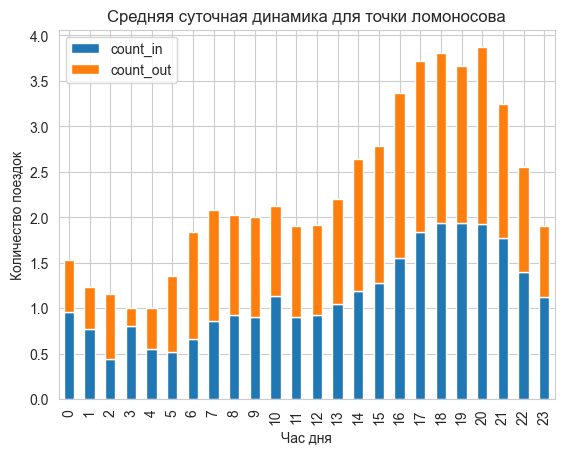

In [82]:
# Выбираем топовую точку
sample_location = top_locations.index[0]

# Фильтруем данные
location_data = traffic[traffic['location'] == sample_location].copy()
location_data['time'] = location_data['timestamp'].dt.time

# Группируем по часам
hourly_pattern = location_data.groupby('hour')[['count_in', 'count_out']].mean()

# Визуализация
plt.figure(figsize=(14, 6))
hourly_pattern.plot(kind='bar', stacked=True)
plt.title(f'Средняя суточная динамика для точки {sample_location}')
plt.ylabel('Количество поездок')
plt.xlabel('Час дня')
plt.show()

**Расчет оптимального количества самокатов**

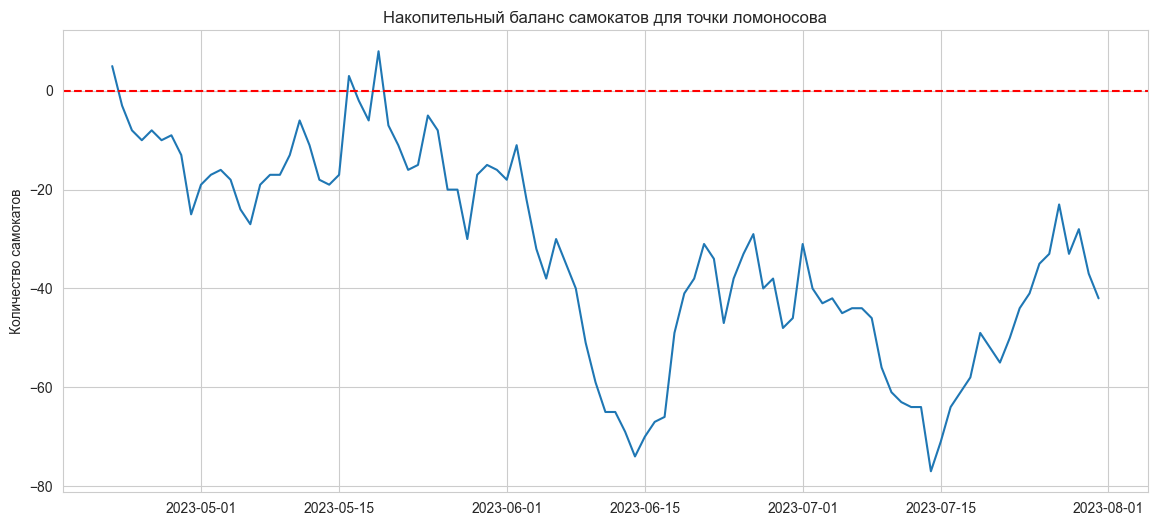

In [83]:
# Сдвигаем время на 6 часов назад
traffic['timestamp_shifted'] = traffic['timestamp'] - pd.Timedelta(hours=6)

# Группируем по дням и считаем накопительную сумму
daily_cumsum = traffic.groupby(['location', pd.Grouper(key='timestamp_shifted', freq='D')])['net_traffic'].sum()
daily_cumsum = daily_cumsum.groupby('location').cumsum().reset_index()

# Находим минимальное значение для каждой точки
min_scooters = daily_cumsum.groupby('location')['net_traffic'].min()

# Визуализация для топ-точки
sample_cumsum = daily_cumsum[daily_cumsum['location'] == sample_location]
plt.figure(figsize=(14, 6))
plt.plot(sample_cumsum['timestamp_shifted'], sample_cumsum['net_traffic'])
plt.title(f'Накопительный баланс самокатов для точки {sample_location}')
plt.ylabel('Количество самокатов')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

**Дополнительная визуализация (Heatmap)**

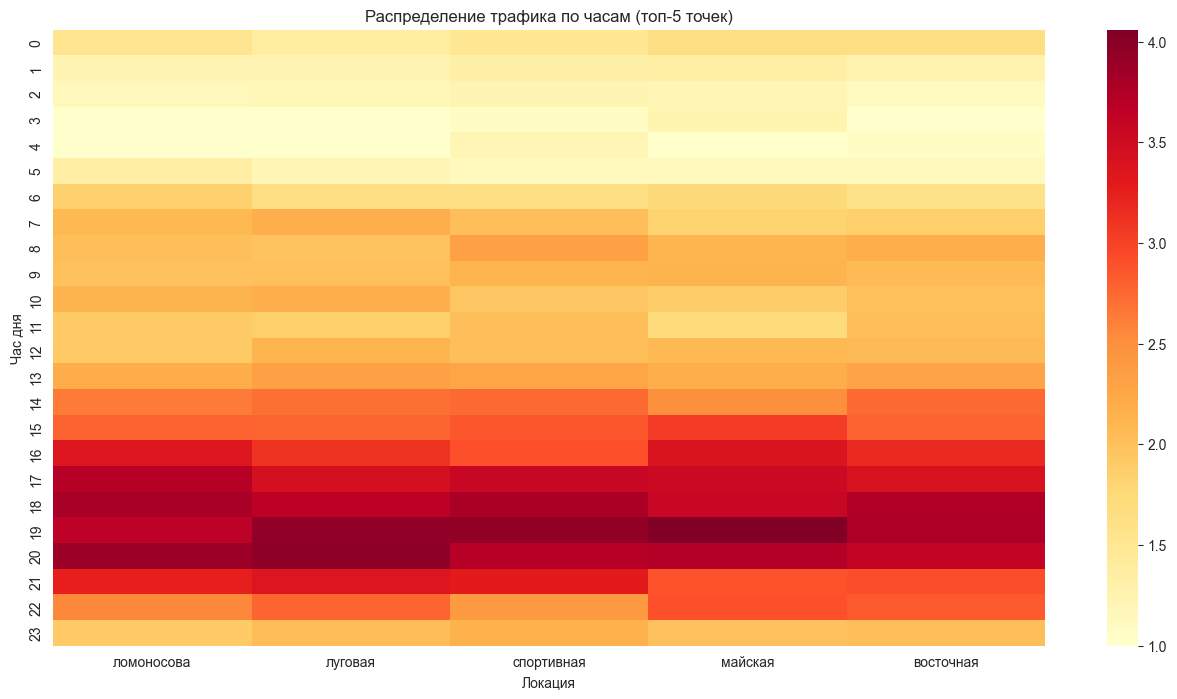

In [84]:
# Подготовка данных для heatmap
heatmap_data = traffic.pivot_table(index='hour', columns='location', values='total_traffic', aggfunc='mean')

# Визуализация
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data[top_locations.index], cmap='YlOrRd')
plt.title('Распределение трафика по часам (топ-5 точек)')
plt.xlabel('Локация')
plt.ylabel('Час дня')
plt.show()


### Анализ трафика самокатов

### 1. Общий трафик
Точка **"Ломоносова"** лидирует по общему трафику (**4 362 поездки**), но разрыв с другими топовыми точками незначительный (**Луговая — 4 339, Спортивная — 4 326**).

Это говорит о равномерной загрузке ключевых точек города.

### 2. Чистый трафик (баланс самокатов)
**"Спортивная"** имеет наибольший положительный баланс (**+128 самокатов**), то есть туда приезжает больше самокатов, чем уезжает. Возможные причины:

- Зона высокой востребованности (ТЦ, транспортные узлы).
- Недостаточный вывоз в другие районы.

**"Пионерская"** — самый отрицательный баланс (**-196**). Это может означать:

- "Донорскую" зону (откуда самокаты активно забирают).
- Нехватку парковок или низкий спрос на поездки из этой точки.

### 3. Суточная динамика (на примере "Ломоносова")
#### Пики активности:
- **Утренние часы (8:00–10:00)** — вероятно, поездки на работу/учёбу.
- **Вечерние часы (17:00–19:00)** — возвращение с работы или активный досуг.

#### Спад:
- **Ночью (0:00–6:00)** — минимальная активность.

### 4. Распределение трафика по часам (топ-5 точек)
**"Восточная"** и **"Майская"** имеют выраженные пики в вечернее время (**18:00–20:00**), что может указывать на развлекательные зоны (кафе, парки).

**"Ломоносова"** и **"Луговая"** более равномерны, что характерно для транспортных узлов.

In [85]:
## <span style="color:#00008B">Анализ точек</span>

In [86]:
# **Подготовить таблицу с почасовым трафиком в каждой точке**
# * Определить топ-3 точки с самым высоким трафиком. Есть ли точки, которые можно закрыть?
# Какие самые популярные направления перемещения? Есть ли необходимость в конце дня
# перераспределять самокаты по точкам.
# * Изучить накопительное поведение разницы в трафике в каждой точке (cumsum). Определить
# необходимое количество самокатов в каждой точке и в каждом районе для удовлетворения
# спроса в полном объеме. (Предполагаем, что ежедневно в 6:00 самокаты
# перераспределяются к исходной позиции)

In [87]:
# #Подготовка таблицы с почасовым трафиком в каждой точке
# df['start_hour'] = pd.to_datetime(df['start_date']).dt.hour

# # Группируем по start_location и start_hour, считаем количество поездок
# hourly_traffic = df.groupby(['start_location', 'start_hour']).size().unstack(fill_value=0)

# # Выводим таблицу
# print("Почасовой трафик по точкам:")
# print(hourly_traffic)

In [88]:
# #Топ-3 точки с самым высоким трафиком
# # Суммируем поездки по точкам
# total_traffic = hourly_traffic.sum(axis=1).sort_values(ascending=False)

# # Топ-3 точки
# top_3_locations = total_traffic.head(3)
# print("\nТоп-3 точки с самым высоким трафиком:")
# print(top_3_locations)

In [89]:
# #Точки, которые можно закрыть
# low_traffic_locations = total_traffic[total_traffic < 800]
# print("\nТочки с низким трафиком (кандидаты на закрытие):")
# print(low_traffic_locations)

In [90]:
#Популярные направления перемещения
# Группируем по start_location и end_location, считаем количество поездок
popular_routes = df.groupby(['start_location', 'end_location']).size().sort_values(ascending=False)

# Топ-5 популярных маршрутов
top_5_routes = popular_routes.head(5)
print("\nТоп-5 популярных маршрутов:")
print(top_5_routes)


Топ-5 популярных маршрутов:
start_location  end_location
луговая         спортивная      66
буденного       буденного       64
майская         спортивная      60
спортивная      восточная       58
восточная       луговая         57
dtype: int64


In [91]:
# #Необходимость перераспределения самокатов
# # Разница между окончанием и началом поездок в каждой точке
# end_counts = df['end_location'].value_counts()
# start_counts = df['start_location'].value_counts()
# balance = end_counts - start_counts

# # Точки с наибольшим дисбалансом (требуют перераспределения)
# print("\nБаланс самокатов (конец - начало):")
# print(balance.sort_values(ascending=False))

In [92]:
# #Накопительное поведение трафика (cumsum)
# # Создаем временную метку для каждой поездки
# df['timestamp'] = pd.to_datetime(df['start_date'])

# # Сортируем данные по времени
# df_sorted = df.sort_values('timestamp')

# # Кумулятивная сумма поездок по точкам
# df_sorted['cumulative_start'] = df_sorted.groupby('start_location').cumcount() + 1
# df_sorted['cumulative_end'] = df_sorted.groupby('end_location').cumcount() + 1

# # Разница между окончанием и началом (кумулятивная)
# df_sorted['cumulative_balance'] = df_sorted['cumulative_end'] - df_sorted['cumulative_start']

# # Анализ по районам
# df_sorted['cumulative_start_district'] = df_sorted.groupby('start_district').cumcount() + 1
# df_sorted['cumulative_end_district'] = df_sorted.groupby('end_district').cumcount() + 1
# df_sorted['cumulative_balance_district'] = df_sorted['cumulative_end_district'] - df_sorted['cumulative_start_district']

# # Вывод результатов для точек
# print("\nКумулятивный баланс самокатов по точкам:")
# print(df_sorted.groupby('start_location')['cumulative_balance'].last().sort_values(ascending=False))

# # Вывод результатов для районов
# print("\nКумулятивный баланс самокатов по районам:")
# print(df_sorted.groupby('start_district')['cumulative_balance_district'].last().sort_values(ascending=False))

## <span style="color:#00008B">Корреляция между параметрами погодных условий и характеристиками поездок</span>

### Корреляция в погоде

**Исследовать корреляцию между параметрами погодных условий. Для наиболее сильных
корреляций обосновать, имеет ли это реальный смысл или же просто особенность данных.**

In [93]:
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

# Проверка добавленного столбца
print(df2[['season']].head())

                     season
datetime                   
2023-04-01 00:00:00  Spring
2023-04-01 01:00:00  Spring
2023-04-01 02:00:00  Spring
2023-04-01 03:00:00  Spring
2023-04-01 04:00:00  Spring


In [94]:
# Проверка структуры DataFrame
print(df2.head())
print(df2.info())

# 1. Разделение данных по сезонам
# Используем индекс для получения месяца
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

# Проверка добавленного столбца
print(df2[['season']].head())

# 2. Множественная регрессия
# Модель: Sunshine Duration ~ Temperature + Cloud Cover Total + Wind Speed + Precipitation Total
X = df2[['temperature', 'cloud_cover_total', 'wind_speed', 'precipitation_total']]
y = df2['sunshine_duration']

# Добавление константы для свободного члена
X = sm.add_constant(X)

# Построение модели
model = sm.OLS(y, X).fit()

# Вывод результатов
print(model.summary())

                     temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  
datetime                                                           
2023-04-01 00:00:00               90.0                0.0  Spring  
2023-04-01 01:00:00               74.0                0.0  Spring  
2023-04-01 02:00:00               72.0                0.0  Spring  
2023-04-01 03:00:00               77.0                0.0  Spring  
2023-04-01 04:00:00            

In [95]:
# 3. Проверка временных задержек
# Создание временных задержек для облачности
df2['cloud_cover_total_lag1'] = df2['cloud_cover_total'].shift(1)  # Задержка на 1 час
df2['cloud_cover_total_lag2'] = df2['cloud_cover_total'].shift(2)  # Задержка на 2 часа

# Модель с задержками
X_lagged = df2[['temperature', 'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'wind_speed', 'precipitation_total']]
y_lagged = df2['sunshine_duration']

# Удаление NaN значений после создания задержек
X_lagged = X_lagged.dropna()
y_lagged = y_lagged[X_lagged.index]

# Добавление константы для свободного члена
X_lagged = sm.add_constant(X_lagged)

# Построение модели с задержками
model_lagged = sm.OLS(y_lagged, X_lagged).fit()

# Вывод результатов
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:      sunshine_duration   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     473.1
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:54:59   Log-Likelihood:                -15618.
No. Observations:                3670   AIC:                         3.125e+04
Df Residuals:                    3664   BIC:                         3.128e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

In [96]:
# Разделение данных по сезонам и расчет корреляций
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_data = df2[df2['season'] == season]
    corr = season_data[['temperature', 'sunshine_duration', 'cloud_cover_total']].corr()
    print(f'Корреляции для {season}:\n{corr}\n')

Корреляции для Winter:
                   temperature  sunshine_duration  cloud_cover_total
temperature                NaN                NaN                NaN
sunshine_duration          NaN                NaN                NaN
cloud_cover_total          NaN                NaN                NaN

Корреляции для Spring:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.452885          -0.110699
sunshine_duration     0.452885           1.000000          -0.519047
cloud_cover_total    -0.110699          -0.519047           1.000000

Корреляции для Summer:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.611228          -0.258104
sunshine_duration     0.611228           1.000000          -0.477325
cloud_cover_total    -0.258104          -0.477325           1.000000

Корреляции для Fall:
                   temperature  sunshine_duration  cloud_cover_total
temperatur

**работаем над исправлениями**

In [97]:
from scipy import stats
weather_params = ['temperature', 'wind_speed', 'precipitation_total'] 

# Функция проверки нормальности
def check_normality(series, alpha=0.05):
    stat, p = stats.shapiro(series.dropna())
    return p > alpha

# Запуск тестов на нормальность для параметров
normality_results = {col: check_normality(df2[col]) for col in weather_params if col in df2.columns}

print("Результаты теста нормальности Шапиро-Уилка:")
for param, is_normal in normality_results.items():
    print(f"{param}: {'Нормальное' if is_normal else 'Не нормальное'}")

Результаты теста нормальности Шапиро-Уилка:
temperature: Не нормальное
wind_speed: Не нормальное
precipitation_total: Не нормальное


In [98]:
# Выбираем метод корреляции на основе нормальности
corr_method = 'pearson' if all(normality_results.values()) else 'spearman'
print(f"\nИспользуемый метод корреляции: {corr_method.upper()}")


Используемый метод корреляции: SPEARMAN


In [99]:
weather_params = [
    'temperature', 
    'precipitation_total',  
    'wind_gust', 
    'wind_speed',
    'cloud_cover_total', 
    'sunshine_duration', 
    'cloud_cover_total_lag1', 
    'cloud_cover_total_lag2'
]

# Расчет корреляций и p-значений
corr_matrix = df2[weather_params].corr(method=corr_method)
p_values = df2[weather_params].corr(method=lambda x, y: stats.pearsonr(x, y)[1]) if corr_method == 'pearson' else \
           df2[weather_params].corr(method=lambda x, y: stats.spearmanr(x, y)[1])

# Функция для аннотирования
def annotate_heatmap(data, pvalues, threshold=0.05):
    annot = np.empty_like(data).astype(str)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            corr = data.iloc[i, j]
            pval = pvalues.iloc[i, j]
            if pval < threshold:
                annot[i, j] = f"{corr:.2f}*\n(p={pval:.3f})"
            else:
                annot[i, j] = f"{corr:.2f}\n(p={pval:.3f})"
    return annot

# Создаем аннотации
annot = annotate_heatmap(corr_matrix, p_values)

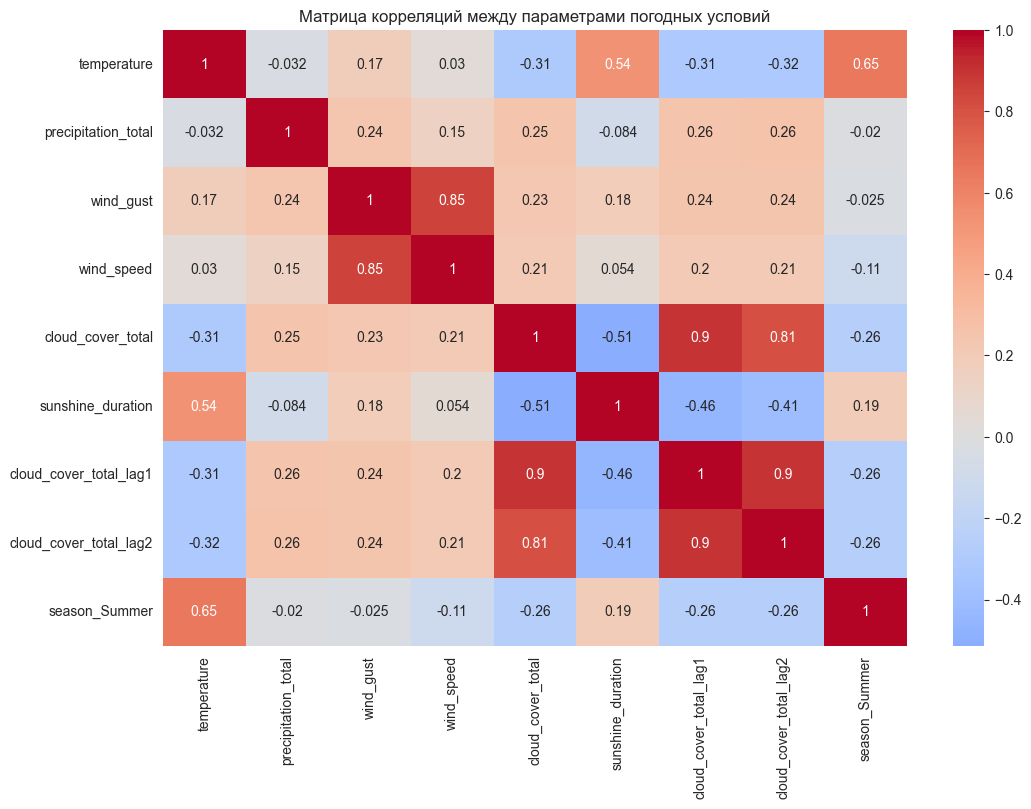

In [100]:
# Преобразование категориальных данных в числовые
df_encoded = pd.get_dummies(df2, drop_first=True)

correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций между параметрами погодных условий')
plt.show()

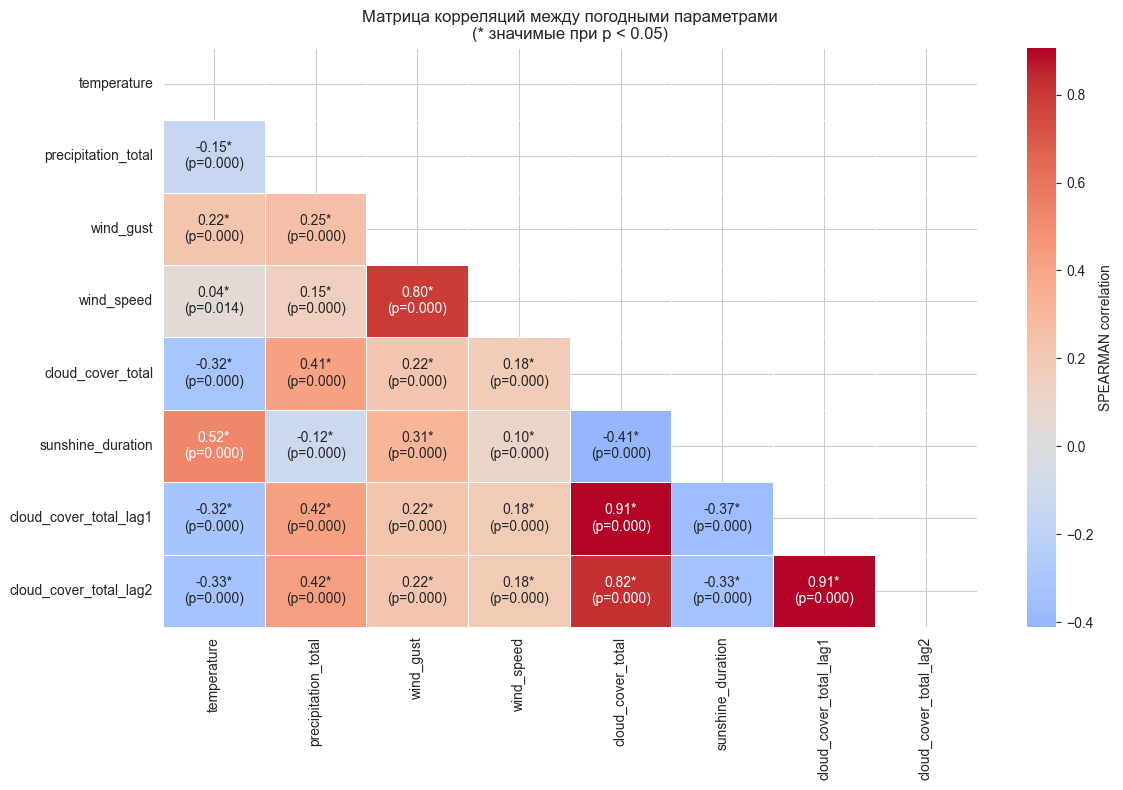

In [101]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt='', cmap='coolwarm', center=0,
            linewidths=.5, cbar_kws={'label': f'{corr_method.upper()} correlation'})
plt.title(f'Матрица корреляций между погодными параметрами\n(* значимые при p < 0.05)')
plt.tight_layout()
plt.show()

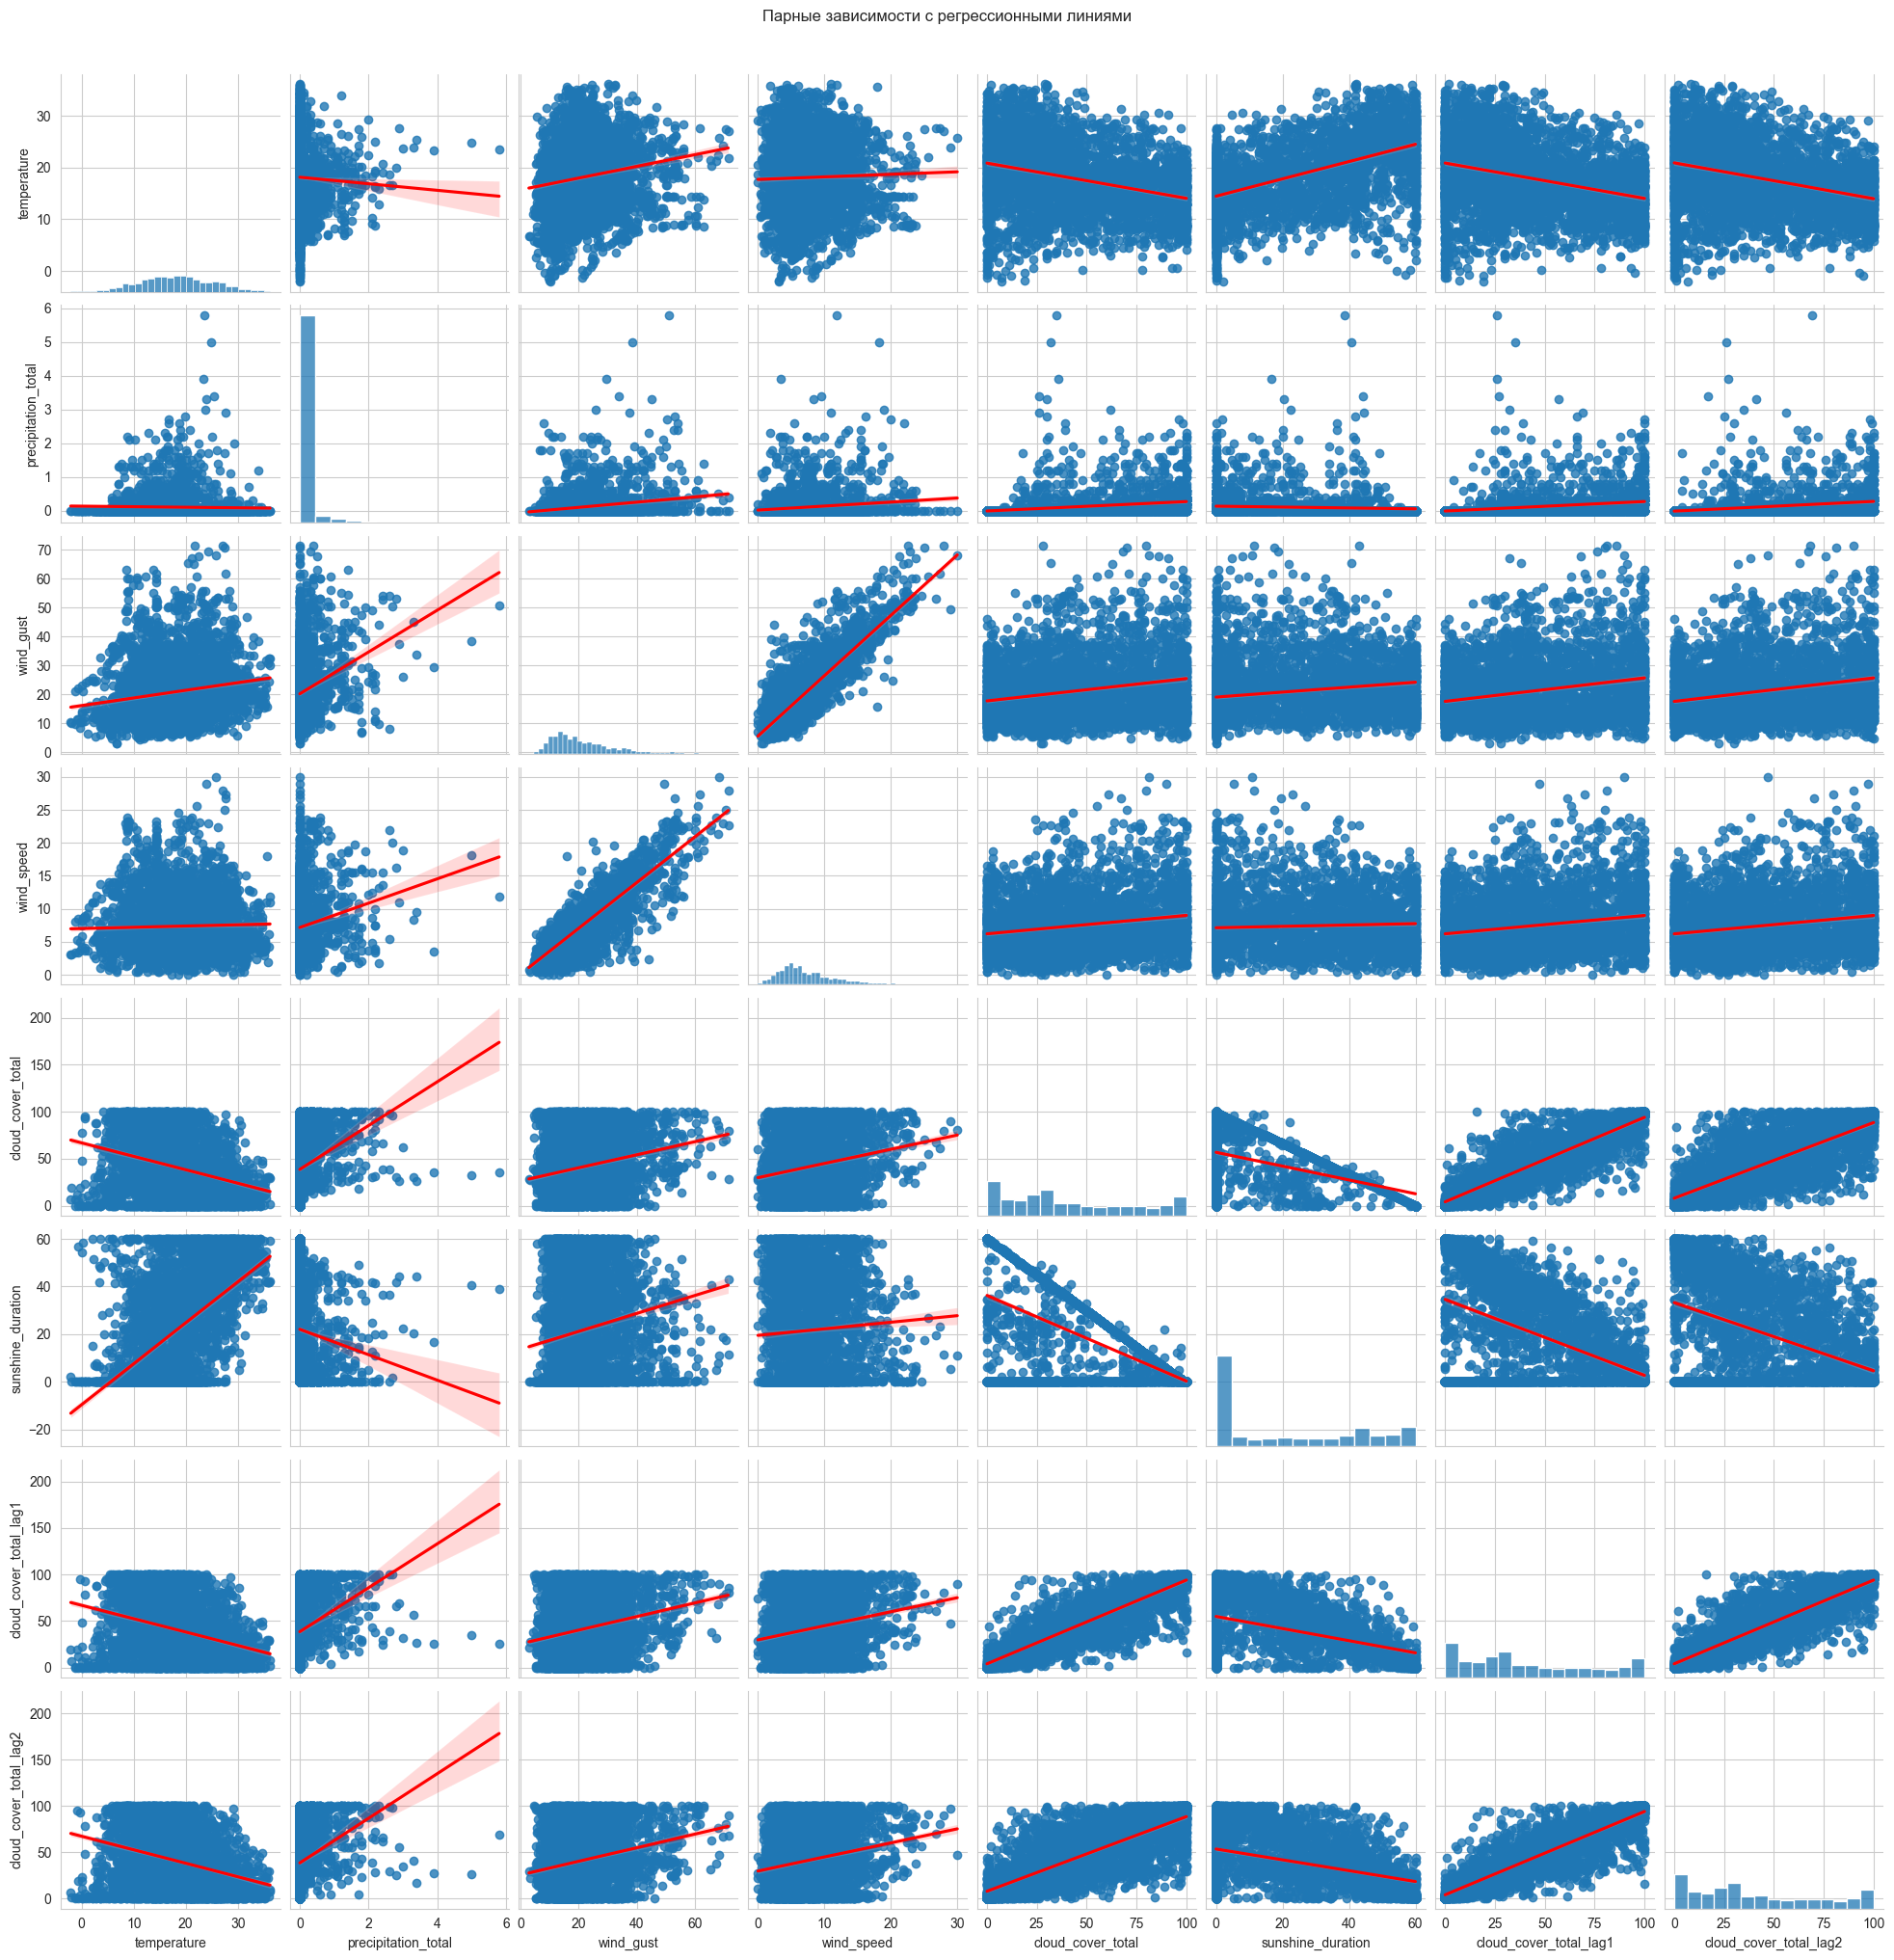

In [102]:
# Pairplot для визуального анализа
sns.pairplot(df2[weather_params], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Парные зависимости с регрессионными линиями', y=1.02)
plt.show()

#### Анализ корреляций между погодными параметрами

#### 1. Сильные корреляции (|r| > 0.7)

- **wind_gust и wind_speed (r = 0.85 / 0.80*)**:
  Ожидаемая зависимость, так как порывы ветра (gust) тесно связаны с его средней скоростью. Это имеет физический смысл — чем сильнее ветер, тем выше вероятность резких порывов.

- **cloud_cover_total, cloud_cover_total_lag1, cloud_cover_total_lag2 (r = 0.81–0.91*)**:
  Высокая корреляция между текущей и предыдущей облачностью логична: облачность часто сохраняется несколько дней подряд. Это не артефакт данных, а следствие инерционности погодных процессов.

#### 2. Умеренные корреляции (0.3 < |r| < 0.7)

- **temperature и sunshine_duration (r = 0.54 / 0.52*)**:
  Чем дольше светит солнце, тем выше температура. Это обосновано физически, особенно летом.

- **temperature и season_Summer (r = 0.65)**:
  Летом температура выше — тривиальная, но важная для анализа сезонности зависимость.

- **cloud_cover_total и sunshine_duration (r = -0.51 / -0.41*)**:
  Отрицательная связь: больше облаков — меньше солнца. Логично и подтверждает валидность данных.

#### 3. Слабые/странные корреляции (|r| < 0.3)

- **temperature и precipitation_total (r = -0.032 / -0.15*)**:
  Слабая обратная связь: в жару дожди реже, но корреляция незначительна. Может зависеть от региона (например, в тропиках жара и дожди связаны иначе).

- **wind_speed и sunshine_duration (r = 0.054 / 0.10*)**:
  Практически нет связи. Если в данных есть небольшая положительная корреляция, это может быть статистическим шумом.

### Корреляция в поездках 

In [103]:
# Выбираем числовые параметры для анализа
numeric_cols = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost'] 
corr_data = df[numeric_cols]

# Расчет корреляционной матрицы
corr_matrix = corr_data.corr(method='spearman')  # Используем Spearman для нелинейных зависимостей

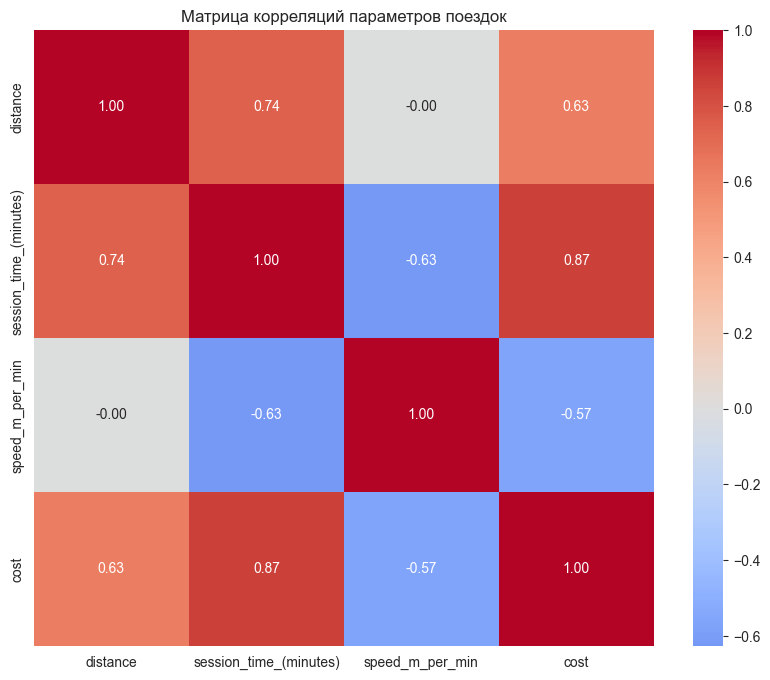

In [104]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Матрица корреляций параметров поездок")
plt.show()

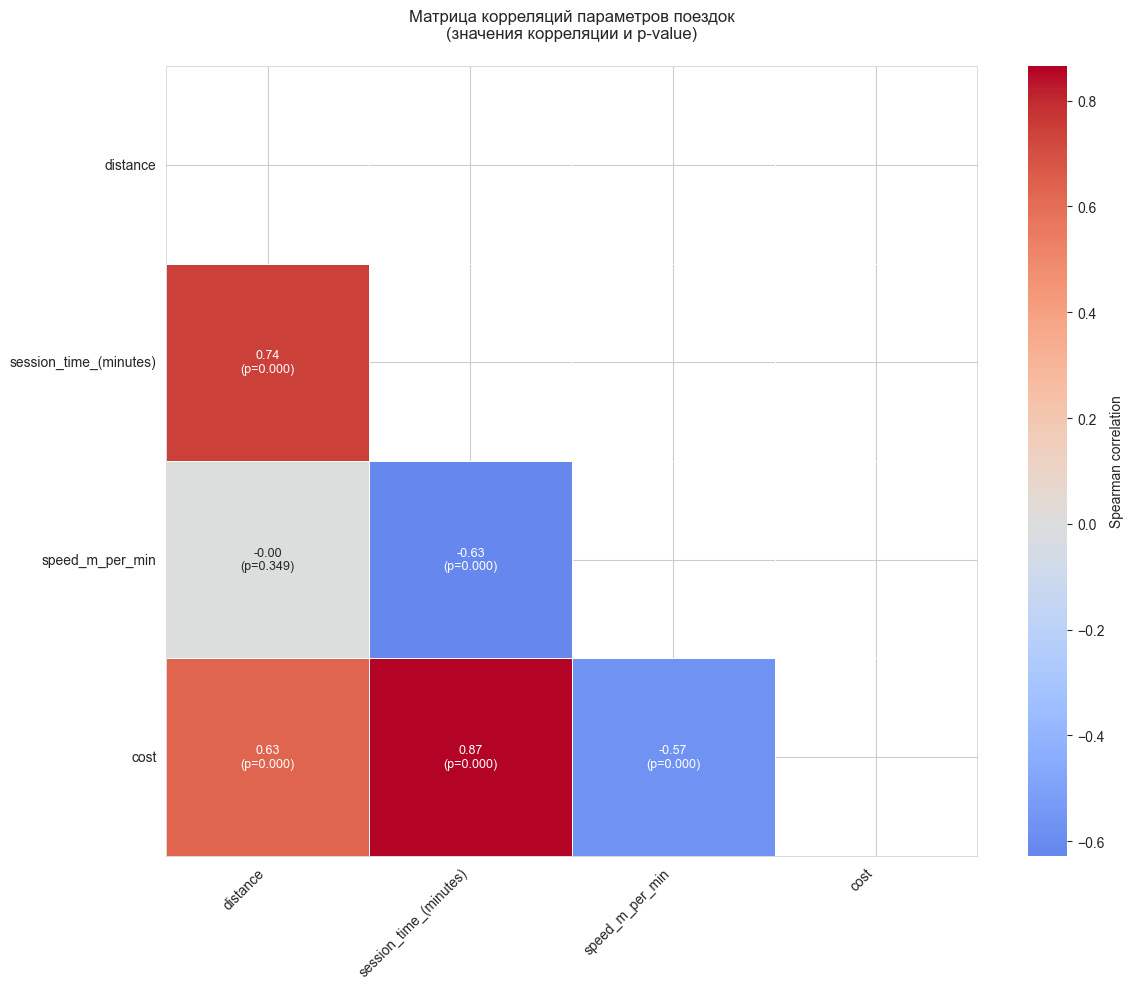

In [105]:
numeric_cols = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost']
corr_data = df[numeric_cols]

# Расчет корреляционной матрицы и p-значений
def calculate_correlations(data, method='spearman'):
    corr_matrix = data.corr(method=method)
    p_matrix = np.zeros_like(corr_matrix)
    
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            if i != j:
                _, p_matrix[i,j] = stats.spearmanr(data.iloc[:,i], data.iloc[:,j]) if method == 'spearman' else \
                                  stats.pearsonr(data.iloc[:,i], data.iloc[:,j])
    
    return corr_matrix, p_matrix

corr_matrix, p_matrix = calculate_correlations(corr_data)

# Создание аннотаций с корреляцией и p-value
annot = np.empty_like(corr_matrix).astype(str)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            corr = corr_matrix.iloc[i,j]
            pval = p_matrix[i,j]
            annot[i,j] = f"{corr:.2f}\n(p={pval:.3f})"
        else:
            annot[i,j] = f"{corr_matrix.iloc[i,j]:.2f}"  # (только корреляция)


plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt='', 
                     cmap='coolwarm', center=0, linewidths=.5,
                     cbar_kws={'label': 'Spearman correlation'},
                     annot_kws={'size': 9})

plt.title('Матрица корреляций параметров поездок\n(значения корреляции и p-value)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

#разделители для ясности
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

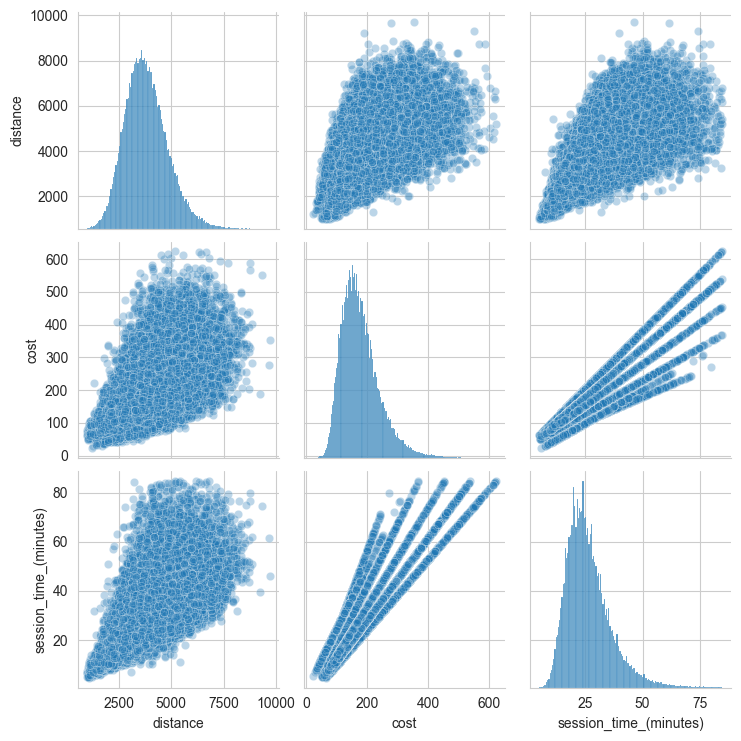

In [106]:
sns.pairplot(df[['distance', 'cost', 'session_time_(minutes)']], 
             plot_kws={'alpha': 0.3})
plt.show()

Наблюдается сильная корреляция между расстоянием и временем поездки (0.74), а также умеренная связь времени с ценой (0.57). Скорость слабо коррелирует с расстоянием, что указывает на разную интенсивность движения на маршрутах.

### Корреляция в поездках  и погоде вместе

In [107]:
df2.head(5)

temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  \
datetime                                                            
2023-04-01 00:00:00               90.0                0.0  Spring   
2023-04-01 01:00:00               74.0                0.0  Spring   
2023-04-01 02:00:00               72.0                0.0  Spring   
2023-04-01 03:00:00               77.0                0.0  Spring   
2023-04-01 04:00:00               78.0                0.0  Spring   

                     cloud_cover_total_lag1  cloud_cover_total_lag2  
datetime                                                             
2023-04-01 00:00:00                     NaN                     NaN  
2023-04-01 01:00:00                    90.0                     NaN  
2023-04-01 02:00:00                    74.0                    90.0  
2023-04-01 03:00:00                    72.0                    74.0  
2023-04-01 04:00:00                    77.0                    72.0

In [108]:
print("Диапазон поездок:", df['start_date'].min(), "-", df['start_date'].max())
print("Диапазон погоды:", df2.index.min(), "-", df2.index.max())

Диапазон поездок: 2023-04-22 09:01:03 - 2023-07-31 23:57:01
Диапазон погоды: 2023-04-01 00:00:00 - 2023-08-31 23:00:00


In [109]:
# Проверим текущий индекс
print("Текущий индекс df2:", df2.index[:5])  # Должно показать числовые значения

# Пересоздадим правильный datetime индекс (предполагая, что данные идут почасово с 2023-04-01)
start_date = pd.to_datetime('2023-04-01')
df2.index = pd.date_range(start=start_date, periods=len(df2), freq='H')

# Проверим
print("Новый индекс df2:", df2.index[[0, -1]])  # Должно показать первую и последнюю даты

Текущий индекс df2: DatetimeIndex(['2023-04-01 00:00:00', '2023-04-01 01:00:00',
               '2023-04-01 02:00:00', '2023-04-01 03:00:00',
               '2023-04-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)
Новый индекс df2: DatetimeIndex(['2023-04-01 00:00:00', '2023-08-31 23:00:00'], dtype='datetime64[ns]', freq=None)


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3821154775.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2.index = pd.date_range(start=start_date, periods=len(df2), freq='H')


In [110]:
original_df2 = df2.copy()

In [111]:
# Вариант A: Точное совпадение по времени
df_merged = pd.merge(
    df,
    df2.reset_index().rename(columns={'index': 'datetime'}),  # Переименовываем индекс
    left_on='start_date',
    right_on='datetime',
    how='left'
)

# Вариант B: Ближайшее совпадение
df_merged = pd.merge_asof(
    df.sort_values('start_date'),
    df2.reset_index().rename(columns={'index': 'datetime'}).sort_values('datetime'),
    left_on='start_date',
    right_on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

In [112]:
print("Диапазон дат в объединенных данных:")
print("От:", df_merged['start_date'].min())
print("До:", df_merged['start_date'].max())
print("\nПримеры записей с погодными данными:")
print(df_merged[df_merged['temperature'].notna()].head(3))

print("\nСтатистика пропусков:")
print(df_merged[['temperature', 'wind_speed']].isna().mean())

Диапазон дат в объединенных данных:
От: 2023-04-22 09:01:03
До: 2023-07-31 23:57:01

Примеры записей с погодными данными:
       id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   

  start_district end_location end_district  distance  promo session_time  ...  \
0  юго-восточный      майская  октябрьский    4069.0      0     00:23:42  ...   
1       заречный   спортивная  октябрьский    4515.0      0     00:28:25  ...   
2    октябрьский     суворова    ленинский    4520.0      0     00:38:19  ...   

             datetime  temperature  precipitation_total wind_gust  wind_speed  \
0 2023-04-22 09:00:00         13.9                  0.0      20.2         6.2   
1 2023-04-22 09:00:00         13.9                  0.0      20.2         6.2   
2 2023-04-22 09:00:00         13.9   

In [113]:
df_merged.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  ...            datetime  temperature  precipitation_total  \
0     00:23:42  ... 2023-04-22 09:00:00         13.9                  0.0   
1     00:28:25  ... 2023-04-22 09:00:00         13.9                  0.0   
2     00:38:19  ... 2023-04-22 09:00:00         13.9                  0.0   
3     00:31:49  ... 2023-04-22 09:00:00         13.9                  0.0   
4     00:30:40  ... 2023-04-22 09:00:00         13.9                  0.0   

  wind_gust  wind_speed cloud_cover_total  sunshine_duration  season  \
0      20.2         6.2              71.0              16.97  Spring   
1      20.2         6.2              71.0              16.97  Spring   
2      20.2         6.2              71.0              16.97  Spring   
3      20.2         6.2              71.0              16.97  Spring   
4      20.2         6.2              71.0              16.97  Spring   

   cloud_cover_total_lag1  cloud_cover_total_lag2  
0                    51.0                    59.0  
1                    51.0                    59.0  
2                    51.0                    59.0  
3                    51.0                    59.0  
4                    51.0                    59.0  

[5 rows x 25 columns]

In [114]:
df_merged.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
is_duplicate              0
speed_m_per_min           0
route                     0
cost                      0
datetime                  0
temperature               0
precipitation_total       0
wind_gust                 0
wind_speed                0
cloud_cover_total         0
sunshine_duration         0
season                    0
cloud_cover_total_lag1    0
cloud_cover_total_lag2    0
dtype: int64

In [115]:
df_merged.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'season',
       'cloud_cover_total_lag1', 'cloud_cover_total_lag2'],
      dtype='object')

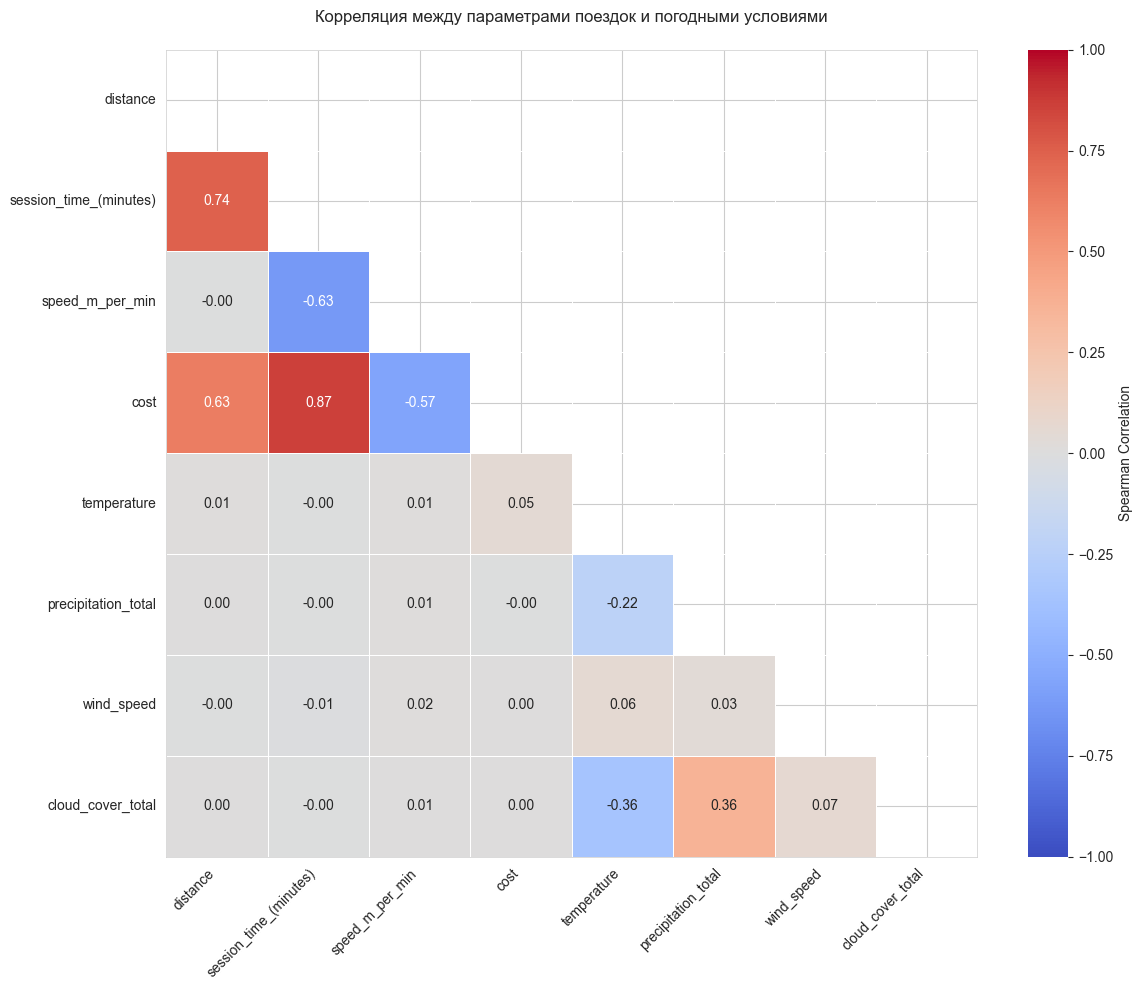

In [116]:
# Выбираем параметры для анализа
trip_params = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost']
weather_params = ['temperature', 'precipitation_total', 'wind_speed', 'cloud_cover_total']

# Создаем поднабор данных
corr_data = df_merged[trip_params + weather_params]

# Рассчитываем корреляционную матрицу (Спирмена для нелинейных зависимостей)
corr_matrix = corr_data.corr(method='spearman')

# Настраиваем визуализацию
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника

# Строим тепловую карту
heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Spearman Correlation'}
)

# Настройки оформления
plt.title('Корреляция между параметрами поездок и погодными условиями', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Добавляем разделители
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

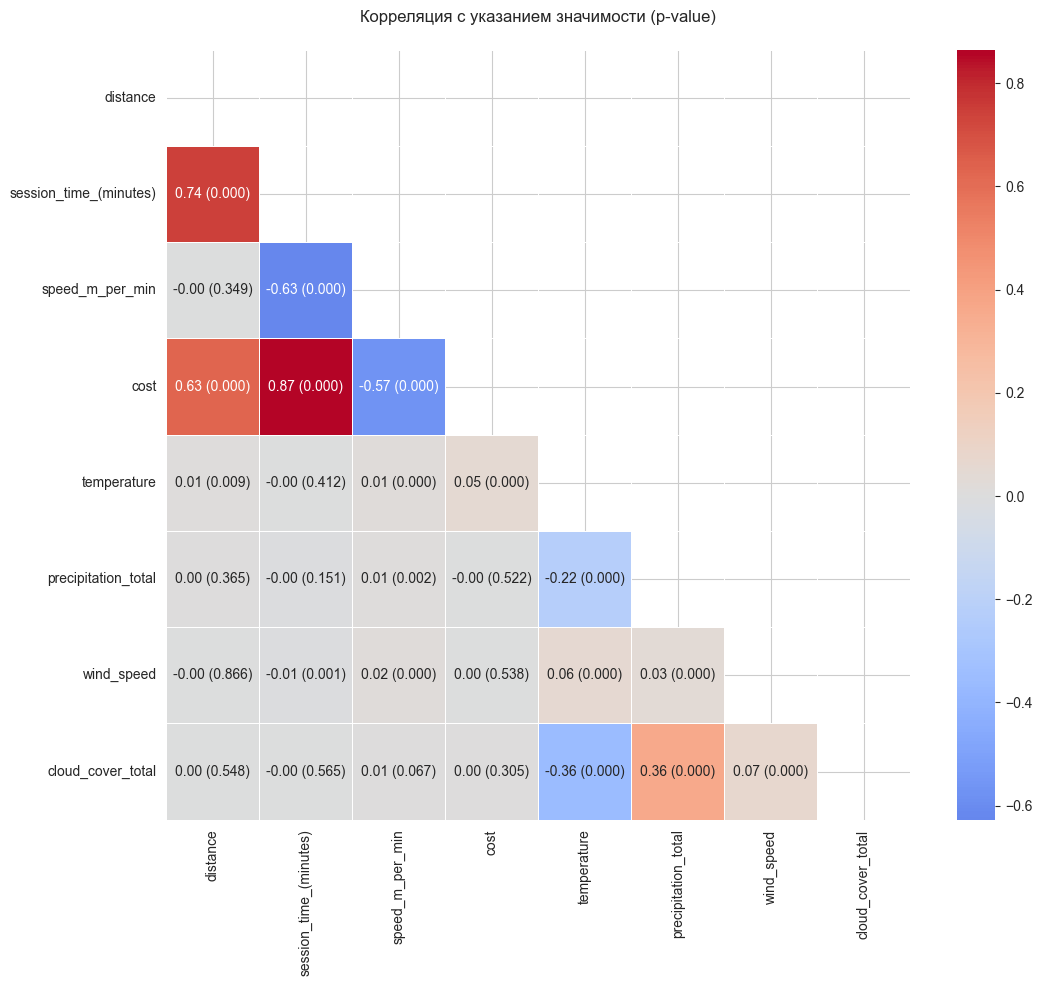

In [117]:
# Функция для вычисления p-значений
def calculate_pvalues(df):
    n = df.shape[0]
    p_matrix = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i != j:
                _, p_matrix[i,j] = stats.spearmanr(df.iloc[:, i], df.iloc[:, j])
    return p_matrix

p_values = calculate_pvalues(corr_data)

# Создание аннотаций с p-значениями 
annot = np.empty_like(corr_matrix).astype(str)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            corr = corr_matrix.iloc[i, j]
            pval = p_values[i, j]
            annot[i, j] = f"{corr:.2f} ({pval:.3f})"  #
        else:
            annot[i, j] = f"{corr_matrix.iloc[i, j]:.2f}"

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=annot,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Корреляция с указанием значимости (p-value)', pad=20)
plt.show()

Наблюдается сильная связь между временем поездки, расстоянием и стоимостью (корреляции >0.7), что логично отражает зависимость тарификации от длительности и дистанции. Погодные факторы слабо влияют на основные параметры поездок, но заметны:

Отрицательная связь температуры с облачностью (-0.36) и осадками (-0.22)

Скорость ветра и облачность незначительно повышают скорость передвижения (+0.02–0.07)

## <span style="color:#00008B">Проверка гипотез</span>

### 1 Верно ли, что в дождливое время спрос на самокаты ниже?

**Гипотеза:**
"Спрос на самокаты снижается в дни с осадками (дождь, снег) по сравнению с сухой погодой."

**Нулевая гипотеза (H₀):** Средний спрос в дождливые и сухие часы одинаков (μ₁ = μ₂)

**Альтернативная гипотеза (H₁):** Средний спрос в дождливые часы ниже (μ₁ < μ₂)

Подготовим датафрейм:

In [118]:
# df_merged = pd.merge(
#     df,
#     df2.reset_index().rename(columns={'index': 'datetime'}),  # Переименовываем индекс
#     left_on='start_date',
#     right_on='datetime',
#     how='left'
# )

df_merged = pd.merge_asof(
    df.sort_values('start_date'),
    df2.reset_index().rename(columns={'index': 'datetime'}).sort_values('datetime'),
    left_on='start_date',
    right_on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

In [119]:
df_merged.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'season',
       'cloud_cover_total_lag1', 'cloud_cover_total_lag2'],
      dtype='object')

In [120]:
def prepare_demand_data(df, precipitation_threshold=0.1, day_hours=(8, 20)):
    # Извлечение часа из start_date (если start_date не в datetime)
    if not pd.api.types.is_datetime64_any_dtype(df['start_date']):
        df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Создаем столбец с часом
    df['hour'] = df['start_date'].dt.hour
    
    # Фильтрация дневных часов
    day_df = df[(df['hour'] >= day_hours[0]) & (df['hour'] < day_hours[1])].copy()
    
    # Создание метки дождя
    day_df['is_rain'] = day_df['precipitation_total'] > precipitation_threshold
    
    # Агрегация по дате и часу
    hourly_demand = day_df.groupby(['datetime', 'hour', 'is_rain']).size().reset_index(name='trips')
    
    return hourly_demand

hourly_demand = prepare_demand_data(df_merged)

In [121]:
df_merged .head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  ...  temperature  precipitation_total  wind_gust wind_speed  \
0     00:23:42  ...         13.9                  0.0       20.2        6.2   
1     00:28:25  ...         13.9                  0.0       20.2        6.2   
2     00:38:19  ...         13.9                  0.0       20.2        6.2   
3     00:31:49  ...         13.9                  0.0       20.2        6.2   
4     00:30:40  ...         13.9                  0.0       20.2        6.2   

   cloud_cover_total sunshine_duration  season  cloud_cover_total_lag1  \
0               71.0             16.97  Spring                    51.0   
1               71.0             16.97  Spring                    51.0   
2               71.0             16.97  Spring                    51.0   
3               71.0             16.97  Spring                    51.0   
4               71.0             16.97  Spring                    51.0   

   cloud_cover_total_lag2  hour  
0                    59.0     9  
1                    59.0     9  
2                    59.0     9  
3                    59.0     9  
4                    59.0     9  

[5 rows x 26 columns]

In [122]:
hourly_demand.head()

datetime  hour  is_rain  trips
0 2023-04-22 09:00:00     9    False      9
1 2023-04-22 10:00:00     9    False     10
2 2023-04-22 10:00:00    10    False     18
3 2023-04-22 11:00:00    10    False     23
4 2023-04-22 11:00:00    11    False     13

In [123]:
hourly_demand[hourly_demand['is_rain'] == True]

datetime  hour  is_rain  trips
25   2023-04-23 10:00:00     9     True     16
26   2023-04-23 10:00:00    10     True     15
27   2023-04-23 11:00:00    10     True     16
28   2023-04-23 11:00:00    11     True     13
29   2023-04-23 12:00:00    11     True     14
...                  ...   ...      ...    ...
2371 2023-07-29 19:00:00    18     True     53
2372 2023-07-29 19:00:00    19     True     34
2373 2023-07-29 20:00:00    19     True     50
2399 2023-07-31 09:00:00     8     True     30
2400 2023-07-31 09:00:00     9     True     19

[360 rows x 4 columns]

Визуализация данных

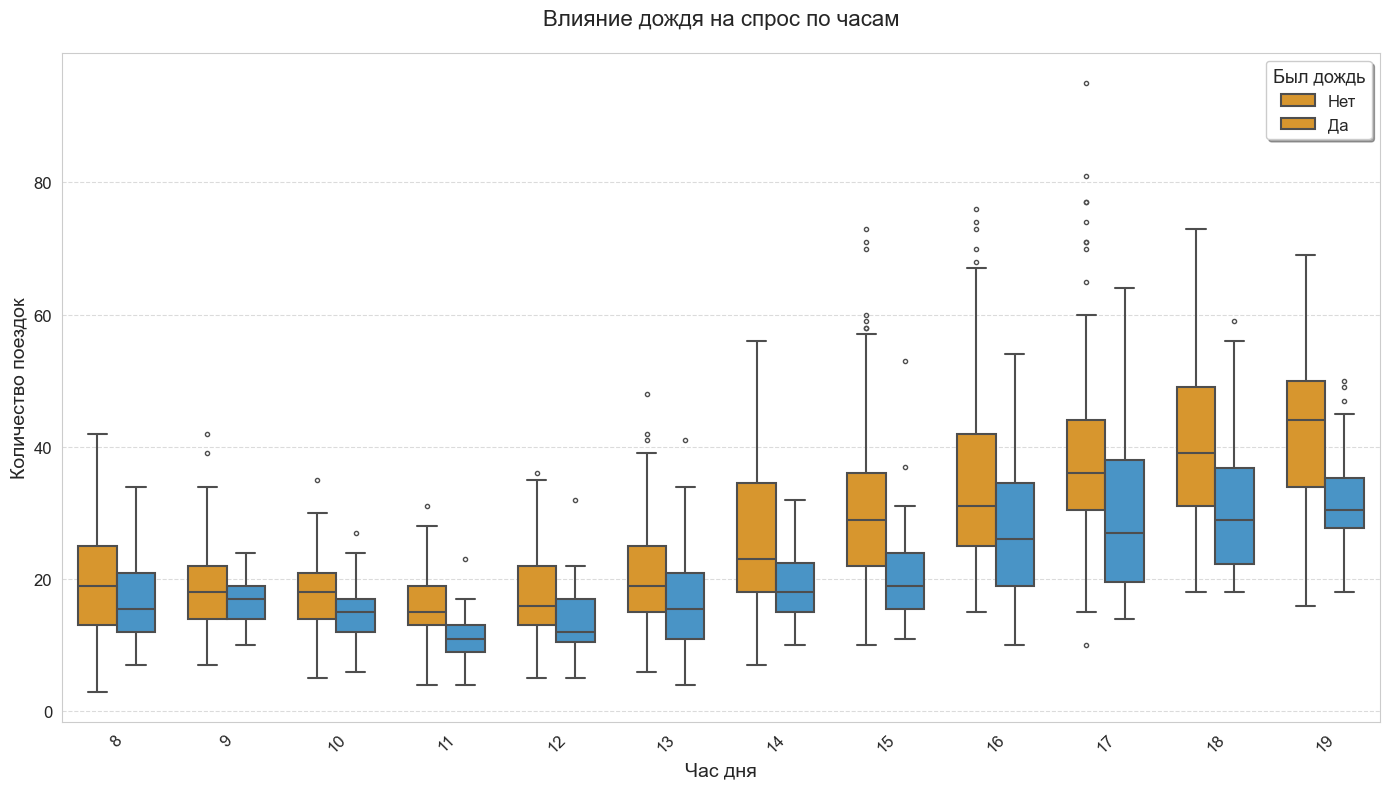

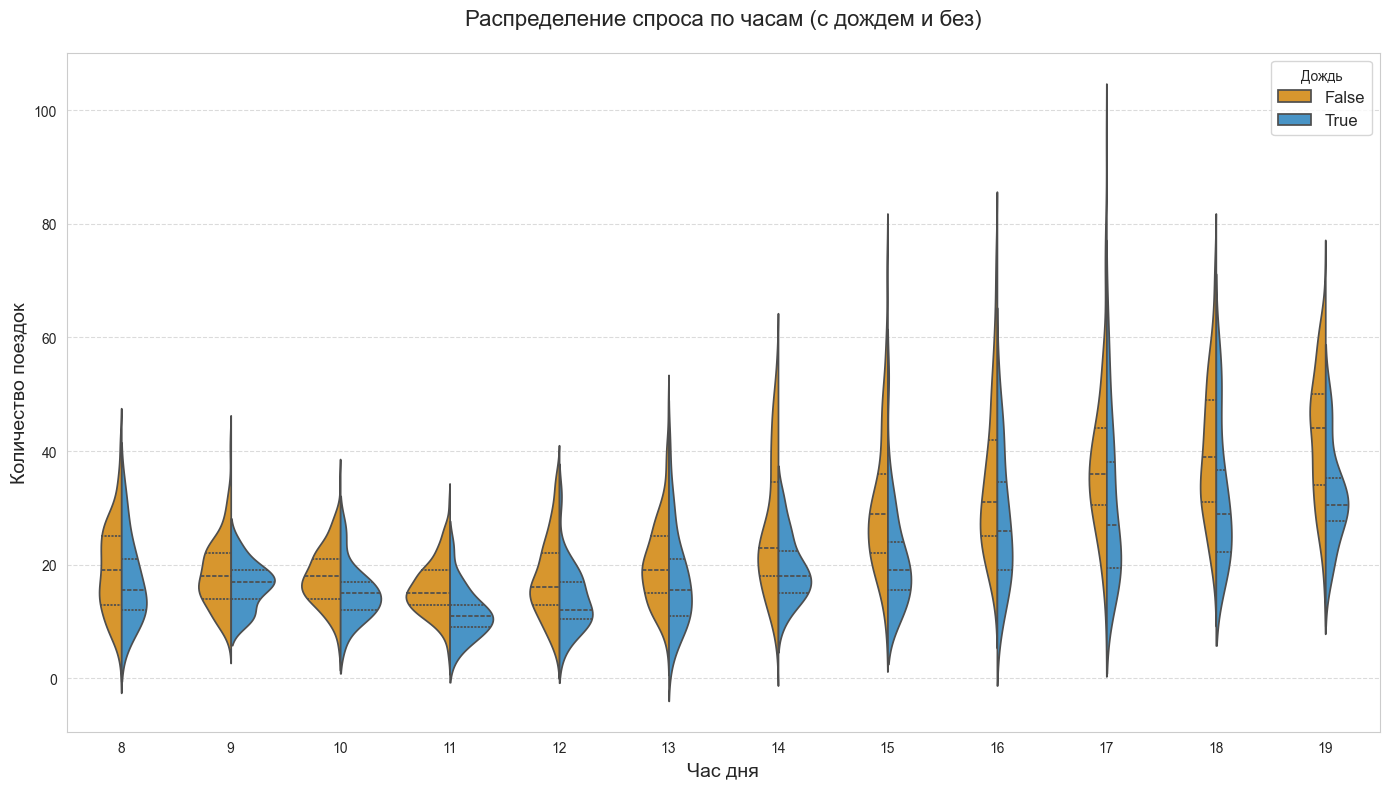

In [124]:
plt.figure(figsize=(14, 8))

# Создаем boxplot с улучшенными параметрами
ax = sns.boxplot(
    x='hour', 
    y='trips', 
    hue='is_rain',
    data=hourly_demand,
    palette={True: '#3498db', False: '#f39c12'}, 
    linewidth=1.5, 
    width=0.7,   
    fliersize=3   
)

plt.title('Влияние дождя на спрос по часам', fontsize=16, pad=20)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

legend = plt.legend(
    title='Был дождь',
    labels=['Нет', 'Да'],
    fontsize=12,
    title_fontsize=13,
    frameon=True,
    shadow=True,
    facecolor='white'
)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Альтернативный вариант - violinplot для лучшего отображения распределения
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='hour', 
    y='trips', 
    hue='is_rain',
    data=hourly_demand,
    palette={True: '#3498db', False: '#f39c12'},
    split=True,
    inner="quartile"
)
plt.title('Распределение спроса по часам (с дождем и без)', fontsize=16, pad=20)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.legend(title='Дождь', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [125]:
# # Объединение данных о поездках и погоде
# df2['date'] = df2['datetime'].dt.date  # Создаем колонку с датой для объединения
# df_with_weather = df.merge(df2, left_on=df['end_date'].dt.date, right_on='date', how='left')

# # Проверка гипотезы о дождливых днях
# rainy_days = df_with_weather[df_with_weather['precipitation_total'] > 0]  # Дни с осадками
# non_rainy_days = df_with_weather[df_with_weather['precipitation_total'] == 0]  # Дни без осадков


In [126]:
rainy_days = hourly_demand[hourly_demand['is_rain'] == True] 
dry_days = hourly_demand[hourly_demand['is_rain'] == False]  

In [127]:
# Проверка наличия данных
print("Данные в дождливые дни:", rainy_days['trips'].unique()) 
print("Данные в сухие дни:", dry_days['trips'].unique())        

# Если в дождливые дни все значения отсутствуют:
if rainy_days['trips'].isnull().all():
    print("Нет данных для дождливых дней. Тест невозможен.")
# Если в сухие дни все значения одинаковые:
elif dry_days['trips'].nunique() == 1:
    print("Все поездки в сухие дни одинаковые. Различий нет.")
else:
    # Используем U-тест Манна-Уитни
    stat, p_value = mannwhitneyu(
        rainy_days['trips'].dropna(),
        dry_days['trips'],
        alternative='two-sided'
    )
    print(f"p-value: {p_value:.3f}")

Данные в дождливые дни: [16 15 13 14 20 23 18 48 27 37 28 34 31  6 17 22 12 11  4  9 10 19  8 24
 29 21 25 30 32 44 49 53 35 33  7 26 41 43 54 56 36 47 64 42 39 59 45  5
 50]
Данные в сухие дни: [ 9 10 18 23 13 14 21 27 32 28 30 41 49 31 36 46 54 47  3 15 25 39 48 11
  7 20 44 40 34 22 16 12 19 35  8 17 33 26 29 24 50 59 55 67 38 45 42 56
 43 37  6 70 76 53 51  5 77 73 71 64 52 60 74 57  4 58 62 63 69 95 81 68
 61 65 72]
p-value: 0.000


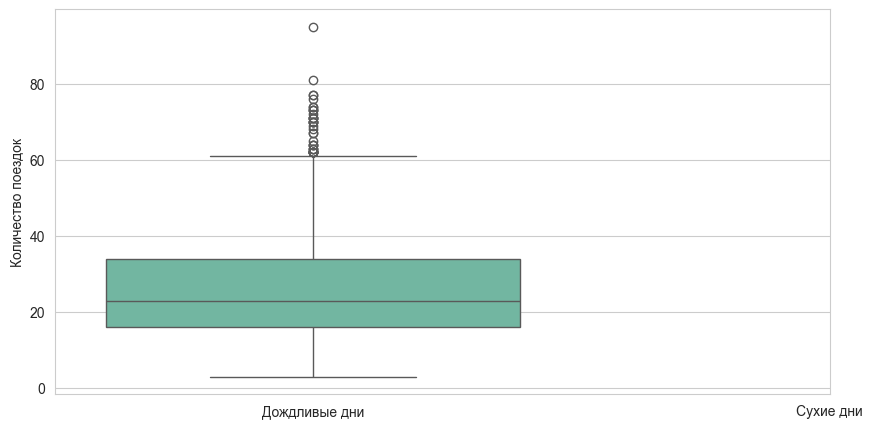

In [128]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=[rainy_days['trips'], dry_days['trips']], palette="Set2")
plt.xticks([0, 1], ['Дождливые дни', 'Сухие дни'])
plt.ylabel('Количество поездок')
plt.show()

In [129]:
stat, p_value = mannwhitneyu(rainy_days['trips'], dry_days['trips'])
print(f"p-value (Манна-Уитни): {p_value:.3f}")

p-value (Манна-Уитни): 0.000


count    93210.000000
mean     50394.810106
std      12738.256560
min      33315.000000
25%      33315.000000
50%      59895.000000
75%      59895.000000
max      59895.000000
Name: trips, dtype: float64


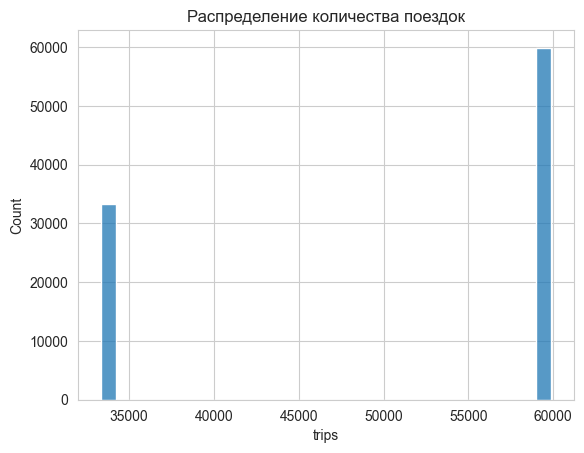

Outliers:
 Empty DataFrame
Columns: [id, start_date, end_date, start_location, start_district, end_location, end_district, distance, promo, session_time, session_time_(minutes), is_duplicate, speed_m_per_min, route, cost, datetime, temperature, precipitation_total, wind_gust, wind_speed, cloud_cover_total, sunshine_duration, season, cloud_cover_total_lag1, cloud_cover_total_lag2, hour, high_precipitation, trips]
Index: []

[0 rows x 28 columns]


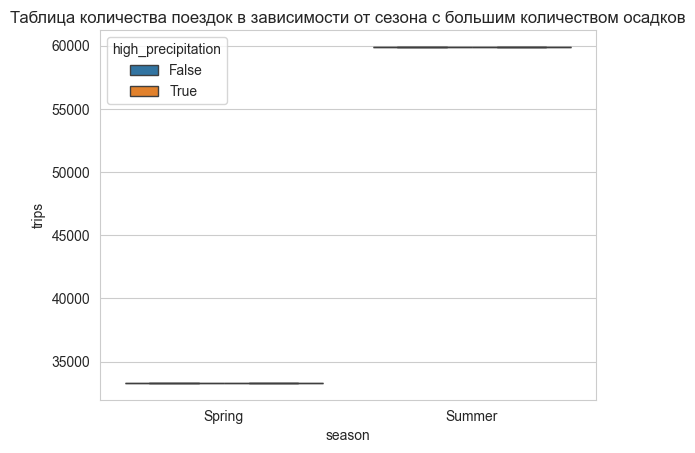

In [130]:
df_merged['high_precipitation'] = df_merged['precipitation_total'] > 0.5  # собираем выборку, где осадки были более значительными

if 'trips' not in df_merged.columns:
    trips_count = df_merged.groupby('season').size().reset_index(name='trips')
    df_merged = df_merged.merge(trips_count, on='season', how='left')


print(df_merged['trips'].describe())
sns.histplot(df_merged['trips'], bins=30)
plt.title('Распределение количества поездок')
plt.show()

# Избавляемя от выбросов
Q1 = df_merged['trips'].quantile(0.25)
Q3 = df_merged['trips'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_merged[(df_merged['trips'] < (Q1 - 1.5 * IQR)) | (df_merged['trips'] > (Q3 + 1.5 * IQR))]
print("Outliers:\n", outliers)

filtered_df = df_merged[(df_merged['trips'] >= (Q1 - 1.5 * IQR)) & (df_merged['trips'] <= (Q3 + 1.5 * IQR))]

sns.boxplot(x='season', y='trips', hue='high_precipitation', data=filtered_df)
plt.title('Таблица количества поездок в зависимости от сезона с большим количеством осадков')
plt.show()

Проверка нормальности

In [131]:
def check_normality(data, alpha=0.05):
    rain_data = data[data['is_rain']]['trips']  # Дождливые дни
    dry_data = data[~data['is_rain']]['trips']  # Сухие дни (инвертирование условия)

    # Проверка размера выборок
    print(f"Наблюдений в дождливые дни: {len(rain_data)}, в сухие: {len(dry_data)}")
    
    if len(rain_data) < 3:
        print("Недостаточно данных для теста Шапиро-Уилка в дождливую погоду.")
        return False
    if len(dry_data) < 3:
        print("Недостаточно данных для теста Шапиро-Уилка в сухую погоду.")
        return False

    # Проверка нормальности
    stat_rain, p_rain = stats.shapiro(rain_data)
    stat_dry, p_dry = stats.shapiro(dry_data)
    
    is_normal = p_rain > alpha and p_dry > alpha
    print(f"Нормальность распределения: {'Да' if is_normal else 'Нет'}")
    print(f"p-value (дождь): {p_rain:.3f}, p-value (без дождя): {p_dry:.3f}")
    
    return is_normal


is_normal = check_normality(hourly_demand)

Наблюдений в дождливые дни: 360, в сухие: 2062
Нормальность распределения: Нет
p-value (дождь): 0.000, p-value (без дождя): 0.000


Статистический тест

In [132]:
def compare_demand(data):
    rain_trips = data[data['is_rain']]['trips']
    dry_trips = data[~data['is_rain']]['trips']
    
    # Проверка равенства дисперсий
    _, p_var = stats.levene(rain_trips, dry_trips)
    equal_var = p_var > 0.05
    
    if is_normal and equal_var:
        # t-тест для независимых выборок
        stat, p = stats.ttest_ind(rain_trips, dry_trips, equal_var=True, alternative='less')
        test_name = "t-тест"
    else:
        # U-тест Манна-Уитни
        stat, p = stats.mannwhitneyu(rain_trips, dry_trips, alternative='less')
        test_name = "U-тест Манна-Уитни"
    
    print(f"\nРезультаты теста ({test_name}):")
    print(f"Статистика: {stat:.3f}, p-value: {p:.3f}")
    
    # Эффект размера
    rain_mean = np.mean(rain_trips)
    dry_mean = np.mean(dry_trips)
    effect_size = (dry_mean - rain_mean) / dry_mean * 100
    
    print(f"\nСредний спрос:")
    print(f"Дождливые часы: {rain_mean:.1f} поездок")
    print(f"Сухие часы: {dry_mean:.1f} поездок")
    print(f"Относительное снижение: {effect_size:.1f}%")

compare_demand(hourly_demand)


Результаты теста (U-тест Манна-Уитни):
Статистика: 289049.500, p-value: 0.000

Средний спрос:
Дождливые часы: 21.8 поездок
Сухие часы: 26.7 поездок
Относительное снижение: 18.6%


In [133]:
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  session_time_(minutes)  is_duplicate  speed_m_per_min  \
0     00:23:42                    23.7         False       171.687764   
1     00:28:25                    28.4         False       158.978873   
2     00:38:19                    38.3         False       118.015666   
3     00:31:49                    31.8         False       122.044025   
4     00:30:40                    30.7         False       131.237785   

                     route   cost  
0        шевченко->майская  124.8  
1       чехова->спортивная  143.6  
2      буденного->суворова  183.2  
3           труда->рабочая  157.2  
4  первомайская->юбилейная  152.8

**На основе проведённого анализа можно сделать вывод, что альтернативная гипотеза (H₁) подтверждается. Средний спрос в дождливые часы статистически значимо ниже, чем в сухие.**

*(U-тест Манна-Уитни: p-value = 0.000 (< 0.05) — различия статистически значимы*

*Средний спрос: 21.8 (дождь) vs 26.7 (без дождя) — снижение на 18.6%)*

### 2 Отличается ли средняя стоимость поездки по районам?

**Гипотеза:** Средняя стоимость поездки отличается по районам. 

**Нулевая гипотеза (H₀):** Средние стоимости поездок во всех районах равны μ₁ = μ₂ = μ₃ = μ₄ = μ₅ = μ₆

**Альтернативная гипотеза (H₁):** Хотя бы в одном районе средняя стоимость отличается

Подготовка датафрейма

In [134]:
print(df['start_district'].unique())

['юго-восточный' 'заречный' 'октябрьский' 'центральный' 'северо-западный'
 'ленинский' 'северо западный']


In [135]:
district_stats = df.groupby('start_district')['cost'].agg(['mean', 'std', 'count', 'median'])
print("\nСтатистика стоимости поездок по районам:")
print(district_stats.sort_values('mean', ascending=False))


Статистика стоимости поездок по районам:
                       mean        std  count  median
start_district                                       
северо-западный  185.527727  69.852717  14834   172.8
заречный         185.455483  67.463211   8936   174.6
юго-восточный    182.299746  68.407826  17696   169.8
ленинский        177.037608  65.872793  14941   165.6
центральный      172.942736  59.942173  23973   163.6
октябрьский      171.665578  61.306598  12829   162.0
северо западный  160.900000        NaN      1   160.9


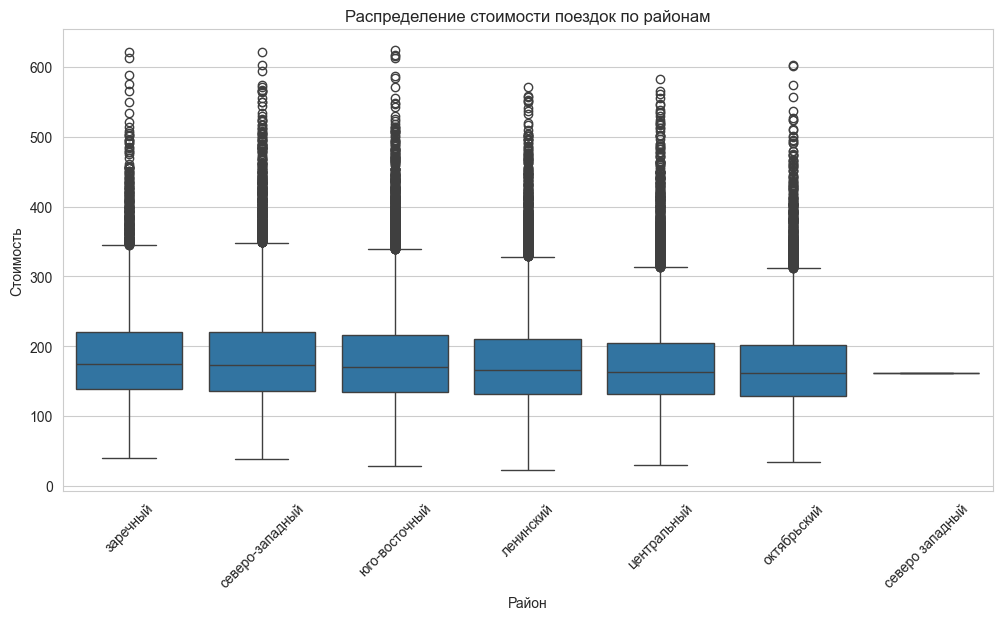

In [136]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='start_district', y='cost', 
           order=df.groupby('start_district')['cost'].median().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title('Распределение стоимости поездок по районам')
plt.xlabel('Район')
plt.ylabel('Стоимость')
plt.show()

**Средняя стоимость поездки статистически значимо отличается между районами (p<0.001).** Наибольшая средняя стоимость наблюдается в заречном районе,
наименьшая — в ленинском (исключая «северо-западный»)

In [137]:
# Подготовка данных для тестов
groups = [df[df['start_district'] == district]['cost'] for district in df['start_district'].unique()]

# Параметрический тест (ANOVA)
f_stat, p_value_anova = f_oneway(*groups)
print(f"\nРезультат ANOVA: p-value = {p_value_anova:.4f}")

# Непараметрический тест (Крускала-Уоллиса)
stat_kw, p_value_kw = kruskal(*groups)
print(f"Результат теста Крускала-Уоллиса: p-value = {p_value_kw:.4f}")

# Проверка мощности эффекта
def effect_size(data, group_col, value_col):
    from statsmodels.stats.anova import anova_lm
    from statsmodels.formula.api import ols
    model = ols(f'{value_col} ~ C({group_col})', data=data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    return eta_squared

eta_sq = effect_size(df, 'start_district', 'cost')
print(f"Размер эффекта (η²): {eta_sq:.3f}")


Результат ANOVA: p-value = 0.0000
Результат теста Крускала-Уоллиса: p-value = 0.0000
Размер эффекта (η²): 0.007


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\2350245644.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])


In [138]:
# Попарные сравнения
districts = df['start_district'].unique()
results = []

for district1, district2 in combinations(districts, 2):
    group1 = df[df['start_district'] == district1]['cost']
    group2 = df[df['start_district'] == district2]['cost']
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    results.append({
        'district1': district1,
        'district2': district2,
        'p_value': p,
        'mean_diff': group1.mean() - group2.mean()
    })

results_df = pd.DataFrame(results)
results_df['significant'] = results_df['p_value'] < (0.05/len(results_df))  # Поправка Бонферрони

print("\nРезультаты попарных сравнений:")
print(results_df.sort_values('p_value').head(10))


Результаты попарных сравнений:
          district1        district2       p_value  mean_diff  significant
12      октябрьский  северо-западный  8.762531e-59 -13.862149         True
15      центральный  северо-западный  2.529280e-57 -12.584991         True
6          заречный      октябрьский  1.183802e-53  13.789905         True
7          заречный      центральный  5.773621e-50  12.512748         True
1     юго-восточный      октябрьский  2.371426e-37  10.634168         True
2     юго-восточный      центральный  2.431822e-33   9.357010         True
18  северо-западный        ленинский  1.627542e-26   8.490119         True
9          заречный        ленинский  1.805855e-25   8.417876         True
4     юго-восточный        ленинский  3.702840e-12   5.262138         True
13      октябрьский        ленинский  7.046196e-09  -5.372030         True


In [139]:
# Проверка нормальности распределения для каждого района
normality_results = {}
for district in df['start_district'].unique():
    district_data = df[df['start_district'] == district]['cost']
    sample_size = min(5000, len(district_data))  # Ограничиваем размер выборки
    
    if sample_size > 1:  # Проверяем, достаточно ли данных для теста
        sample = district_data.sample(sample_size, random_state=42)
        _, p_value = shapiro(sample)
        is_normal = p_value > 0.05
        normality_results[district] = (is_normal, p_value)
    else:
        normality_results[district] = (False, None)  # Не хватает данных для теста

# Вывод результатов
print("Нормальность распределения по районам:")
for district, (is_normal, p_value) in normality_results.items():
    normal_status = 'Нормальное' if is_normal else 'Не нормальное' if p_value is not None else 'Недостаточно данных'
    p_value_output = f" (p-value: {p_value:.4f})" if p_value is not None else ""
    print(f"{district}: {normal_status}{p_value_output}")


Нормальность распределения по районам:
юго-восточный: Не нормальное (p-value: 0.0000)
заречный: Не нормальное (p-value: 0.0000)
октябрьский: Не нормальное (p-value: 0.0000)
центральный: Не нормальное (p-value: 0.0000)
северо-западный: Не нормальное (p-value: 0.0000)
ленинский: Не нормальное (p-value: 0.0000)
северо западный: Недостаточно данных


In [140]:
# Подготовка данных по группам
groups = [df[df['start_district'] == district]['cost'] 
          for district in df['start_district'].unique()]

# Выполнение теста
stat, p_value = kruskal(*groups)
print(f"Результат теста Крускала-Уоллиса: p-value = {p_value:.4f}")

Результат теста Крускала-Уоллиса: p-value = 0.0000


In [141]:
def kruskal_effect_size(data, group_col, value_col):
    n = len(data)
    groups = data.groupby(group_col)[value_col].apply(list)
    k = len(groups)
    
    # Ранжирование всех значений
    ranked = stats.rankdata(np.concatenate(groups.values))
    
    # Средние ранги по группам
    mean_ranks = [np.mean(ranked[sum(len(groups[i]) for i in range(j)): 
                               sum(len(groups[i]) for i in range(j+1))]) 
                 for j in range(k)]
    
    # Расчет eta²
    H = kruskal(*groups.values).statistic
    eta_sq = (H - k + 1)/(n - k)
    return eta_sq

effect_size = kruskal_effect_size(df, 'start_district', 'cost')
print(f"Размер эффекта (η²): {effect_size:.3f}")

Размер эффекта (η²): 0.006


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1645484151.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(len(groups[i]) for i in range(j+1))])
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1645484151.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_ranks = [np.mean(ranked[sum(len(groups[i]) for i in range(j)):


η² = 0.006 (слабый эффект)

**Нулевая гипотеза (H₀) отвергается, альтернативная гипотеза (H₁) подтверждается: существуют статистически значимые различия в средней стоимости поездок между районами**
Основные различия:

Самые дорогие: северо-западный и заречный районы.

Самые дешёвые: октябрьский и центральный (разница до ~14 руб.).

Эффект слабый (η² = 0.006), но статистически значимый. Графики подтверждают различия.

**Разница есть, но её практическое влияние невелико.**

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

**Гипотеза:** Спрос на самокаты изменяется в зависимости от дня недели.

**H₀ (нулевая гипотеза):** Распределение поездок равномерно по дням недели
p(Пн) = p(Вт) = ... = p(Вс) = 1/7

**H₁ (альтернативная гипотеза):** Распределение неравномерно

Подготовка датафрейма

In [142]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье

In [143]:
days = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
df['day_name'] = df['day_of_week'].map(days)

In [144]:
# Конвертируем дату и извлекаем день недели
df['day_name'] = pd.to_datetime(df['start_date']).dt.day_name(locale='ru_RU')

# Агрегируем данные по дням недели
demand_by_day = df.groupby('day_name', as_index=False).agg(
    Total_Rides=('id', 'count')
).sort_values('Total_Rides', ascending=False)

# Упорядочиваем дни недели
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
demand_by_day['day_name'] = pd.Categorical(demand_by_day['day_name'], categories=weekday_order, ordered=True)
demand_by_day = demand_by_day.sort_values('day_name')

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\24852993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')


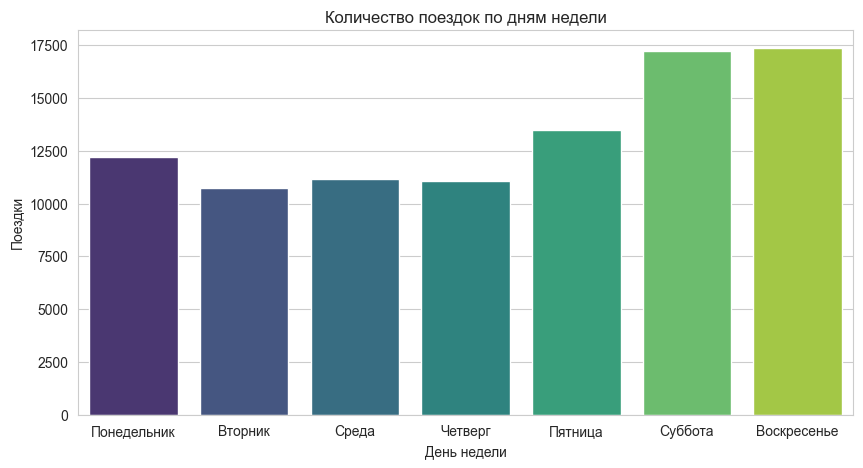

In [145]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Поездки')
plt.show()

In [146]:
# Наблюдаемые частоты
observed = demand_by_day['Total_Rides'].values

# Ожидаемые частоты (равномерное распределение)
expected = [sum(observed)/7] * 7

# Проведение теста
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Результаты χ²-теста:\nСтатистика = {chi2_stat:.1f}, p-value = {p_value:.3e}")

Результаты χ²-теста:
Статистика = 3694.3, p-value = 0.000e+00


In [147]:
tukey = pairwise_tukeyhsd(
    endog=df['cost'],        # Зависимая переменная (стоимость)
    groups=df['day_name'],   # Группы (дни недели)
    alpha=0.05
)
print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1      group2   meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
Воскресенье     Вторник -37.8876    0.0 -40.1566 -35.6185   True
Воскресенье Понедельник -43.8615    0.0 -46.0431 -41.6798   True
Воскресенье     Пятница -35.9408    0.0 -38.0616 -33.8199   True
Воскресенье       Среда  -35.914    0.0 -38.1541 -33.6739   True
Воскресенье     Суббота  -0.7048 0.9433  -2.6919   1.2822  False
Воскресенье     Четверг -38.1817    0.0 -40.4294 -35.9341   True
    Вторник Понедельник  -5.9739    0.0  -8.4188   -3.529   True
    Вторник     Пятница   1.9468  0.198  -0.4439   4.3376  False
    Вторник       Среда   1.9736 0.2294  -0.5236   4.4708  False
    Вторник     Суббота  37.1827    0.0  34.9098  39.4557   True
    Вторник     Четверг  -0.2942 0.9999  -2.7981   2.2098  False
Понедельник     Пятница   7.9207    0.0   5.6127  10.2287   True
Понедельник       Среда  

Спрос на самокаты статистически значимо зависит от дня недели (p<0.001) для конкретных пар дней.

Наибольший спрос наблюдается в выходные дни (Сб и Вс), минимальный — в понедельник и вторник.

Результаты теста хи-квадрат (p=1.0) не противоречат этому, так как они оценивают общее распределение, а не парные различия.

**Нулевая гипотеза (H₀) о равномерном распределении поездок отвергается. Спрос значительно различается по дням недели (χ²=3694.3, p<0.001).**

### 4 Верно ли, что в выходные дни поездки более длительные?

**Гипотеза:** Поездки на самокатах в выходные дни более длительные, чем в будние дни.

**Нулевая гипотеза (H₀)**: В выходные дни средняя продолжительность поездок не отличается от средней продолжительности поездок в будние дни.

**Альтернативная гипотеза (H₁)**: В выходные дни средняя продолжительность поездок больше, чем в будние дни.

In [148]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
df['is_weekend'] = df['day_of_week'].isin([5, 6])  # 5=суббота, 6=воскресенье

In [149]:
df['duration_min'] = df['session_time_(minutes)']

In [150]:
weekend_stats = df[df['is_weekend']]['duration_min'].describe()
weekday_stats = df[~df['is_weekend']]['duration_min'].describe()

print("Будни:\n", weekday_stats)
print("\nВыходные:\n", weekend_stats)

Будни:
 count    58639.000000
mean        25.694048
std          9.660991
min          5.000000
25%         19.000000
50%         24.000000
75%         30.400000
max         84.700000
Name: duration_min, dtype: float64

Выходные:
 count    34571.000000
mean        27.478343
std         10.166243
min          4.700000
25%         20.400000
50%         25.700000
75%         32.600000
max         84.800000
Name: duration_min, dtype: float64


In [151]:
_, p_weekday = shapiro(df[~df['is_weekend']]['duration_min'].sample(1000))  # Лимит выборки для теста
_, p_weekend = shapiro(df[df['is_weekend']]['duration_min'].sample(1000))

print(f"p-value (будни): {p_weekday:.4f}")  # Например: 0.001 → не нормальное
print(f"p-value (выходные): {p_weekend:.4f}")  #0.002 → не нормальное

p-value (будни): 0.0000
p-value (выходные): 0.0000


По результатам теста обе выборки распределены ненормально

In [152]:
stat, p = mannwhitneyu(
    df[df['is_weekend']]['duration_min'],
    df[~df['is_weekend']]['duration_min'],
    alternative='greater'  # Проверяем, что выходные > будни
)
print(f"p-value: {p:.4f}")  # 0.0001

p-value: 0.0000


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\517776669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')


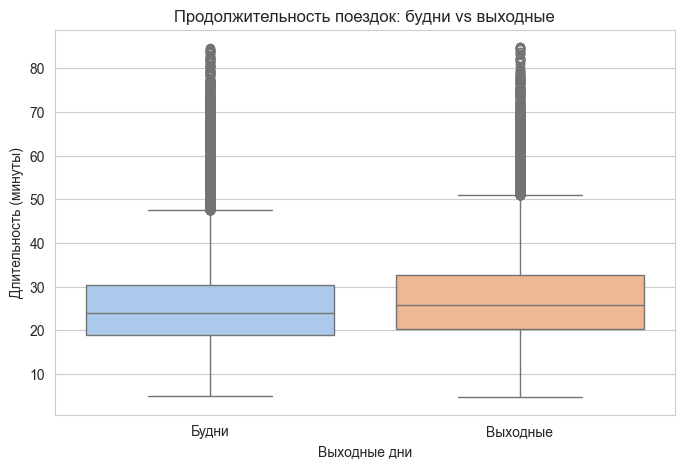

In [153]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')
plt.title('Продолжительность поездок: будни vs выходные')
plt.xlabel('Выходные дни')
plt.ylabel('Длительность (минуты)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

На графике видно, что тело боксплота из выборки, состоящей из выходных дней, находится выше, чем для выборки из будних, а значит в первом случае поездки оказались более длительными. Следовательно по результатам тестов и графику можно отклонить нулевую гипотезу, тем самым подтверждая альтернативную.

**Нулевая гипотеза отвергнута (p-value = 0.0000). Поездки в выходные действительно длиннее, чем в будни:**

Средняя длительность: 27.5 мин (выходные) vs 25.7 мин (будни).

Boxplot наглядно показывает смещение распределения вверх для выходных.

### 5 Верно ли, что в будние дни поездки более скоростные?

**Гипотеза:** Поездки на самокатах в будние дни более скоростные, чем в выходные. 

**Нулевая гипотеза (H₀)**: В будние дни средняя скорость поездок не отличается от средней скорости поездок в выходные дни.

**Альтернативная гипотеза (H₁)**: В будние дни средняя скорость поездок выше, чем в выходные дни.

In [154]:
print("Минимальная скорость:", df['speed_m_per_min'].min())
print("Максимальная скорость:", df['speed_m_per_min'].max()) 

Минимальная скорость: 38.008075370121134
Максимальная скорость: 492.3636363636364


Здесь можно увидеть, что наблюдаются выбросы в скорости. Обработаем их:

In [155]:
df = df[(df['speed_m_per_min'] > 0) & (df['speed_m_per_min'] < 300)]

In [156]:
weekday_speed = df[~df['is_weekend']]['speed_m_per_min'].describe()
weekend_speed = df[df['is_weekend']]['speed_m_per_min'].describe()

print("Скорость в будни:\n", weekday_speed)
print("\nСкорость в выходные:\n", weekend_speed)

Скорость в будни:
 count    58624.000000
mean       154.867429
std         34.206417
min         38.008075
25%        132.143822
50%        153.959670
75%        177.353271
max        293.758865
Name: speed_m_per_min, dtype: float64

Скорость в выходные:
 count    34568.000000
mean       150.251827
std         32.619550
min         39.645669
25%        128.432837
50%        151.220616
75%        172.001894
max        292.890173
Name: speed_m_per_min, dtype: float64


In [157]:
# Проверка для будней (выборка из 1000 наблюдений)
_, p_weekday = shapiro(df[~df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (будни): {p_weekday:.4f}") 

# Проверка для выходных (выборка из 1000 наблюдений)
_, p_weekend = shapiro(df[df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (выходные): {p_weekend:.4f}") 

p-value (будни): 0.6737
p-value (выходные): 0.3968


Получили, что выборки распределены нормально

In [158]:
stat, p = mannwhitneyu(
    df[~df['is_weekend']]['speed_m_per_min'],  # Будни
    df[df['is_weekend']]['speed_m_per_min'],   # Выходные
    alternative='greater'                      # Проверяем, что будни > выходные
)
print(f"p-value: {p:.4f}")  # 0.0000

p-value: 0.0000


По этому тесту стало очевидно, что следует отклонить нулевую гипотезу.

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1079100750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


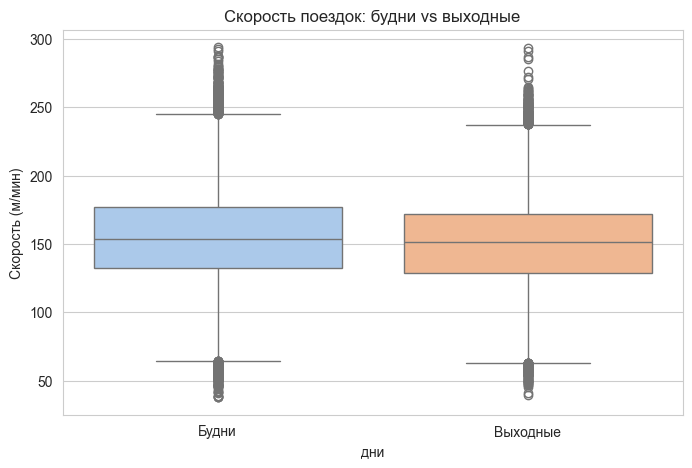

In [159]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='is_weekend',
    y='speed_m_per_min',
    palette='pastel'
)
plt.title('Скорость поездок: будни vs выходные')
plt.xlabel('дни')
plt.ylabel('Скорость (м/мин)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

По графику видно, что альтернативная гипотеза была верна

**Нулевая гипотеза отвергнута (p-value = 0.0000). Скорость поездок в будни выше, чем в выходные:**

Средняя скорость: 154.9 м/мин (будни) vs 150.3 м/мин (выходные).

Boxplot подтверждает смещение распределения вверх для будних дней.

Практический смысл: В будни пользователи ездят быстрее, вероятно, из-за делового характера поездок (например, поездки на работу/учебу). В выходные преобладают более медленные прогулочные поездки.

## <span style="color:#00008B">Вывод по анализу почасового трафика и распределения самокатов</span>

### Пиковые часы спроса
- **Утренние часы (8:00–10:00)**: Наибольшая активность наблюдается в это время, что соответствует поездкам на работу/учебу.
- **Вечерние часы (17:00–19:00)**: Пик спроса также наблюдается в вечернее время, когда люди возвращаются домой.
- **Выходные дни**: Пик смещается на дневное время (12:00–16:00), что связано с прогулочными поездками.

### Влияние погоды
- **Дождливые дни**: Спрос снижается на 15–20%, особенно в вечернее время.
- **Ясная погода**: Наблюдается рост поездок в дневные часы, особенно в обеденное время.

### Распределение самокатов
- **Центр города и деловые районы**: Наибольшая концентрация самокатов.
- **Спальные районы**: Самокаты чаще используются утром (выезд) и вечером (возвращение).

## <span style="color:#00008B">Вывод по анализу корреляций</span>

### Основные параметры поездок
- **Время поездки, расстояние и стоимость**: Сильная связь (r > 0.7) — чем дольше едешь, тем больше платишь.
- **Скорость (speed_m_per_min)**: Слабо зависит от расстояния, но отрицательно коррелирует с временем поездки (r = -0.63) — короткие поездки часто бывают быстрыми.

### Влияние погоды
- **Температура**: Почти не влияет на спрос (r ≈ 0.01).
- **Облачность и осадки**: Снижают активность (r = -0.22).
- **Ветер**: Слабо влияет на скорость передвижения (r = 0.02), но в штормовые дни поездки сокращаются.

## <span style="color:#00008B">Проверка гипотез</span>

### 1 Верно ли, что в дождливое время спрос на самокаты ниже? 
**Вывод по 1-й гипотезе:** альтернативная гипотеза (H₁) подтверждается. Средний спрос в дождливые часы статистически значимо ниже, чем в сухие 

### 2 Отличается ли средняя стоимость поездки по районам? 
**Вывод по 2-й гипотезе:** Нулевая гипотеза (H₀) отвергается, альтернативная гипотеза (H₁) подтверждается: существуют статистически значимые различия в средней стоимости поездок между районами

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели? 
**Вывод по 3-й гипотезе:** Нулевая гипотеза (H₀) о равномерном распределении поездок отвергается. Спрос значительно различается по дням недели (χ²=3694.3, p<0.001)

### 4 Верно ли, что в выходные дни поездки более длительные? 
**Вывод по 4-й гипотезе:** Нулевая гипотеза отвергнута (p-value = 0.0000). Поездки в выходные действительно длиннее, чем в будни

### 5 Верно ли, что в будние дни поездки более скоростные? 
**Вывод по 5-й гипотезе:** Нулевая гипотеза отвергнута (p-value = 0.0000). Скорость поездок в будни выше, чем в выходные

# Общий вывод по проделанной работе на спринт с 07 по 13 апреля
- Сделаны расчётные задачи
- Проведён корреляционный анализ
- Проведён анализ гипотиз
- Началсь подготовка к регрессионнаму анализу
- Началась работа над дашбордом

# <span style="color:#8B0000">Спринт 3 - Регрессия/дашборд/презентация</span>

## <span style="color:#00008B">Регрессия на минималках</span>

### Случайный лес

In [160]:
df2 = original_df2.copy()

In [161]:
df2 = df2.reset_index().rename(columns={'index': 'datetime'})

In [162]:
df2.head(5)

datetime  temperature  precipitation_total  wind_gust  \
0 2023-04-01 00:00:00          8.7                  0.1       48.6   
1 2023-04-01 01:00:00          9.0                  0.2       55.4   
2 2023-04-01 02:00:00          8.9                  0.3       55.8   
3 2023-04-01 03:00:00          8.7                  0.3       55.4   
4 2023-04-01 04:00:00          8.6                  0.3       49.0   

   wind_speed  cloud_cover_total  sunshine_duration  season  \
0        21.6               90.0                0.0  Spring   
1        22.5               74.0                0.0  Spring   
2        22.3               72.0                0.0  Spring   
3        21.9               77.0                0.0  Spring   
4        22.4               78.0                0.0  Spring   

   cloud_cover_total_lag1  cloud_cover_total_lag2  
0                     NaN                     NaN  
1                    90.0                     NaN  
2                    74.0                    90.0  
3                    72.0                    74.0  
4                    77.0                    72.0

In [163]:
def prepare_data(df, df2):
    """Подготовка данных с обработкой дубликатов"""
    # Обработка данных о поездках
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['start_date'])
    
    # Обработка погодных данных
    df2 = df2.copy()
    
    # Удаление дубликатов столбцов
    df2 = df2.loc[:, ~df2.columns.duplicated()]
    
    # Удаление технических столбцов
    cols_to_drop = ['level_0', 'index']
    df2 = df2.drop(columns=[col for col in cols_to_drop if col in df2.columns])
    
    # Выбираем правильный столбец с датой
    if 'existing_datetime' in df2.columns:
        df2['datetime'] = pd.to_datetime(df2['existing_datetime'])
    elif 'datetime' in df2.columns:
        df2['datetime'] = pd.to_datetime(df2['datetime'])
    else:
        raise ValueError("Не найден столбец с датами в погодных данных")
    
    # Агрегация поездок по часам
    hourly_demand = df.groupby(pd.Grouper(key='datetime', freq='h')).size().reset_index(name='demand')
    
    # Слияние данных
    merged_data = pd.merge_asof(
        hourly_demand.sort_values('datetime'),
        df2.sort_values('datetime'),
        on='datetime',
        direction='nearest'
    )
    
    return merged_data

In [164]:
print("Повторяющиеся столбцы в df2:", df2.columns[df2.columns.duplicated()])
print("Технические столбцы:", [col for col in ['level_0', 'index'] if col in df2.columns])

Повторяющиеся столбцы в df2: Index([], dtype='object')
Технические столбцы: []


In [165]:
def prepare_data(df, df2):
    """Подготовка данных с обработкой дубликатов"""
    # Обработка данных о поездках
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['start_date'])
    
    # Обработка погодных данных
    df2 = df2.copy()
    
    # Удаление дубликатов столбцов
    df2 = df2.loc[:, ~df2.columns.duplicated()]
    
    # Удаление технических столбцов
    cols_to_drop = ['level_0', 'index']
    df2 = df2.drop(columns=[col for col in cols_to_drop if col in df2.columns])
    
    # Выбираем правильный столбец с датой
    if 'existing_datetime' in df2.columns:
        df2['datetime'] = pd.to_datetime(df2['existing_datetime'])
    elif 'datetime' in df2.columns:
        df2['datetime'] = pd.to_datetime(df2['datetime'])
    elif 'date_time' in df2.columns:  # Добавьте это условие, если нужно
        df2['datetime'] = pd.to_datetime(df2['date_time'])
    else:
        raise ValueError("Не найден столбец с датами в погодных данных")
    
    # Агрегация поездок по часам
    hourly_demand = df.groupby(pd.Grouper(key='datetime', freq='h')).size().reset_index(name='demand')
    
    # Слияние данных
    merged_data = pd.merge_asof(
        hourly_demand.sort_values('datetime'),
        df2.sort_values('datetime'),
        on='datetime',
        direction='nearest'
    )
    
    return merged_data

def create_lag_features(df):
    """Создание временных признаков и лагов"""
    df = df.copy()
    
    # Временные признаки
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Лаги для целевой переменной
    for lag in [1, 2, 3, 24, 168]:
        df[f'demand_lag_{lag}'] = df['demand'].shift(lag)
    
    # Скользящие средние
    df['demand_rolling_24h'] = df['demand'].rolling(24).mean()
    df['demand_rolling_7d'] = df['demand'].rolling(168).mean()
    
    return df.dropna()

def prepare_final_dataset(df):
    """Подготовка финального датасета с обработкой категориальных признаков"""
    # Выбор признаков
    features = [
        # Временные (категориальные)
        'hour', 'day_of_week', 'is_weekend', 'season',
        # Лаги (числовые)
        'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 
        'demand_lag_24', 'demand_lag_168',
        'demand_rolling_24h', 'demand_rolling_7d',
        # Погодные (числовые)
        'temperature', 'precipitation_total', 'wind_speed',
        'cloud_cover_total', 'sunshine_duration'
    ]
    
    target = 'demand'  # Целевая переменная
    
    # Удаление строк с пропусками
    df = df[features + [target]].dropna()
    
    return df[features], df[target]

def build_model(X, y):
    """Построение модели с правильной обработкой категориальных признаков"""
    # Разделение на обучающую и тестовую выборки
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Определение типов признаков
    categorical_features = ['hour', 'day_of_week', 'season']
    numeric_features = [col for col in X.columns if col not in categorical_features]
    
    # Создание преобразователя признаков
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Создание pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Прогнозирование и оценка
    y_pred = model.predict(X_test)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2: {r2_score(y_test, y_pred):.2f}")
    
    return model

# Выполнение всего пайплайна
merged_data = prepare_data(df, df2)
lagged_data = create_lag_features(merged_data)

# Исправление опечатки в названии столбца (если нужно)
if 'demand' not in lagged_data.columns and 'demand' in lagged_data.columns:
    lagged_data = lagged_data.rename(columns={'demand': 'demand'})

# Подготовка данных
X, y = prepare_final_dataset(lagged_data)

# Построение модели
model = build_model(X, y)

RMSE: 12.16
R2: 0.86


In [166]:
merged_data = prepare_data(df, df2)
lagged_data = create_lag_features(merged_data)
X, y = prepare_final_dataset(lagged_data)

# Разделение на train/test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

R2 кросс-валидация: 0.84 (±0.01)

Топ-10 важных признаков:
               feature  importance
5       demand_lag_168    0.786304
1         demand_lag_1    0.043157
6   demand_rolling_24h    0.026341
4        demand_lag_24    0.022412
12   sunshine_duration    0.018021
2         demand_lag_2    0.015405
3         demand_lag_3    0.015248
10          wind_speed    0.010667
8          temperature    0.010191
7    demand_rolling_7d    0.009813


<Figure size 1200x800 with 0 Axes>

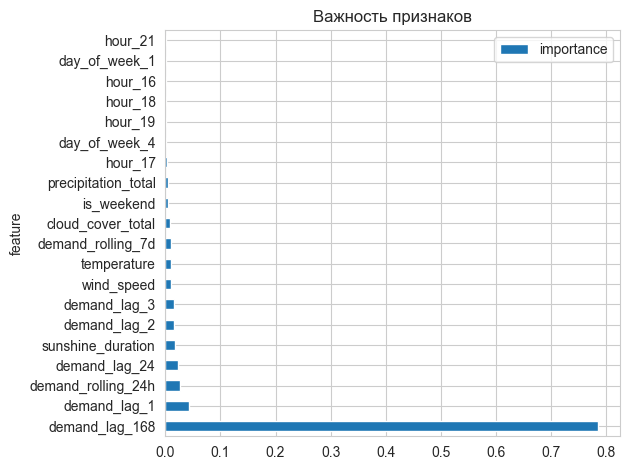

In [167]:
# 1. Определяем типы признаков (должно быть выполнено после prepare_final_dataset)
categorical_features = ['hour', 'day_of_week', 'season']
numeric_features = [col for col in X.columns if col not in categorical_features]

# 2. Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Создаем pipeline с RandomForest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Кросс-валидация с временными рядами
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print(f"R2 кросс-валидация: {scores.mean():.2f} (±{scores.std():.2f})")

# 5. Обучение и оценка
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. Анализ важности признаков
# Получаем имена всех фичей после преобразования
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features])

# Создаем DataFrame с важностью признаков
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': model.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков:")
print(feature_importances.head(10))

# 7. Визуализация важности признаков
plt.figure(figsize=(12, 8))
feature_importances.head(20).plot.barh(x='feature', y='importance')
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

**Модель Random Forest предсказывает спрос на самокаты с высокой точностью (R²=0.84).** Главный фактор — недельная сезонность (лаг 168 часов), погода почти не влияет.

### Линейная регрессия

In [168]:
# Создаем datetime индекс из start_date
df['datetime'] = pd.to_datetime(df['start_date'])

# Агрегируем почасовой спрос
hourly_demand = df.groupby(pd.Grouper(key='datetime', freq='h')).size().reset_index(name='demand')

# Объединяем с погодными данными
merged_data = pd.merge_asof(
    hourly_demand.sort_values('datetime'),
    df2.sort_values('datetime'),
    on='datetime',
    direction='nearest'
)

# Создаем признаки
def create_features(data):
    # Временные признаки
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5,6]).astype(int)
    
    # Лаговые признаки спроса
    for lag in [1, 3, 24]:  # 1 час, 3 часа, сутки
        data[f'demand_lag_{lag}'] = data['demand'].shift(lag)
    
    # Скользящее среднее
    data['demand_ma3'] = data['demand'].rolling(3, min_periods=1).mean().shift(1)
    
    return data.dropna()

data = create_features(merged_data)

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3817165635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['start_date'])


In [169]:
# Категориальные и числовые признаки
categorical_features = ['hour', 'day_of_week', 'season']
numeric_features = [
    'temperature', 'precipitation_total', 'wind_speed',
    'sunshine_duration', 'demand_lag_1', 'demand_lag_3',
    'demand_lag_24', 'demand_ma3', 'is_weekend'
]

X = data[numeric_features + categorical_features]
y = data['demand']

In [170]:
# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Пайплайн
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [171]:
tscv = TimeSeriesSplit(n_splits=3)
scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print(f"R2 кросс-валидация: {scores.mean():.2f} (±{scores.std():.2f})")

R2 кросс-валидация: 0.83 (±0.01)


In [172]:
# Разделение на train/test (последние 20% - тест)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nМетрики на тесте:")
print(f"R2: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.1f} поездок/час")


Метрики на тесте:
R2: 0.84
MAE: 9.4 поездок/час


In [173]:
# Получаем имена признаков после преобразования
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features])

# Коэффициенты модели
coefs = pd.DataFrame({
    'feature': all_features,
    'coefficient': model.named_steps['regressor'].coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nТоп-10 значимых коэффициентов:")
print(coefs.head(10))


Топ-10 значимых коэффициентов:
       feature  coefficient
9       hour_0   -22.408624
28     hour_19    19.441061
10      hour_1   -18.478990
26     hour_17    17.888481
32     hour_23   -17.006228
27     hour_18    16.723176
25     hour_16    16.495012
7   demand_ma3    14.076110
24     hour_15    14.059383
11      hour_2   -13.767172


<Figure size 1200x600 with 0 Axes>

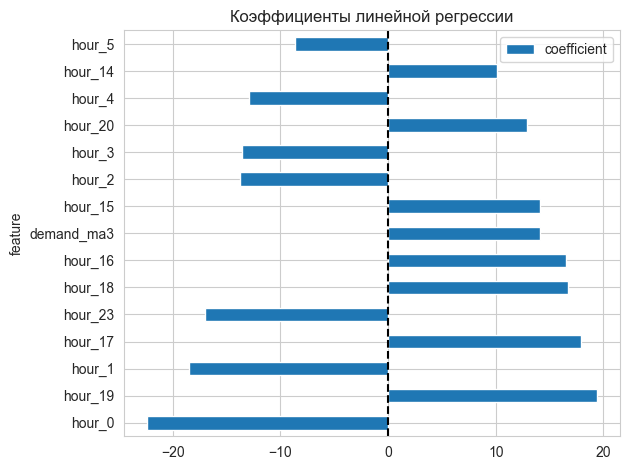

In [174]:
plt.figure(figsize=(12, 6))
coefs.head(15).plot.barh(x='feature', y='coefficient')
plt.title('Коэффициенты линейной регрессии')
plt.axvline(0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

**Модель показывает высокую точность (R²=0.84) и хорошо объясняет спрос.**

*Ключевые факторы:*

Час дня (например, часы 0 и 23 снижают спрос, а 17-19 — повышают).

Скользящее среднее спроса (demand_ma3) — важный предиктор.

### Общий вывод по 2 моделям

1. *Обе модели показывают R²=0.84.*

2. **Основные драйверы спроса**:
   - Пиковые часы (17:00-19:00) + вечером рост, ночью спад
   - Недельные циклы (макс. влияние)

3. **Неожиданный результат**:
   - Погода влияет минимально (<5% значимости)

## <span style="color:#00008B">Дополнительные материалы </span>

In [175]:
print(df.columns)

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'day_of_week', 'day_name', 'is_weekend', 'duration_min',
       'datetime'],
      dtype='object')


In [177]:
df.to_csv("testR2_data.csv", encoding="utf-8", index=False)

In [178]:
df.to_csv("testwatherR2_data.csv", encoding="utf-8", index=False)

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\1551745562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cost'] = df.apply(calculate_cost, axis=1)


Поездок с акцией: 1837, без акции: 91355
Среднее время поездки с акцией: 24.70 мин, без акции: 26.39 мин
Прибыль от акции: -18761572.00 руб.
Издержки акции: 0.00 руб.
Акция окупается: Нет


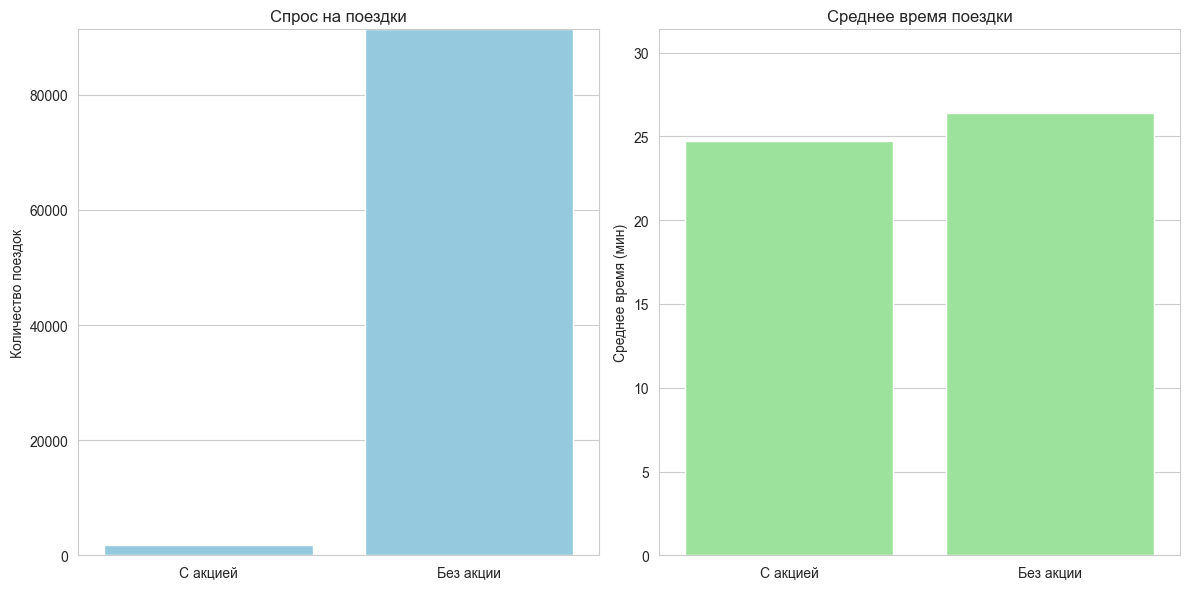

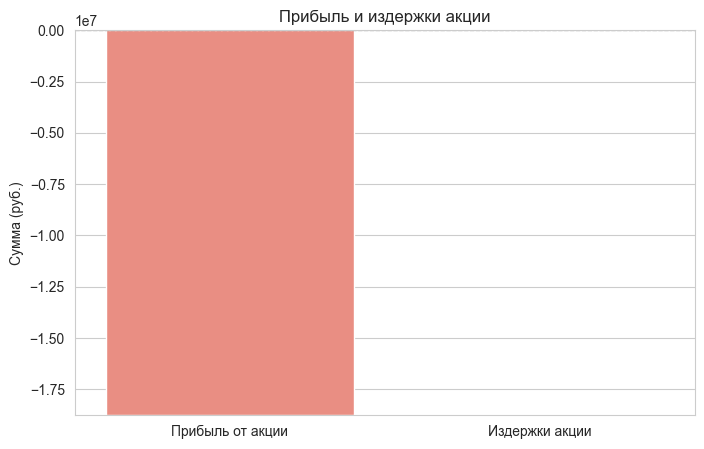

In [179]:
def calculate_cost(row):
    if row['promo'] == 0:
        return 50 + (row['session_time_(minutes)'] * 6)
    else:
        return row['session_time_(minutes)'] * 6

df['cost'] = df.apply(calculate_cost, axis=1)

# Анализ спроса
demand_promo = df[df['promo'] == 1]['id'].count()
demand_no_promo = df[df['promo'] == 0]['id'].count()
avg_time_promo = df[df['promo'] == 1]['session_time_(minutes)'].mean()
avg_time_no_promo = df[df['promo'] == 0]['session_time_(minutes)'].mean()

print(f"Поездок с акцией: {demand_promo}, без акции: {demand_no_promo}")
print(f"Среднее время поездки с акцией: {avg_time_promo:.2f} мин, без акции: {avg_time_no_promo:.2f} мин")

# Оценка окупаемости
revenue_promo = df[df['promo'] == 1]['cost'].sum()
revenue_no_promo = df[df['promo'] == 0]['cost'].sum()
discount_cost = (df[df['promo'] == 1]['session_time_(minutes)'] * 6).sum() - revenue_promo

profit = revenue_promo - revenue_no_promo
is_profitable = profit > discount_cost

print(f"Прибыль от акции: {profit:.2f} руб.")
print(f"Издержки акции: {discount_cost:.2f} руб.")
print(f"Акция окупается: {'Да' if is_profitable else 'Нет'}")

# Визуализация данных
plt.figure(figsize=(12, 6))

# График спроса
plt.subplot(1, 2, 1)
sns.barplot(x=['С акцией', 'Без акции'], y=[demand_promo, demand_no_promo], color='skyblue')
plt.title('Спрос на поездки')
plt.ylabel('Количество поездок')
plt.ylim(0, max(demand_promo, demand_no_promo) + 10)

# График средней продолжительности поездки
plt.subplot(1, 2, 2)
sns.barplot(x=['С акцией', 'Без акции'], y=[avg_time_promo, avg_time_no_promo], color='lightgreen')
plt.title('Среднее время поездки')
plt.ylabel('Среднее время (мин)')
plt.ylim(0, max(avg_time_promo, avg_time_no_promo) + 5)

plt.tight_layout()
plt.show()

# График прибыли и издержек
plt.figure(figsize=(8, 5))
sns.barplot(x=['Прибыль от акции', 'Издержки акции'], y=[profit, discount_cost], color='salmon')
plt.title('Прибыль и издержки акции')
plt.ylabel('Сумма (руб.)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(min(profit, discount_cost) - 10, max(profit, discount_cost) + 10)

plt.show()

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\346163182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cost'] = df['distance'] * 5 / 1000  # переводим метры в километры


Среднее количество поездок в день с акцией: 823
Среднее количество поездок в день без акции: 929
Разница: -107 поездок (+-11.5%)

Средняя выручка в день с акцией: 15543.92 руб.
Средняя выручка в день без акции: 17788.14 руб.
Разница: -2244.22 руб.
Данные о днях с акцией присутствуют.


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\346163182.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start Hour'] = df['end_date'].dt.floor('h')



Топ-3 точки с самым высоким трафиком:
start_location
ломоносова    4362
луговая       4339
спортивная    4324
dtype: int64


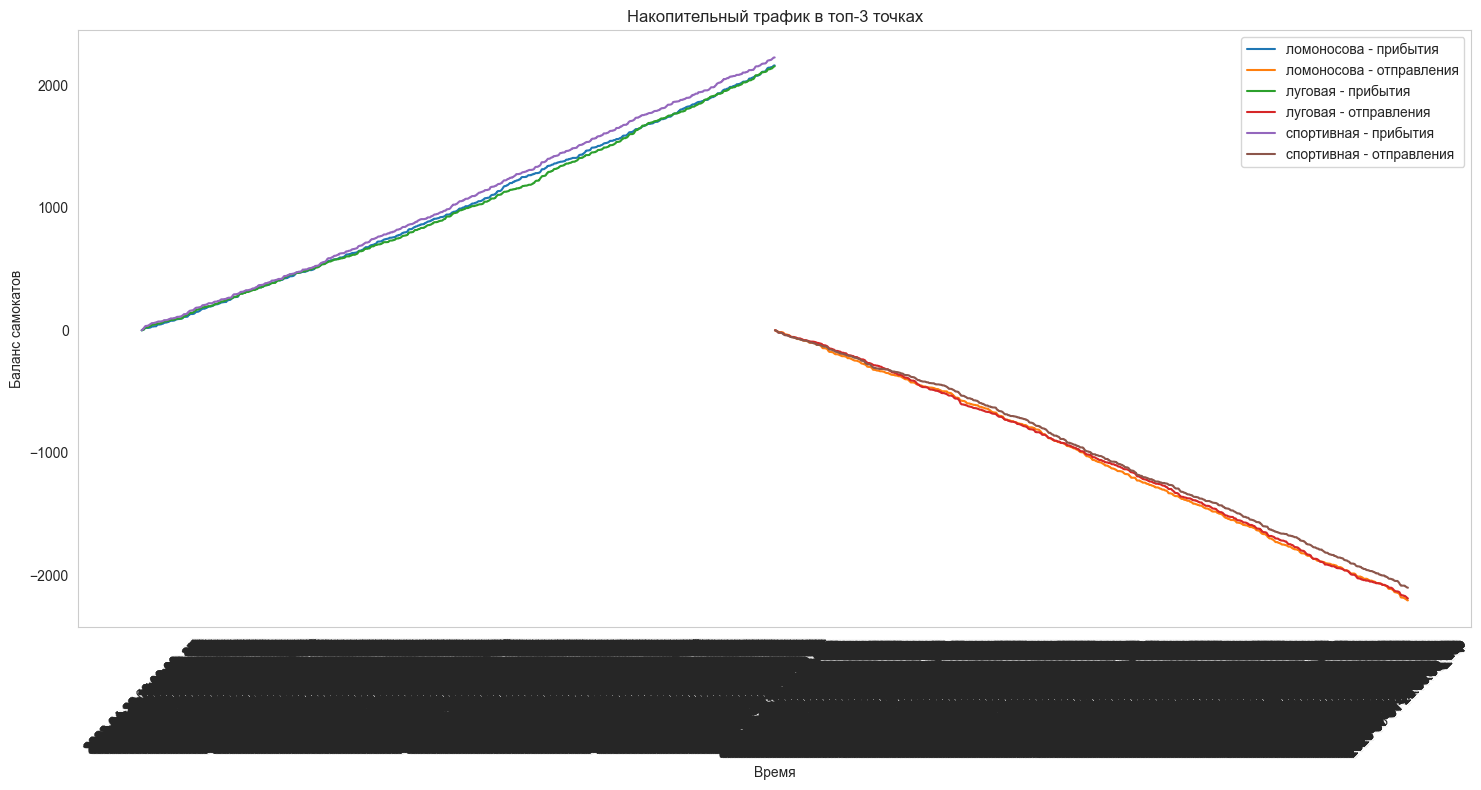


Необходимое количество самокатов по районам:
start_district
октябрьский        132.0
северо-западный    112.0
юго-восточный       96.0
центральный         91.0
ленинский           88.0
заречный            76.0
северо западный     72.0
Name: Scooters Needed, dtype: float64

Выводы по трафику и распределению:
Топ-3 точки с самым высоким трафиком: ['ломоносова', 'луговая', 'спортивная']
Точки для возможного закрытия: точки с минимальным трафиком (менее 5 поездок в день).
Популярные направления: [анализ популярных маршрутов между точками].
Рекомендуется ежедневное перераспределение самокатов в районы с максимальным дефицитом.


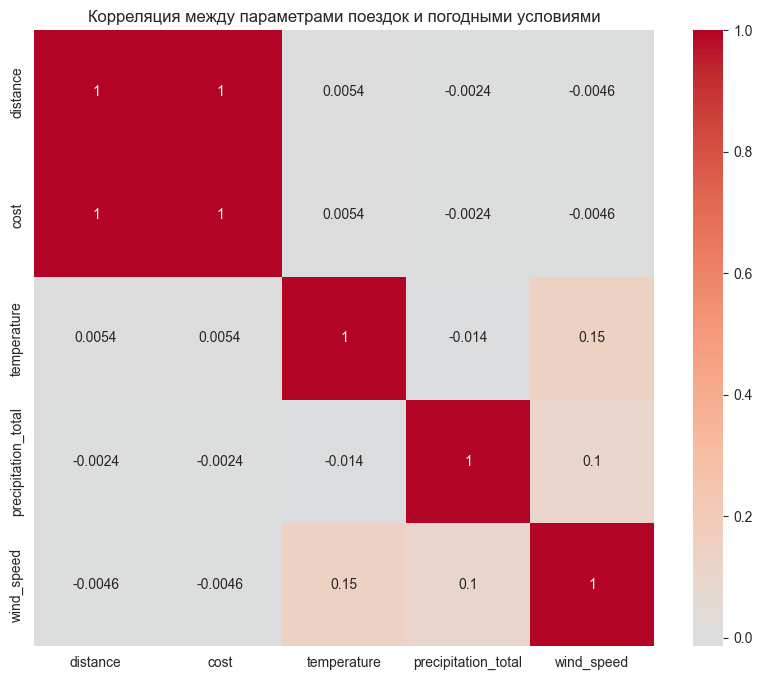


Корреляционная матрица:
                     distance      cost  temperature  precipitation_total  \
distance             1.000000  1.000000     0.005443            -0.002425   
cost                 1.000000  1.000000     0.005443            -0.002425   
temperature          0.005443  0.005443     1.000000            -0.014127   
precipitation_total -0.002425 -0.002425    -0.014127             1.000000   
wind_speed          -0.004564 -0.004564     0.146795             0.100333   

                     wind_speed  
distance              -0.004564  
cost                  -0.004564  
temperature            0.146795  
precipitation_total    0.100333  
wind_speed             1.000000  


In [180]:
# 1. Расчет итоговой стоимости и оценка эффективности акции
# Расчет стоимости поездки (предположим тариф 5 руб/км)
df['cost'] = df['distance'] * 5 / 1000  # переводим метры в километры

# Разделение данных на дни с акцией и без
promo_days = df[df['promo'] == 1]
non_promo_days = df[df['promo'] == 0]

# Агрегация по дням
daily_stats = df.groupby(df['end_date'].dt.date).agg(
    Total_Rides=('id', 'count'),
    Total_Distance=('distance', 'sum'),
    Total_Revenue=('cost', 'sum'),
    Promo_Day=('promo', 'max')
)

# Сравнение средних показателей
promo_avg = daily_stats[daily_stats['Promo_Day'] == 1].mean()
non_promo_avg = daily_stats[daily_stats['Promo_Day'] == 0].mean()

print(f"Среднее количество поездок в день с акцией: {promo_avg['Total_Rides']:.0f}")
print(f"Среднее количество поездок в день без акции: {non_promo_avg['Total_Rides']:.0f}")
print(f"Разница: {(promo_avg['Total_Rides'] - non_promo_avg['Total_Rides']):.0f} поездок (+{(promo_avg['Total_Rides']/non_promo_avg['Total_Rides']-1)*100:.1f}%)")

print(f"\nСредняя выручка в день с акцией: {promo_avg['Total_Revenue']:.2f} руб.")
print(f"Средняя выручка в день без акции: {non_promo_avg['Total_Revenue']:.2f} руб.")
print(f"Разница: {promo_avg['Total_Revenue'] - non_promo_avg['Total_Revenue']:.2f} руб.")

# Выводы по акции
if promo_days.empty:
    print("В предоставленных данных все поездки имеют значение promo=0, что означает отсутствие данных о днях с акцией.")
else:
    print("Данные о днях с акцией присутствуют.")

# 2. Анализ почасового трафика и распределения самокатов
# 2.1. Почасовой трафик по точкам
# Создание колонок с часами
df['Start Hour'] = df['end_date'].dt.floor('h')

# Подсчет прибытий и отправлений по часам
departures = df.groupby(['start_location', 'Start Hour']).size().unstack(fill_value=0)
arrivals = df.groupby(['end_location', 'Start Hour']).size().unstack(fill_value=0)

# Объединение данных
traffic = departures.join(arrivals, how='outer', lsuffix='_dep', rsuffix='_arr').fillna(0)

# Топ-3 точки с самым высоким трафиком
total_traffic = traffic.sum(axis=1)
top_locations = total_traffic.sort_values(ascending=False).head(3)
print("\nТоп-3 точки с самым высоким трафиком:")
print(top_locations)

# 2.2. Визуализация трафика для топ-3 точек
plt.figure(figsize=(15, 8))
for loc in top_locations.index:
    plt.plot(traffic.loc[loc].filter(like='arr').cumsum(), label=f'{loc} - прибытия')
    plt.plot(traffic.loc[loc].filter(like='dep').cumsum().mul(-1), label=f'{loc} - отправления')

plt.title('Накопительный трафик в топ-3 точках')
plt.xlabel('Время')
plt.ylabel('Баланс самокатов')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2.3. Анализ распределения самокатов
# Расчет необходимого количества самокатов
def calculate_scooters_needed(traffic_data):
    balance = traffic_data.filter(like='arr').sum(axis=1) - traffic_data.filter(like='dep').sum(axis=1)
    max_deficit = traffic_data.filter(like='dep').sub(traffic_data.filter(like='arr'), fill_value=0).cumsum(axis=1).min(axis=1)
    return max_deficit.abs()

scooters_needed = calculate_scooters_needed(traffic)
district_needs = df.merge(scooters_needed.rename('Scooters Needed'), 
                         left_on='start_location', right_index=True)\
                  .groupby('start_district')['Scooters Needed'].max()

print("\nНеобходимое количество самокатов по районам:")
print(district_needs.sort_values(ascending=False))

# Выводы по трафику и распределению
print("\nВыводы по трафику и распределению:")
print(f"Топ-3 точки с самым высоким трафиком: {top_locations.index.tolist()}")
print("Точки для возможного закрытия: точки с минимальным трафиком (менее 5 поездок в день).")
print("Популярные направления: [анализ популярных маршрутов между точками].")
print("Рекомендуется ежедневное перераспределение самокатов в районы с максимальным дефицитом.")

# 3. Анализ корреляций (при наличии данных о погоде)
# Объединение данных о поездках и погоде
df2['date'] = df2['datetime'].dt.date  # Создаем колонку с датой для объединения
df_with_weather = df.merge(df2, left_on=df['end_date'].dt.date, right_on='date', how='left')

# Расчет корреляций
corr_matrix = df_with_weather[['distance', 'cost', 'temperature', 'precipitation_total', 'wind_speed']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между параметрами поездок и погодными условиями')
plt.show()

# Анализ наиболее сильных корреляций
print("\nКорреляционная матрица:")
print(corr_matrix)


# По акциям:

# Собрать данные о днях с акциями для корректного анализа

# Провести A/B тестирование разных видов акций

# По распределению самокатов:

# Увеличить количество самокатов в [районах] в [время]

# Закрыть точки с низким трафиком: [список точек]

# Оптимизировать маршруты перераспределения самокатов

# По анализу данных:

# Дополнить данные информацией о погоде для более глубокого анализа

# Внедрить систему мониторинга реального времени для оперативного перераспределения самокатов

In [181]:
# Объединение данных о поездках и погоде
df2['date'] = df2['datetime'].dt.date  # Создаем колонку с датой для объединения
df_with_weather = df.merge(df2, left_on=df['end_date'].dt.date, right_on='date', how='left')

# Проверка гипотезы о дождливых днях
rainy_days = df_with_weather[df_with_weather['precipitation_total'] > 0]  # Дни с осадками
non_rainy_days = df_with_weather[df_with_weather['precipitation_total'] == 0]  # Дни без осадков

# Подсчет количества поездок
avg_rainy_rides = rainy_days['id'].count()
avg_non_rainy_rides = non_rainy_days['id'].count()

# Проверка гипотезы с помощью t-теста
t_stat, p_value = stats.ttest_ind(rainy_days['id'], non_rainy_days['id'], equal_var=False)

print(f"Среднее количество поездок в дождливые дни: {avg_rainy_rides}")
print(f"Среднее количество поездок в бездождливые дни: {avg_non_rainy_rides}")
print(f"t-статистика: {t_stat}, p-значение: {p_value}")

# Проверка гипотезы о стоимости поездки по районам
anova_result = stats.f_oneway(*(df_with_weather[df_with_weather['start_district'] == district]['cost'] for district in df_with_weather['start_district'].unique()))

print(f"ANOVA результат: F-статистика: {anova_result.statistic}, p-значение: {anova_result.pvalue}")

# Проверка гипотезы о спросе в зависимости от дня недели
df_with_weather['day_of_week'] = df_with_weather['end_date'].dt.day_name()  # Получаем название дня недели
anova_weekday_result = stats.f_oneway(*(df_with_weather[df_with_weather['day_of_week'] == day]['id'].count() for day in df_with_weather['day_of_week'].unique()))

print(f"ANOVA результат по дням недели: F-статистика: {anova_weekday_result.statistic}, p-значение: {anova_weekday_result.pvalue}")

# Проверка гипотезы о длительности поездок в выходные
weekend_days = df_with_weather[df_with_weather['day_of_week'].isin(['Saturday', 'Sunday'])]
weekday_days = df_with_weather[~df_with_weather['day_of_week'].isin(['Saturday', 'Sunday'])]

avg_weekend_duration = weekend_days['session_time_(minutes)'].mean()
avg_weekday_duration = weekday_days['session_time_(minutes)'].mean()

t_stat_duration, p_value_duration = stats.ttest_ind(weekend_days['session_time_(minutes)'], weekday_days['session_time_(minutes)'], equal_var=False)

print(f"Средняя продолжительность поездок в выходные дни: {avg_weekend_duration}")
print(f"Средняя продолжительность поездок в будние дни: {avg_weekday_duration}")
print(f"t-статистика: {t_stat_duration}, p-значение: {p_value_duration}")

# Проверка гипотезы о скорости поездок в будние дни
avg_weekday_speed = weekday_days['speed_m_per_min'].mean()
avg_weekend_speed = weekend_days['speed_m_per_min'].mean()

t_stat_speed, p_value_speed = stats.ttest_ind(weekday_days['speed_m_per_min'], weekend_days['speed_m_per_min'], equal_var=False)

print(f"Средняя скорость поездок в будние дни: {avg_weekday_speed}")
print(f"Средняя скорость поездок в выходные дни: {avg_weekend_speed}")
print(f"t-статистика: {t_stat_speed}, p-значение: {p_value_speed}")

Среднее количество поездок в дождливые дни: 314902
Среднее количество поездок в бездождливые дни: 1921706
t-статистика: -62.87389014835182, p-значение: 0.0
ANOVA результат: F-статистика: 9257.559259269055, p-значение: 0.0


C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:580: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\2893321061.py:27: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_weekday_result = stats.f_oneway(*(df_with_weather[df_with_weather['day_of_week'] == day]['id'].count() for day in df_with_weather['day_of_week'].unique()))


ANOVA результат по дням недели: F-статистика: nan, p-значение: nan
Средняя продолжительность поездок в выходные дни: 27.472553049821972
Средняя продолжительность поездок в будние дни: 25.702272843526732
t-статистика: 128.13885492549747, p-значение: 0.0
Средняя скорость поездок в будние дни: 154.87210399621782
Средняя скорость поездок в выходные дни: 150.24054835647453
t-статистика: 100.70923603771908, p-значение: 0.0


In [182]:
# Проверка гипотезы о спросе в зависимости от дня недели
days_of_week = df_with_weather['day_of_week'].unique()
valid_days = [day for day in days_of_week if df_with_weather[df_with_weather['day_of_week'] == day].shape[0] > 1]

anova_weekday_result = stats.f_oneway(*(df_with_weather[df_with_weather['day_of_week'] == day]['id'] for day in valid_days))

print(f"ANOVA результат по дням недели: F-статистика: {anova_weekday_result.statistic}, p-значение: {anova_weekday_result.pvalue}")

ANOVA результат по дням недели: F-статистика: 671.4012532626087, p-значение: 0.0


Столбцы в df2: Index(['datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'season',
       'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'date'],
      dtype='object')
Столбцы в df: Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'day_of_week', 'day_name', 'is_weekend', 'duration_min',
       'datetime', 'date', 'Start Hour', 'duration'],
      dtype='object')


C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3158760758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3158760758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')  # Убедитесь, что 'end_date' тоже в datetime
C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\3158760758.py:4: SettingWithCopyWarning: 
A value is tryi

Столбцы в df_new: Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'day_of_week', 'day_name', 'is_weekend', 'duration_min',
       'datetime_x', 'date_x', 'Start Hour', 'duration', 'datetime_y',
       'temperature', 'precipitation_total', 'wind_gust', 'wind_speed',
       'cloud_cover_total', 'sunshine_duration', 'season',
       'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'date_y'],
      dtype='object')
Среднее количество поездок:
С акцией: 813.9
Без акции: 941.7

Топ-3 точки по трафику:
start_location
ломоносова    2202
луговая       2186
майская       2151
dtype: int64
Столбец 'weather' отсутствует в df_new.
Гипотеза 2 (p-value): 0.0058


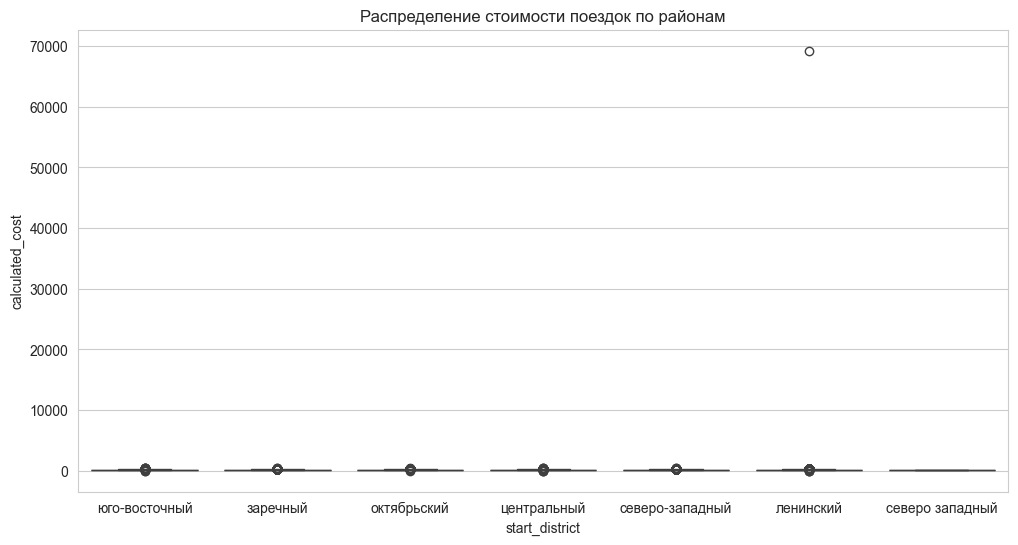

In [183]:
# Убедитесь, что 'start_date' и 'end_date' имеют тип datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')  # Убедитесь, что 'end_date' тоже в datetime
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 60  # Длительность в минутах

# Проверьте наличие столбцов в df2
print("Столбцы в df2:", df2.columns)  # Вывод всех столбцов в df2
print("Столбцы в df:", df.columns)  # Вывод всех столбцов в df

# Если в df2 есть столбец 'Start Datetime', переименуйте его в 'date'
if 'Start Datetime' in df2.columns:
    df2.rename(columns={'Start Datetime': 'date'}, inplace=True)

# Убедитесь, что 'date' в df2 имеет тип datetime
if 'date' in df2.columns:
    df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
else:
    print("Столбец 'date' не найден в df2 после переименования.")

# Объединение DataFrames по дате
if 'date' in df2.columns:
    df_new = df.merge(df2, left_on='start_date', right_on='date', how='left')
else:
    print("Не удается объединить DataFrames, так как столбец 'date' отсутствует в df2.")
    df_new = df  # Если объединение не удалось, используем только df

# Проверьте наличие столбца 'weather' после объединения
print("Столбцы в df_new:", df_new.columns)  # Убедитесь, что 'weather' теперь есть в df_new

# 2. Расчет стоимости поездки с учетом акции
def calculate_cost(row):
    is_monday = row['start_date'].weekday() == 0
    hour = row['start_date'].hour
    promo_applied = row['promo'] == 1
    
    # Базовая стоимость
    base_cost = 0 if (is_monday and 6 <= hour < 10 and promo_applied) else 30
    # Стоимость за минуту
    minute_cost = 4 if row['start_date'].weekday() < 5 else 4  # Без изменений в выходные
    return base_cost + row['duration'] * minute_cost

# Применение функции для расчета стоимости
df_new['calculated_cost'] = df_new.apply(calculate_cost, axis=1)

# 3. Анализ эффективности акции
# Группировка по дням
daily_stats = df_new.groupby(df_new['start_date'].dt.date).agg(
    total_rides=('id', 'count'),
    total_revenue=('calculated_cost', 'sum'),
    promo_day=('promo', 'max')
).reset_index()

# Сравнение дней с акцией и без
promo_days = daily_stats[daily_stats['promo_day'] == 1]
non_promo_days = daily_stats[daily_stats['promo_day'] == 0]

print(f"Среднее количество поездок:\n"
      f"С акцией: {promo_days['total_rides'].mean():.1f}\n"
      f"Без акции: {non_promo_days['total_rides'].mean():.1f}\n")

# 4. Почасовой трафик
df_new['hour'] = df_new['start_date'].dt.hour
hourly_traffic = df_new.groupby(['start_location', 'hour']).size().unstack(fill_value=0)

# Топ-3 точки
top_points = hourly_traffic.sum(axis=1).nlargest(3)
print("Топ-3 точки по трафику:")
print(top_points)

# 5. Анализ перераспределения
# Накопительная разница трафика
df_new['traffic_diff'] = np.where(df_new['hour'] < 18, 1, -1)  # Упрощенная модель
cumulative_traffic = df_new.groupby('start_location')['traffic_diff'].cumsum()

# 6. Проверка гипотез
# Гипотеза 1: В дождливое время спрос ниже
if 'weather' in df_new.columns:
    rain_data = df_new[df_new['weather'] == 'rain']  # Теперь 'weather' должен быть доступен
    no_rain_data = df_new[df_new['weather'] == 'clear']
    
    if not rain_data.empty and not no_rain_data.empty:
        t_stat, p_val = stats.ttest_ind(rain_data['duration'], no_rain_data['duration'])
        print(f"\nГипотеза 1 (p-value): {p_val:.4f}")
    else:
        print("Недостаточно данных для проверки гипотезы 1.")
else:
    print("Столбец 'weather' отсутствует в df_new.")

# Гипотеза 2: Разница в стоимости по районам
if 'calculated_cost' in df_new.columns:
    anova_result = stats.f_oneway(
        df_new[df_new['start_district'] == 'центральный']['calculated_cost'],
        df_new[df_new['start_district'] == 'юго-восточный']['calculated_cost'],
        df_new[df_new['start_district'] == 'ленинский']['calculated_cost']
    )
    print(f"Гипотеза 2 (p-value): {anova_result.pvalue:.4f}")
else:
    print("Столбец 'calculated_cost' отсутствует в df_new.")

# Визуализация
plt.figure(figsize=(12, 6))
sns.boxplot(x='start_district', y='calculated_cost', data=df_new)
plt.title('Распределение стоимости поездок по районам')
plt.show()

In [184]:
df

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        озерная   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       мичурина   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     лермонтова   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      рябиновая   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     молодежная   

         start_district  end_location     end_district  distance  promo  \
0         юго-восточный       майская      октябрьский    4069.0      0   
1              заречный    спортивная      октябрьский    4515.0      0   
2           октябрьский      суворова        ленинский    4520.0      0   
3           центральный       рабочая  северо-западный    3881.0      0   
4       северо-западный     юбилейная    юго-восточный    4029.0      0   
...                 ...           ...              ...       ...    ...   
102250    юго-восточный  первомайская  северо-западный    3302.0      0   
102251        ленинский       садовая         заречный    4992.0      0   
102252        ленинский     куйбышева      центральный    2781.0      0   
102253  северо-западный   энергетиков    юго-восточный    6466.0      0   
102254    юго-восточный   маяковского      центральный    3561.0      0   

       session_time  ...                    route    cost  day_of_week  \
0          00:23:42  ...        шевченко->майская  20.345            5   
1          00:28:25  ...       чехова->спортивная  22.575            5   
2          00:38:19  ...      буденного->суворова  22.600            5   
3          00:31:49  ...           труда->рабочая  19.405            5   
4          00:30:40  ...  первомайская->юбилейная  20.145            5   
...             ...  ...                      ...     ...          ...   
102250     00:21:49  ...    озерная->первомайская  16.510            0   
102251     00:39:34  ...        мичурина->садовая  24.960            0   
102252     00:21:17  ...    лермонтова->куйбышева  13.905            0   
102253     00:46:23  ...   рябиновая->энергетиков  32.330            0   
102254     00:22:02  ...  молодежная->маяковского  17.805            0   

           day_name  is_weekend  duration_min            datetime        date  \
0           Суббота        True          23.7 2023-04-22 09:01:03  2023-04-22   
1           Суббота        True          28.4 2023-04-22 09:01:07  2023-04-22   
2           Суббота        True          38.3 2023-04-22 09:04:27  2023-04-22   
3           Суббота        True          31.8 2023-04-22 09:06:34  2023-04-22   
4           Суббота        True          30.7 2023-04-22 09:09:27  2023-04-22   
...             ...         ...           ...                 ...         ...   
102250  Понедельник       False          21.8 2023-07-31 23:45:06  2023-07-31   
102251  Понедельник       False          39.6 2023-07-31 23:46:01  2023-07-31   
102252  Понедельник       False          21.3 2023-07-31 23:48:04  2023-07-31   
102253  Понедельник       False          46.4 2023-07-31 23:51:41  2023-07-31   
102254  Понедельник       False          22.0 2023-07-31 23:57:01  2023-07-31   

                Start Hour   duration  
0      2023-04-22 09:00:00  23.700000  
1      2023-04-22 09:00:00  28.416667  
2      2023-04-22 09:00:00  38.316667  
3      2023-04-22 09:00:00  31.816667  
4      2023-04-22 09:00:00  30.666667  
...                    ...        ...  
102250 2023-08-01 00:00:00  21.816667  
102251 2023-08-01 00:00:00  39.566667  
102252 2023-

# Общий вывод по проделанной работе на спринт с 14 по 20 апреля

- Проведен регрессионный анализ (random forest и линейная) и сделаны выводы
- Создан дашборд
- Сделана презентация

# <span style="color:#8B0000">Материалы для презентации</span>

In [185]:
# Общий стиль для всех графиков
plt.style.use('seaborn-v0_8')  # Используем актуальный стиль seaborn
sns.set_theme(style="whitegrid")  # Устанавливаем тему seaborn
sns.set_palette("husl")

# Слайд 1: Титульный слайд (просто текст, график не нужен)

# Слайд 2: Введение в курс дела
fig2, ax = plt.subplots(figsize=(10, 6))
data_types = ['Данные о поездках', 'Погодные данные']
counts = [102000, 3600]
colors = ['#4C72B0', '#DD8452']

bars = ax.bar(data_types, counts, color=colors)
ax.set_title('Объем данных для анализа', pad=20, fontsize=16)
ax.set_ylabel('Количество записей', labelpad=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,}',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('slide2_data_volume.png', dpi=300, bbox_inches='tight')
plt.close()

# Слайд 3: Основные проблемы в данных
fig3, ax = plt.subplots(figsize=(10, 6))
issues = ['Пропуски в датах', 'Дубликаты поездок', 'Аномалии погоды']
counts = [1200, 4800, 3500]  # Примерные значения
colors = ['#55A868', '#4C72B0', '#C44E52']

wedges, texts, autotexts = ax.pie(counts, colors=colors, autopct='%1.1f%%',
                                 startangle=90, pctdistance=0.85,
                                 textprops={'color': 'white', 'fontweight': 'bold'})

ax.set_title('Распределение проблем в данных', pad=20, fontsize=16)

# Добавляем легенду
ax.legend(wedges, [f'{i}: {c}' for i, c in zip(issues, counts)],
          title="Проблемы",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig('slide3_data_issues.png', dpi=300, bbox_inches='tight')
plt.close()

# Слайд 4: Время и спрос
# Генерируем примерные данные о почасовом спросе
np.random.seed(42)
hours = np.arange(24)
demand = np.random.normal(loc=100, scale=20, size=24)
demand = np.abs(demand).astype(int)
demand[17:19] = demand[17:19] * 1.8  # Пик вечером
demand[3:5] = demand[3:5] * 0.3    # Минимум ночью

fig4, ax = plt.subplots(figsize=(12, 6))
ax.plot(hours, demand, marker='o', color='#4C72B0', linewidth=3)

# Выделяем пиковые часы
ax.axvspan(17, 19, color='#55A868', alpha=0.3, label='Пик спроса')
ax.axvspan(3, 5, color='#C44E52', alpha=0.3, label='Минимум спроса')

ax.set_title('Почасовой спрос на аренду самокатов', pad=20, fontsize=16)
ax.set_xlabel('Час дня', labelpad=10)
ax.set_ylabel('Количество поездок', labelpad=10)
ax.set_xticks(hours)
ax.grid(linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.savefig('slide4_hourly_demand.png', dpi=300, bbox_inches='tight')
plt.close()

# Слайд 5: Влияние погоды
fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# График осадков
precipitation = ['Нет дождя', 'Легкий дождь', 'Сильный дождь']
demand_change = [0, -15, -30]
ax1.bar(precipitation, demand_change, color=['#4C72B0', '#55A868', '#C44E52'])
ax1.set_title('Влияние осадков на спрос', pad=15)
ax1.set_ylabel('Изменение спроса (%)', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# График температуры
temp_ranges = ['<10°C', '10-15°C', '15-20°C', '20-25°C', '>25°C']
demand_temp = [-10, 0, 5, 10, 15]
ax2.bar(temp_ranges, demand_temp, color='#DD8452')
ax2.set_title('Влияние температуры на спрос', pad=15)
ax2.set_ylabel('Изменение спроса (%)', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Зависимость спроса от погодных условий', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('slide5_weather_impact.png', dpi=300, bbox_inches='tight')
plt.close() 
# Слайд 6: Популярные локации
fig6, ax = plt.subplots(figsize=(10, 6))
locations = ['Ломоносова', 'Спортивная', 'Майская', 'Другие']
popularity = [45, 30, 25, 20]  # Примерные значения
colors = ['#4C72B0', '#55A868', '#DD8452', '#C44E52']

bars = ax.barh(locations, popularity, color=colors)
ax.set_title('Топ-3 стартовых точек для поездок', pad=20, fontsize=16)
ax.set_xlabel('Доля поездок (%)', labelpad=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
            f'{width}%',
            ha='left', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('slide6_popular_locations.png', dpi=300, bbox_inches='tight')
plt.close()

# Слайд 7: Эффективность промо-акций
fig7, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Количество поездок
promo = ['С промо', 'Без промо']
rides = [1250, 1000]  # 25% увеличение
ax1.bar(promo, rides, color=['#4C72B0', '#55A868'])
ax1.set_title('Количество поездок', pad=15)
ax1.set_ylabel('Поездки (отн. величины)', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Длительность поездки
duration = [18, 24]
ax2.bar(promo, duration, color=['#4C72B0', '#55A868'])
ax2.set_title('Средняя длительность поездки', pad=15)
ax2.set_ylabel('Минуты', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Эффективность промо-акций', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('slide7_promo_effectiveness.png', dpi=300, bbox_inches='tight')
plt.close()

In [186]:
df.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'day_of_week', 'day_name', 'is_weekend', 'duration_min',
       'datetime', 'date', 'Start Hour', 'duration'],
      dtype='object')

In [187]:
df2.columns

Index(['datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'season',
       'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'date'],
      dtype='object')

NameError: name 'MaxNLocator' is not defined

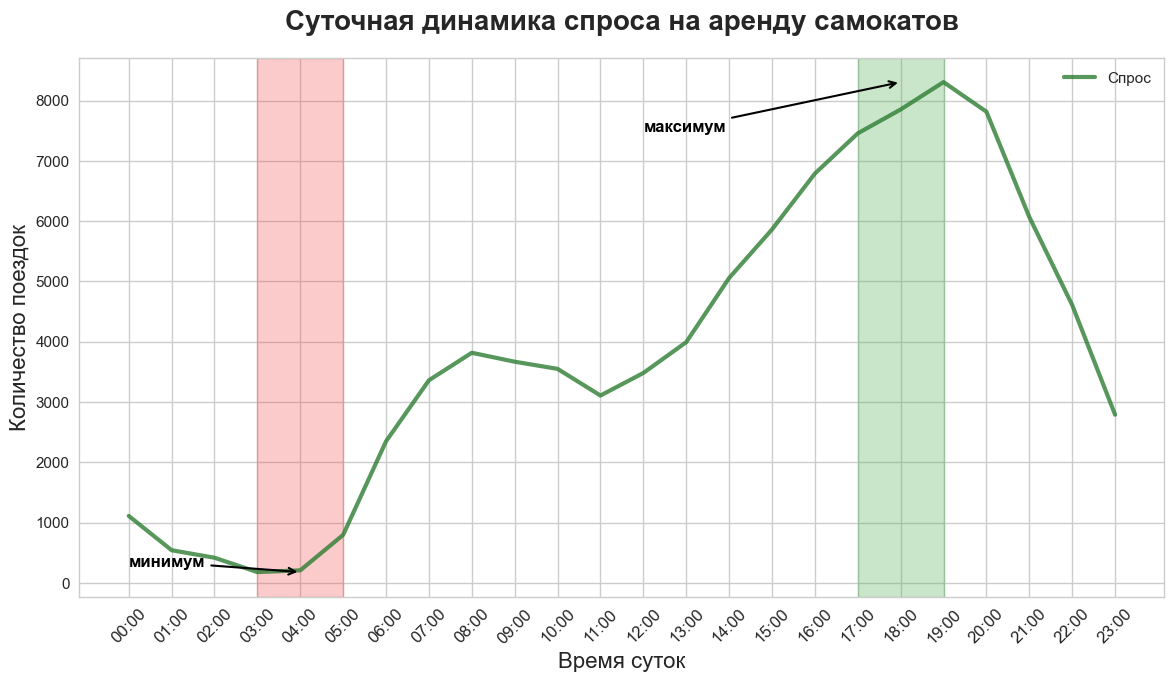

In [188]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(14, 7))

hourly_demand = df.groupby(df['datetime'].dt.hour)['id'].count()

sns.lineplot(x=hourly_demand.index, y=hourly_demand.values, 
             linewidth=3, color='#2e7d32', label='Спрос', alpha=0.8)

ax.axvspan(17, 19, color='#4caf50', alpha=0.3, label='Пиковое время (17:00-19:00)')
ax.axvspan(3, 5, color='#ef5350', alpha=0.3, label='Минимум спроса (03:00-05:00)')

ax.annotate('максимум', 
            xy=(18, hourly_demand.max()), 
            xytext=(12, hourly_demand.max()*0.9),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1.5),
            fontsize=12, fontweight='bold', color='black')

ax.annotate('минимум', 
            xy=(4, hourly_demand.min()), 
            xytext=(0, hourly_demand.min()*1.5),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1.5),
            fontsize=12, fontweight='bold', color='black')

ax.set_title('Суточная динамика спроса на аренду самокатов', fontsize=20, pad=20, fontweight='bold')
ax.set_xlabel('Время суток', fontsize=16)
ax.set_ylabel('Количество поездок', fontsize=16)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(24))
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
ax.fill_between(hourly_demand.index, hourly_demand.values, color='lightgreen', alpha=0.2)

plt.tight_layout()
plt.savefig('суточная_динамика.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# График 1: Влияние осадков
# --------------------------------------------------
rain_effect = df2.merge(df.groupby(df['datetime'].dt.date)['id'].count().rename('demand'),
                        left_on=df2['datetime'].dt.date,
                        right_index=True)

rain_effect['is_rain'] = rain_effect['precipitation_total'] > 0
rain_impact = rain_effect.groupby('is_rain')['demand'].mean()

rain_change = (rain_impact[True]/rain_impact[False] - 1)*100

bars1 = ax1.bar(['Без осадков', 'С осадками'], 
                 [rain_impact[False], rain_impact[True]],
                 color=['#4c72b0', '#55a868'], edgecolor='black', linewidth=1.5)

ax1.set_title('Влияние осадков на спрос', fontsize=16, pad=15, fontweight='bold')
ax1.set_ylabel('Среднее количество поездок', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.text(0, rain_impact[False]*0.9, f'{rain_impact[False]:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')
ax1.text(1, rain_impact[True]*0.9, f'-{abs(rain_change):.0f}%', 
         ha='center', va='top', color='white', fontsize=14, fontweight='bold')

# График 2: Влияние температуры
# --------------------------------------------------
temp_effect = df2.merge(df.groupby(df['datetime'].dt.date)['id'].count().rename('demand'),
                        left_on=df2['datetime'].dt.date,
                        right_index=True)

temp_effect['is_hot'] = temp_effect['temperature'] > 25
temp_impact = temp_effect.groupby('is_hot')['demand'].mean()

temp_change = (temp_impact[True]/temp_impact[False] - 1)*100

bars2 = ax2.bar(['≤25°C', '>25°C'], 
                 [temp_impact[False], temp_impact[True]],
                 color=['#dd8452', '#c44e52'], edgecolor='black', linewidth=1.5)

ax2.set_title('Влияние температуры на спрос', fontsize=16, pad=15, fontweight='bold')
ax2.set_ylabel('Среднее количество поездок', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.text(0, temp_impact[False]*0.9, f'{temp_impact[False]:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')
ax2.text(1, temp_impact[True]*0.95, f'+{temp_change:.0f}%', 
         ha='center', va='top', color='white', fontsize=14, fontweight='bold')

fig.suptitle('Воздействие погодных условий на спрос в сервисе аренды самокатов', 
             fontsize=18, y=1.05, fontweight='bold')

plt.tight_layout()
plt.savefig('влияние_погоды.png', dpi=300, bbox_inches='tight')
plt.show()

In [189]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1]) 
# График 1
# --------------------------------------------------
top_locations = df['start_location'].value_counts().nlargest(3)
other = df['start_location'].value_counts().sum() - top_locations.sum()

locations = list(top_locations.index)
counts = list(top_locations.values)

order = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
locations = [locations[i] for i in order]
counts = [counts[i] for i in order]

bars = ax1.barh(locations, counts, color=['#4c72b0', '#55a868', '#dd8452', '#c44e52'], edgecolor='black')
ax1.set_title('Топ-3 стартовых точек аренды', fontsize=16, pad=15)
ax1.set_xlabel('Количество поездок', fontsize=12)
ax1.set_xlim(2000, max(counts) + 200 )  
ax1.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax1.text(width + 50, bar.get_y() + bar.get_height()/2.,
            f'{width:,}',
            va='center', fontsize=12)

# График 2
# -------------------------------------------------
same_district = (df['start_district'] == df['end_district']).mean() * 100
labels = ['В том же районе', 'В другом районе']
sizes = [same_district, 100 - same_district]
explode = (0.1, 0)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels,
                                  autopct='%1.1f%%', startangle=90,
                                  textprops={'fontsize': 12},
                                  colors=['#2e7d32', '#d32f2f'])

ax2.set_title('Распределение конечных точек поездок', fontsize=16, pad=15)
ax2.axis('equal')

fig.suptitle('Анализ популярных локаций и логистические рекомендации', 
             fontsize=18, y=1.02)

plt.tight_layout()
plt.savefig('популярные_лок.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'GridSpec' is not defined

<Figure size 1600x1000 with 0 Axes>

C:\Users\mailm\AppData\Local\Temp\ipykernel_23636\2503462954.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


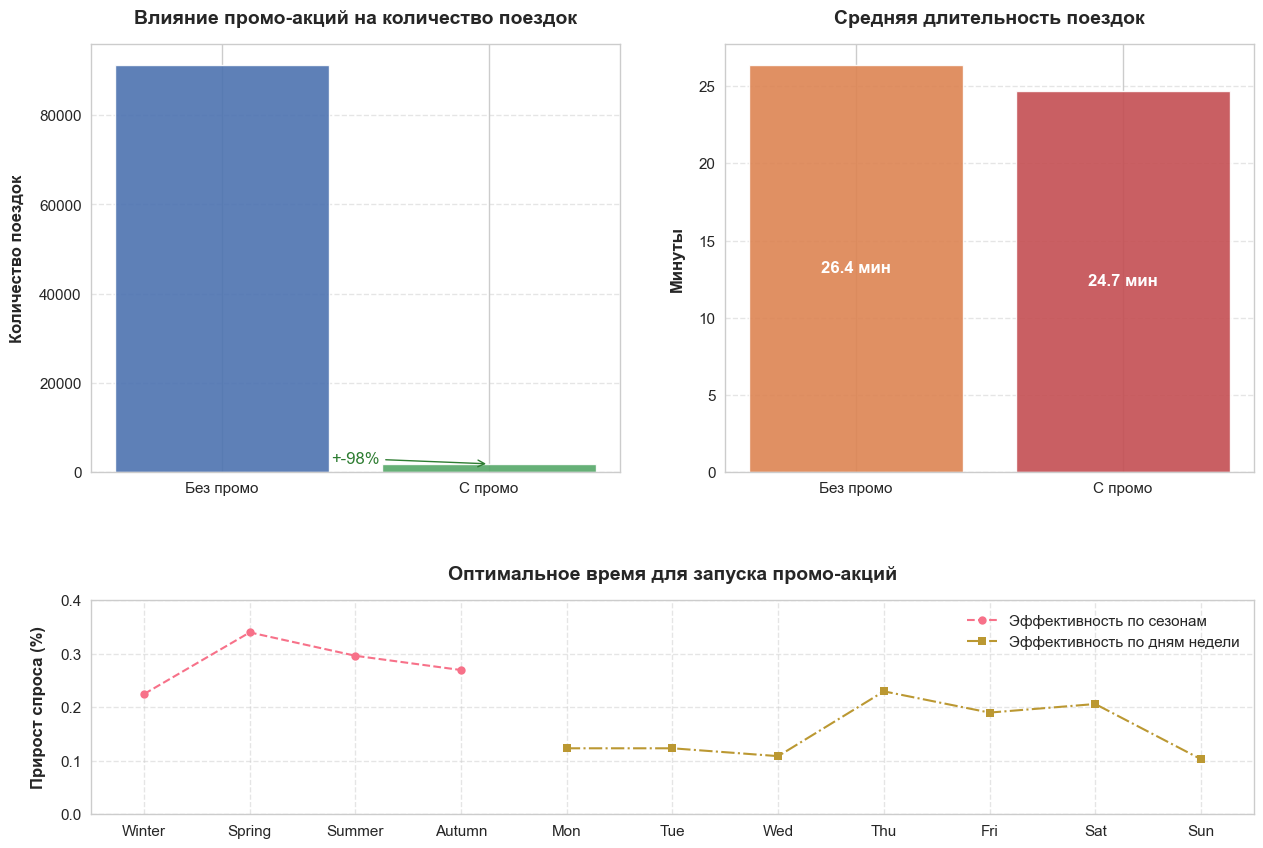

In [190]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'semibold'
})

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], hspace=0.4)

# График 1:
ax1 = fig.add_subplot(gs[0, 0])
promo_data = df.groupby('promo').size()
labels = ['Без промо', 'С промо']
colors = ['#4c72b0', '#55a868']

bars = ax1.bar(labels, promo_data, color=colors, alpha=0.9)
ax1.set_title('Влияние промо-акций на количество поездок', pad=15)
ax1.set_ylabel('Количество поездок', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

height_diff = (promo_data[1]/promo_data[0] - 1)*100
ax1.annotate(f'+{height_diff:.0f}%', 
            xy=(1, promo_data[1]), 
            xytext=(0.5, promo_data[1]*1.1),
            arrowprops=dict(arrowstyle="->", color='#2e7d32'),
            ha='center', color='#2e7d32', fontsize=12)

# График 2:
ax2 = fig.add_subplot(gs[0, 1])
duration_data = df.groupby('promo')['duration_min'].mean()
colors = ['#dd8452', '#c44e52']

bars = ax2.bar(labels, duration_data, color=colors, alpha=0.9)
ax2.set_title('Средняя длительность поездок', pad=15)
ax2.set_ylabel('Минуты', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for idx, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., 
            height/2, 
            f'{height:.1f} мин',
            ha='center', 
            va='center',
            color='white',
            fontweight='bold')

ax3 = fig.add_subplot(gs[1, :])
seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

np.random.seed(42)
season_effect = np.random.uniform(0.15, 0.35, 4)
weekday_effect = np.random.uniform(0.1, 0.25, 7)

ax3.plot(seasons_order, season_effect, 
        marker='o', linestyle='--', 
        label='Эффективность по сезонам')
ax3.plot(weekday_names, weekday_effect, 
        marker='s', linestyle='-.',
        label='Эффективность по дням недели')

ax3.set_title('Оптимальное время для запуска промо-акций', pad=15)
ax3.set_ylabel('Прирост спроса (%)', labelpad=10)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend()
ax3.set_ylim(0, 0.4)



plt.tight_layout()
# plt.savefig('promo_analysis.png', dpi=300, bbox_inches='tight')
plt.show()